In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math

import sys
import csv
import re
import random
import copy
from skimage.transform import downscale_local_mean
from skimage import io
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Multiply, Input, Dropout, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import initializers

C:\Users\Elon\.conda\envs\tf\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
tf.set_random_seed(2435)

In [3]:
data_root = 'D:/HDD Data/cartoons/'
output_root = 'D:/HDD Data/cartoons'
random.seed()

In [4]:
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [5]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

In [6]:
# 1 is white, 0 is black, remember
def convert_to_sample(img, latent_category):
    return np.random.rand(*img.shape)

def flat_vector(img, latent_category):
    return np.random.rand(100)


class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # because I get OOM otherwise
    
    def __init__(self, metadata, first_category_only=False, get_input_vector=flat_vector):
        self.metadata = metadata
        self.first_category_only = first_category_only
        self.get_input_vector = get_input_vector
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # note to self for the future: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 28, 28
        #batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        #batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        datum_index = random.randint(0, len(metadata)-1)
        batch_y = np.asarray(metadata[datum_index], dtype=float)
        batch_y = np.reshape(batch_y, (img_x, img_y))
        batch_y /= 255.0
        latent_category = 1
        batch_x = self.get_input_vector(batch_y, latent_category)
        return batch_x.reshape(1,-1), np.expand_dims(np.expand_dims(batch_y, axis=3), axis=0)
        
        for i in range(batch_size):
            img_scaled = None
            datum_index = random.randint(0, len(metadata)-1)
            j = 0
            while img_scaled is None:
                metadatum = metadata[(datum_index + j) % len(metadata)]
                latent_category = class_to_id[metadatum[0]]
                if latent_category == num_classes-1 or self.first_category_only is False:
                    img_scaled = self.get_image(metadata, (datum_index + j) % len(metadata))
                else:
                    img_scaled = None
                j += 1
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2, 1))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_y[i] /= 255.0
            batch_x = self.get_input_vector(batch_y, latent_category)
        #return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)
        return batch_x.reshape(1,-1), np.expand_dims(batch_y, axis=3)

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            return None
        elif(initial_y > target_y):
            return image[:target_y]
        else: # initial_y <= target_y
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled

In [7]:
def report_epoch_progress(epoch, logs, gen_model, data_test):
    print('epoch', epoch, 'progress report:')
    example = data_test.__getitem__(3)
    latent = example[0]
    print("latent shape: ", latent.shape)
    print("latent: ", latent)
    img = gen_model.predict(latent)
    img = np.squeeze(img, axis=(0,3))
    img *= 255.0
    img = img.astype(int)
    print("output shape: ", img.shape)

    actual = example[1]
    actual = np.squeeze(actual, axis=(0,3))
    #actual = np.expand_dims(actual, axis=3)
    actual *= 255.0
    actual = actual.astype(int)
    print("actual shape: ", actual.shape)


    #latent = np.squeeze(latent, axis=(0,3))
    #latent *= 255.0
    #latent = latent.astype(int)

    #print("INPUT")
    #io.imshow(latent, cmap='gray')
    #io.show()
    print("OUTPUT")
    io.imshow(img)#, cmap='gray')
    io.show()
    print("TARGET")
    io.imshow(actual)#, cmap='gray')
    io.show()

In [8]:
class GANModel():

    def __init__(self, g, d, gan_inputs=None):
        self.generator = g
        self.discriminator = d
        
        # TODO: clean up the parameters here and elsewhere so it's not just a hacky addon, this shouldn't need to be here
        # anyway
        #if gan_inputs is None:
        #    gan_inputs = Input(shape=(100,))
        
        gan_inputs = Input(shape=(100,))
        
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=gan_output)

    # TODO: I don't think g_lr actually matters or is ever used
    def compile(self, g_lr=.0005, d_lr=.00001, gan_lr=.0001):
        #_optimizer = Adam(lr=g_lr)
        d_optimizer = Adam(lr=d_lr) # lower lr necessary to keep discriminator from getting too much better than generator
        gan_optimizer = Adam(lr=gan_lr) # NOTE: apparently adam automatically scales the lr

        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=d_optimizer, loss='binary_crossentropy')
        self.discriminator.trainable = False
        #gan_loss = ['binary_crossentropy', 'mse']
        # the loss weight should be 1, because when we train the generator we use 1s as the target labels for the gan
        #loss_weights = [-1] # we want to fool the discriminator, so more 'loss' is better
        self.gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')#, loss_weights=loss_weights)
        self.discriminator.trainable = True
        
        # only the progress callback gets used right now, as I'm not sure how to make this work with a custom training loop
        progress_callback = LambdaCallback(on_epoch_end=report_epoch_progress)
        checkpoint_callback = ModelCheckpoint('./model-checkpoint.ckpt')
        tensorboard_callback = TensorBoard(log_dir='../logs/tensorboard-logs', write_images=True)
        self.callbacks = [progress_callback]
        self.gan.summary()
        print(self.gan.metrics_names)

    def train(self, epochs, data_train, data_test, verbose=False, pretrain_discriminator=True):
        self.data_train = data_train
        self.data_test = data_test
        # TODO: switch out these lines
        steps_per_epoch = 1000
        # steps_per_epoch = num_data//self.data_train.batch_size
        discriminator_updates = 1 # discriminator updates per generator update
        report_epoch_progress(None, None, self.generator, self.data_test)
        
        g_loss_history = np.zeros(epochs * steps_per_epoch)
        d_loss_history = np.zeros(epochs * steps_per_epoch)
        
        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)

        # pretrain the discriminator
        if pretrain_discriminator:
            for i in range(steps_per_epoch//5):
                current_batch = self.data_train.__getitem__(0)
                # generate "fake" images
                generator_inputs = current_batch[0]
                generated_images = self.generator.predict(generator_inputs, batch_size=1)
                # train discriminator on "real" images from the dataset and "fake" ones that were generated
                true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                for _ in range(discriminator_updates):
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
        
        d_loss_threshold = .5
        g_loss_threshold = .4
        g_loss = 10.0 # for initialization
        d_loss = 10.0 # for initialization
        # custom training loop
        for epoch in range(epochs):
            steps = 0
            while steps < steps_per_epoch:
                # train discriminator to threshold loss or end of epoch, whichever first
                self.discriminator.trainable = True    
                while True:
                    if steps >= steps_per_epoch:
                        break
                    steps += 1
                    current_batch = self.data_train.__getitem__(0)
                    # generate "fake" images
                    generator_inputs = current_batch[0]
                    generated_images = self.generator.predict(generator_inputs, batch_size=1)
                    # train discriminator on "real" images from the dataset and "fake" ones that were generated
                    true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                    fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                    if d_loss < d_loss_threshold:
                        break

                # train generator to threshold loss or end of epoch, whichever first
                # halt training on the discriminator
                self.discriminator.trainable = False
                while True:
                    if steps >= steps_per_epoch:
                        break
                    steps += 1
                    current_batch = self.data_train.__getitem__(0)
                    # generate "fake" images
                    generator_inputs = current_batch[0]
                    generated_images = self.generator.predict(generator_inputs, batch_size=1)
                    # get "real" images from the dataset and "fake" ones that were generated
                    true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                    fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                    # train generator to try to fool the discriminator
                    #g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                    g_loss = self.gan.train_on_batch(generator_inputs, true_labels)
                    if g_loss < g_loss_threshold:
                        break
                    #if g_loss[0] <= g_loss_threshold:
                    #    break
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True    

                if verbose == True:
                        print('step ', steps,'/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')
        return g_loss_history, d_loss_history    
            
        #    for step in range(steps_per_epoch):
        #        current_batch = self.data_train.__getitem__(0)
        #        # generate "fake" images
        #        generator_inputs = current_batch[0]
        #        generated_images = self.generator.predict(generator_inputs, batch_size=1)
        #        # train discriminator on "real" images from the dataset and "fake" ones that were generated
        #        true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
        #        fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
        #        for _ in range(discriminator_updates):
        #            d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
        #            d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
        #            d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
        #        # halt training on the discriminator
        #        self.discriminator.trainable = False
        #        # train generator to try to fool the discriminator
        #        g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
        #        # and allow training on the discriminator to continue
        #        self.discriminator.trainable = True
        #        if verbose == True:
        #            print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
        #        g_loss_history[epoch * steps_per_epoch + step] = g_loss[0]
        #        d_loss_history[epoch * steps_per_epoch + step] = d_loss
        #    # manually call callbacks since we're doing a custom fit
        #    logs = {'loss': g_loss}
        #    for callback in self.callbacks:
        #        callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        ##manually terminate callbacks since we're doing a custom fit
        #for callback in self.callbacks:
        #   callback.on_train_end('_')
        #eturn g_loss_history, d_loss_history


In [11]:
d_input = Input(shape=(28, 28, 1))
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('softmax')(layer)
d_output = Dense(1)(layer)

In [8]:
def test_gan(g_input, g_output, d_input, d_output, epochs=2, first_category_only=False, input_method=flat_vector, inputs=None, g_lr=.0005, d_lr=.00001, gan_lr=.0001):
    # we have to reinstantiate the generator and discriminator or the weights won't be reset
    generator = Model(g_input, g_output, name='generator')
    discriminator = Model(d_input, d_output, name='discriminator')
    gan_model = GANModel(generator, discriminator, inputs)
    gan_model.compile(g_lr, d_lr, gan_lr)
    data_train = DataProvider(metadata_train, first_category_only, get_input_vector=input_method)
    data_test = DataProvider(metadata_test, first_category_only, get_input_vector=input_method)
    gan_model.train(epochs, data_train, data_test, verbose=True)
    return gan_model

### Baseline: Unparameterized Generation

In [13]:
dense_nodes = 128*5*15
g_input = Input(shape=(100,))
layer = Dense(6272)(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Dense(6272)(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = LeakyReLU(.25)(layer)
#layer = Dropout(.2)(layer)
#layer = Dense(6272)(g_input)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)
layer = Reshape((7, 7, 128))(layer)
# layer = Dropout(.3)(layer)

layer = Conv2DTranspose(128, 3, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = LeakyReLU(.25)(layer)
#layer = Conv2DTranspose(128, 3, padding='same')(layer)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)

layer = UpSampling2D()(layer)

layer = Conv2DTranspose(128, 3, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = LeakyReLU(.25)(layer)
#layer = Conv2DTranspose(128, 3, padding='same')(layer)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)
#layer = Conv2DTranspose(128, 3, padding='same')(layer)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)

layer = UpSampling2D()(layer)

layer = Conv2DTranspose(64, 3, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = LeakyReLU(.25)(layer)
#layer = Conv2DTranspose(128, 3, padding='same')(layer)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)
#layer = Conv2DTranspose(128, 3, padding='same')(layer)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = LeakyReLU(.25)(layer)

layer = Conv2DTranspose(1, 3, padding='same')(layer)

# TODO: could try the below again, but with more filters
#layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = PReLU()(layer)
#for i in range(5):
#    layer = Conv2DTranspose(8, 4, dilation_rate=i+1, padding='same')(layer)
#    layer = BatchNormalization(momentum=.9)(layer)
#    layer = PReLU()(layer)
#for i in range(5, 0, -1):
#    layer = Conv2DTranspose(8, 4, dilation_rate=i+1, padding='same')(layer)
#    layer = BatchNormalization(momentum=.9)(layer)
#    layer = PReLU()(layer)
#layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('tanh')(layer)

In [14]:
current_model = test_gan(g_input, g_output, d_input, d_output, first_category_only=True, epochs=200, g_lr=.0001, d_lr=.0001, gan_lr=.0001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1029377   
_________________________________________________________________
discriminator (Model)        (None, 1)                 37857     
Total params: 1,029,441
Trainable params: 1,016,193
Non-trainable params: 13,248
_________________________________________________________________
['loss']
epoch None progress report:


ValueError: could not convert string to float: 'calvinandhobbes'

epoch None progress report:
latent shape:  (1, 100)
latent:  [[0.23833693 0.24622346 0.11668157 0.13308743 0.05745671 0.4956604
  0.87780426 0.90063804 0.50340973 0.4536447  0.73565243 0.91551784
  0.08394051 0.23938812 0.55403636 0.47450604 0.70329356 0.11291355
  0.8781121  0.66661849 0.56084296 0.83409592 0.89123409 0.75687755
  0.83696099 0.26851536 0.67986987 0.73021888 0.04368966 0.45124611
  0.29639346 0.25530334 0.33639256 0.5561626  0.7890317  0.29379195
  0.47547243 0.53869764 0.09865742 0.053282   0.75849155 0.13740227
  0.39327514 0.49157892 0.25167313 0.23315838 0.31298005 0.56548852
  0.61717527 0.37912819 0.99444964 0.32059324 0.07377443 0.4931484
  0.61804878 0.03802687 0.25424498 0.83563462 0.04287331 0.69204553
  0.25858149 0.67068372 0.6675884  0.24335995 0.32015477 0.71794406
  0.51268968 0.90338067 0.05856899 0.39526637 0.15714937 0.58572062
  0.15801445 0.11370502 0.76427742 0.99912569 0.91617251 0.53078458
  0.45135778 0.28483593 0.40845632 0.43097505 0.42515446 

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


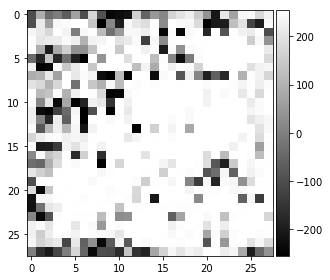

TARGET


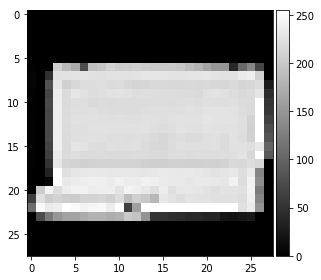

step  1000 / 1000 d_loss:  0.4117427170276642 g_loss:  0.8208708
epoch 0 progress report:
latent shape:  (1, 100)
latent:  [[0.0613413  0.63914291 0.02546787 0.72729559 0.48487892 0.68679896
  0.84911959 0.24158982 0.26182823 0.35963615 0.89487453 0.66612282
  0.95400994 0.36701356 0.50113528 0.75016073 0.86573005 0.2431341
  0.40694939 0.59976957 0.81839974 0.16696355 0.40551051 0.89683963
  0.91535326 0.33937082 0.46400775 0.33271654 0.34685101 0.89460017
  0.06600232 0.35932947 0.58824286 0.07116922 0.0522265  0.79080091
  0.16960262 0.29368686 0.68342725 0.92212927 0.68917595 0.81490671
  0.02023122 0.77001024 0.97022818 0.48574099 0.06047196 0.59928005
  0.13175115 0.13612866 0.95679206 0.19500239 0.30880225 0.83861796
  0.71241823 0.25426134 0.82320647 0.0642674  0.87011458 0.90744432
  0.87911598 0.15872362 0.47375962 0.99269312 0.01880271 0.13446182
  0.27624157 0.3964064  0.10287066 0.16734143 0.80855445 0.10547066
  0.26569831 0.56701563 0.15879351 0.62777508 0.21419842 0.604

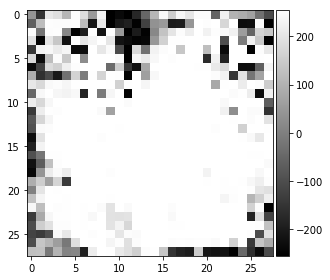

TARGET


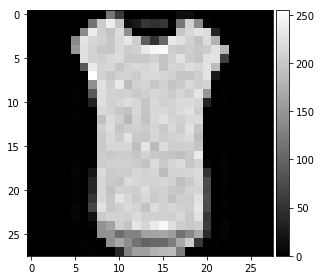

step  1000 / 1000 d_loss:  0.4122891426086426 g_loss:  0.8205938
epoch 1 progress report:
latent shape:  (1, 100)
latent:  [[0.57777732 0.0134989  0.24486403 0.34137059 0.346013   0.86921878
  0.92231036 0.321423   0.61262619 0.99143702 0.17421774 0.78160867
  0.58054342 0.5983914  0.11511334 0.12334171 0.75654566 0.07199959
  0.75554816 0.00937607 0.98004606 0.02384744 0.98099541 0.7417566
  0.18269457 0.48068483 0.76866168 0.6380083  0.51122489 0.36132572
  0.191196   0.54948949 0.88994916 0.45654486 0.62712353 0.79492905
  0.53674348 0.40771279 0.17595689 0.99046184 0.03515125 0.39621448
  0.03677437 0.12727234 0.40768014 0.55384989 0.26913896 0.02700843
  0.16532738 0.04616924 0.60771908 0.01725773 0.37742795 0.24157286
  0.16057954 0.85278684 0.36280338 0.53964861 0.03478424 0.16107131
  0.96102183 0.94855771 0.40579649 0.92434151 0.3621603  0.58278577
  0.0612815  0.97787258 0.22030441 0.91854037 0.60535133 0.29504704
  0.30269046 0.14361678 0.95394587 0.62134157 0.1621131  0.081

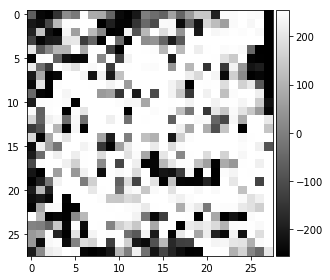

TARGET


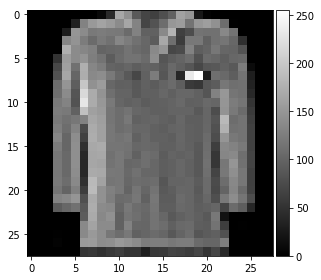

step  1000 / 1000 d_loss:  0.4136180877685547 g_loss:  0.8191528
epoch 2 progress report:
latent shape:  (1, 100)
latent:  [[0.01826432 0.50531343 0.88665824 0.34791564 0.25717304 0.96098199
  0.60817946 0.7849468  0.22599498 0.75538651 0.80445625 0.91949023
  0.36978892 0.50380991 0.24522301 0.14259334 0.51990569 0.14131157
  0.24749839 0.78250297 0.65019528 0.26347969 0.44739399 0.01576478
  0.04474571 0.0701337  0.0628932  0.28728206 0.5935376  0.49199928
  0.132693   0.64000676 0.35440635 0.15635387 0.46665064 0.97186555
  0.1134946  0.50229625 0.11796115 0.22868565 0.44359176 0.66796384
  0.36102485 0.48210616 0.80283689 0.82288979 0.3444263  0.38378458
  0.58097082 0.71703998 0.77211639 0.25315158 0.45528732 0.5676384
  0.54279679 0.03461704 0.36919107 0.25146333 0.37628322 0.35648453
  0.07409672 0.29128155 0.37312771 0.64974325 0.89708423 0.91441517
  0.41295049 0.09500774 0.23608629 0.00695921 0.595588   0.91368562
  0.05123616 0.14596099 0.93555057 0.13557774 0.19351595 0.948

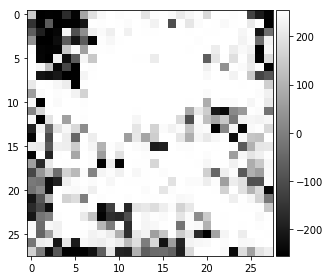

TARGET


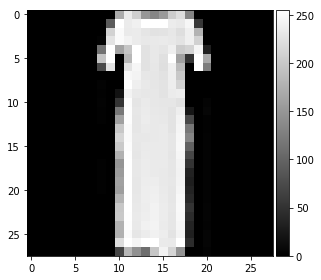

step  1000 / 1000 d_loss:  0.4097176790237427 g_loss:  0.8185644
epoch 3 progress report:
latent shape:  (1, 100)
latent:  [[0.46751924 0.83446666 0.90513843 0.94651437 0.74695945 0.69154373
  0.65393715 0.74455272 0.68253627 0.28266636 0.14123184 0.25574212
  0.88088108 0.71638339 0.44353272 0.06707039 0.36881469 0.43774856
  0.02007108 0.74326607 0.03256271 0.63291001 0.3246769  0.88065763
  0.66303628 0.20846598 0.72197041 0.1451487  0.36579928 0.23822875
  0.27365874 0.04744613 0.51287066 0.2345188  0.58255377 0.09948998
  0.34699813 0.60091812 0.57834241 0.2706538  0.44354621 0.70657569
  0.4382889  0.61169872 0.66579886 0.18193637 0.73505154 0.75629208
  0.5613001  0.53938191 0.5149149  0.21780676 0.89220899 0.9057777
  0.10697802 0.34524541 0.91651273 0.39563148 0.75734716 0.87898261
  0.34532064 0.34109696 0.78635949 0.03102157 0.66703201 0.74199498
  0.5740621  0.32623421 0.75758543 0.12157354 0.3621771  0.62980877
  0.40362029 0.06389669 0.54589725 0.33178402 0.87226963 0.821

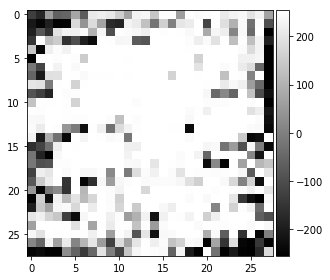

TARGET


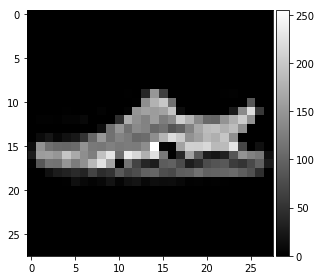

step  1000 / 1000 d_loss:  0.4368102252483368 g_loss:  0.818262
epoch 4 progress report:
latent shape:  (1, 100)
latent:  [[0.84263668 0.4235402  0.71119534 0.0633033  0.5403339  0.68353931
  0.1321563  0.59681542 0.98758966 0.86196045 0.19941842 0.33057177
  0.68481095 0.47881819 0.03040104 0.54803085 0.92446331 0.80155664
  0.40044914 0.75566141 0.36340959 0.04802964 0.28351351 0.9401758
  0.92266776 0.40962152 0.69956395 0.25162552 0.76168671 0.77271533
  0.10564379 0.61527418 0.02767643 0.02864271 0.60327574 0.64043525
  0.917686   0.97926772 0.06343713 0.36422635 0.57512127 0.15076819
  0.30855439 0.67114411 0.79447139 0.72707257 0.60041841 0.65769623
  0.88523363 0.26710601 0.25933895 0.88690633 0.04494465 0.2022335
  0.57574991 0.98850341 0.62357122 0.11396832 0.24957478 0.20093197
  0.20427527 0.57667562 0.76397347 0.34808346 0.80218267 0.72155213
  0.40179031 0.27809912 0.51855972 0.95035348 0.98556992 0.67745879
  0.46150731 0.82025366 0.24926587 0.90205643 0.62763187 0.26817

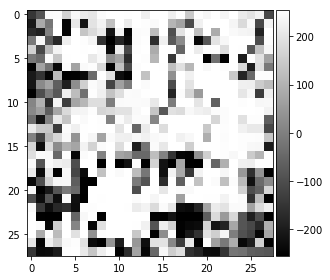

TARGET


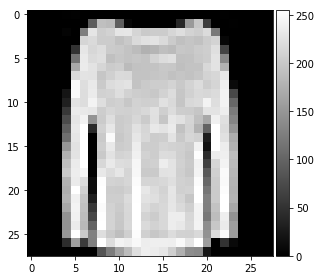

step  1000 / 1000 d_loss:  0.48814108967781067 g_loss:  0.81708986
epoch 5 progress report:
latent shape:  (1, 100)
latent:  [[0.72766378 0.5931127  0.56231983 0.77372989 0.0222193  0.16798483
  0.06126489 0.90823981 0.27829579 0.05440083 0.38235381 0.74778156
  0.52247493 0.85816814 0.60467046 0.276263   0.66399799 0.68396187
  0.78632896 0.75142719 0.81697857 0.26954229 0.40121654 0.22236723
  0.02036417 0.52022883 0.04775764 0.37793053 0.89381616 0.75009078
  0.27492678 0.19891065 0.18359281 0.0956952  0.92173315 0.59996694
  0.60479127 0.79774026 0.05810252 0.30071017 0.69267186 0.78594089
  0.96199728 0.64345997 0.83452533 0.5766273  0.26529802 0.990365
  0.14474396 0.26654197 0.87742607 0.2225668  0.22789368 0.66775988
  0.82351057 0.58968739 0.29553858 0.97022866 0.40631175 0.59363189
  0.97929534 0.20989978 0.57224252 0.10652341 0.59160072 0.8242469
  0.63306129 0.3797645  0.30121254 0.28622212 0.57362948 0.86139035
  0.56341407 0.88590532 0.89802744 0.87725242 0.63519731 0.962

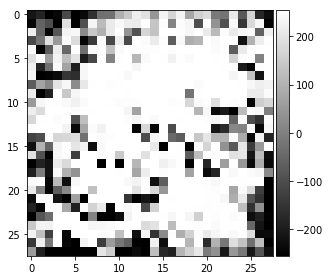

TARGET


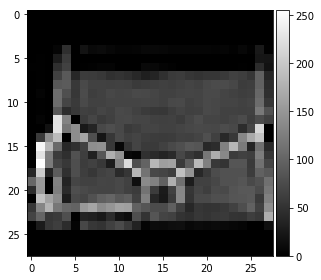

step  1000 / 1000 d_loss:  0.40895238518714905 g_loss:  0.81629753
epoch 6 progress report:
latent shape:  (1, 100)
latent:  [[0.73364782 0.5315435  0.83001252 0.11027715 0.67197038 0.15625536
  0.09620936 0.02747497 0.34612197 0.31682354 0.55807027 0.4017865
  0.56875875 0.11628518 0.80426838 0.13723342 0.69292583 0.63766241
  0.63722052 0.69935874 0.46857174 0.61743001 0.99311419 0.39717685
  0.85685697 0.03676137 0.98342111 0.11220317 0.79723442 0.49642819
  0.67419775 0.54482393 0.03983742 0.42522041 0.16942478 0.53556568
  0.07436371 0.82181565 0.42963814 0.57214376 0.77003256 0.99887566
  0.20280708 0.88632653 0.46636872 0.15869926 0.76395518 0.75006327
  0.80213843 0.7525288  0.38879562 0.29887462 0.96618976 0.81462042
  0.2298597  0.50091204 0.23797344 0.45562206 0.03138172 0.79679698
  0.59772353 0.60152484 0.82779996 0.66993081 0.24801334 0.20378441
  0.68375389 0.9451078  0.58311991 0.60320927 0.79690387 0.84018697
  0.7063492  0.84974402 0.66332023 0.09793646 0.57291447 0.3

TARGET


step  1000 / 1000 d_loss:  0.4089607894420624 g_loss:  0.81601393
epoch 7 progress report:
latent shape:  (1, 100)
latent:  [[0.25737578 0.27395675 0.38033879 0.46354474 0.05228312 0.58393524
  0.56348715 0.49657843 0.06783998 0.96293888 0.51917587 0.58596052
  0.82232437 0.28238882 0.37331247 0.64807622 0.31296171 0.0814999
  0.39741849 0.56833648 0.36464591 0.58007039 0.49835113 0.08703941
  0.15595616 0.07267133 0.6312953  0.01822249 0.69853316 0.95101508
  0.17958841 0.43997224 0.02004432 0.37702557 0.16591025 0.7542107
  0.48625855 0.28925707 0.78314109 0.33111465 0.91976187 0.34481391
  0.40708751 0.40344996 0.52539777 0.75561418 0.93346756 0.88299533
  0.62976312 0.38742662 0.05087331 0.50096059 0.55136384 0.46190993
  0.31044394 0.14723578 0.86810117 0.82133016 0.95678936 0.19383116
  0.28039644 0.28698136 0.12699724 0.45919589 0.29105213 0.39903887
  0.75343237 0.43457954 0.55983442 0.26051957 0.03156214 0.35596769
  0.03655319 0.89310431 0.48496743 0.79290285 0.72741892 0.962

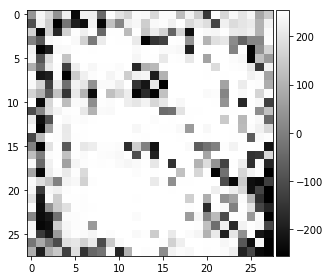

TARGET


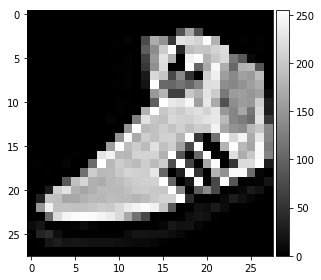

step  1000 / 1000 d_loss:  0.41197139024734497 g_loss:  0.8154801
epoch 8 progress report:
latent shape:  (1, 100)
latent:  [[0.3144137  0.31056213 0.23845177 0.92872531 0.51070337 0.65402887
  0.68071955 0.1128378  0.29465721 0.90794563 0.51684893 0.02631554
  0.58680015 0.74058837 0.67926751 0.06095863 0.89936991 0.85726615
  0.85378623 0.39642131 0.44313767 0.78641682 0.60204579 0.90213446
  0.31979542 0.47870085 0.08796911 0.1552024  0.8047028  0.49117168
  0.76575002 0.4975617  0.04261363 0.28343846 0.8454784  0.82768809
  0.12219293 0.27233224 0.74745836 0.01053458 0.04632467 0.34145437
  0.99144407 0.34544183 0.4107231  0.35082506 0.68517202 0.13214462
  0.42045599 0.52424767 0.9752586  0.46632055 0.03106777 0.82599105
  0.12887733 0.54977176 0.86787797 0.51493514 0.36727329 0.98977388
  0.20305886 0.28819664 0.14989243 0.24673105 0.74615551 0.29703385
  0.5858006  0.30764262 0.7225249  0.06338902 0.09624935 0.43797863
  0.44679123 0.52581222 0.54626042 0.16715802 0.38428985 0.9

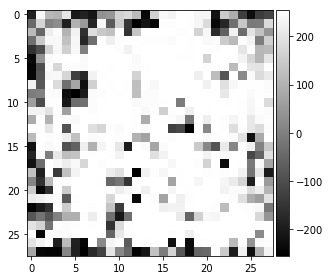

TARGET


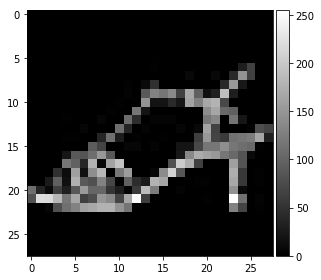

step  1000 / 1000 d_loss:  0.4083068072795868 g_loss:  0.81520355
epoch 9 progress report:
latent shape:  (1, 100)
latent:  [[0.31045525 0.00100871 0.66271103 0.71939103 0.73677778 0.26601733
  0.47732379 0.25973216 0.84864953 0.33182441 0.05252092 0.69286233
  0.25442871 0.05353801 0.0945394  0.22047277 0.84733367 0.21103676
  0.77749652 0.84214625 0.86051627 0.82097131 0.5291772  0.94150218
  0.98668537 0.19961887 0.32196955 0.04690451 0.91278279 0.27242189
  0.50003828 0.60902184 0.0260348  0.33070019 0.01438826 0.98440968
  0.62210223 0.45209191 0.93902617 0.06753663 0.93231986 0.39626151
  0.82087489 0.42202135 0.31086767 0.06721664 0.80329979 0.53558028
  0.13454582 0.34723495 0.5264565  0.97011076 0.59056341 0.99710874
  0.96484142 0.53734652 0.31775153 0.75316602 0.97200903 0.77459866
  0.8329413  0.35654114 0.20752133 0.15943674 0.82954611 0.08958277
  0.42144404 0.70726397 0.34679825 0.3393325  0.07368125 0.0049189
  0.75975317 0.4719917  0.46161322 0.70851361 0.4360495  0.48

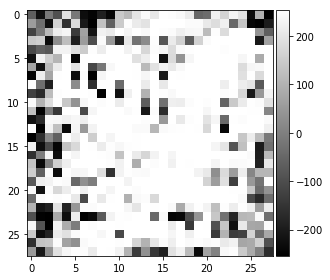

TARGET


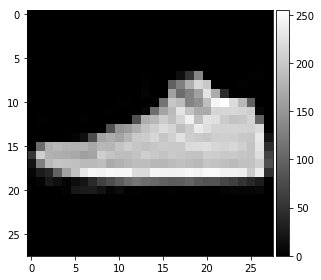

step  1000 / 1000 d_loss:  0.40767204761505127 g_loss:  0.81464064
epoch 10 progress report:
latent shape:  (1, 100)
latent:  [[0.8907234  0.28933731 0.15103835 0.37639863 0.17373954 0.02316961
  0.0526976  0.05921291 0.17565299 0.20797901 0.01232093 0.00321922
  0.23731886 0.91888151 0.37001289 0.82155464 0.68411064 0.20548228
  0.82037649 0.41908162 0.55327676 0.20110043 0.87145077 0.72870821
  0.16244178 0.86827225 0.57067011 0.96488085 0.18641182 0.42294745
  0.95760514 0.66954052 0.35269231 0.43877975 0.73791415 0.88775631
  0.70257401 0.65450884 0.20827204 0.06998027 0.36245134 0.5713164
  0.72689629 0.2606584  0.04619882 0.27309845 0.79157503 0.80402475
  0.00129258 0.47394168 0.59008552 0.45469055 0.9691458  0.38269033
  0.24807736 0.39949286 0.14171898 0.97288371 0.81291777 0.37042179
  0.34870693 0.59035061 0.86911192 0.60330642 0.02849146 0.09636129
  0.59259213 0.97455906 0.46738512 0.2341963  0.55460902 0.77340136
  0.78742739 0.07370007 0.15415312 0.12423025 0.30961001 0.

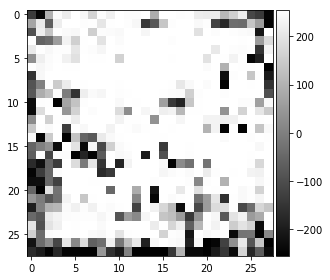

TARGET


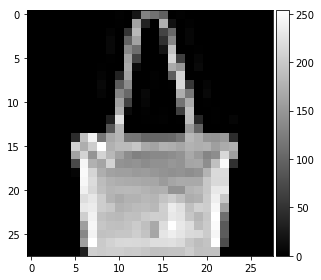

step  1000 / 1000 d_loss:  0.4448680281639099 g_loss:  0.8140783
epoch 11 progress report:
latent shape:  (1, 100)
latent:  [[0.02097028 0.67744719 0.0527215  0.05802225 0.08458343 0.62909339
  0.44988835 0.77456065 0.68045179 0.43374355 0.38505658 0.37906423
  0.15050779 0.53150297 0.42811842 0.47875419 0.46920051 0.45115612
  0.33528969 0.06675365 0.97184023 0.58514772 0.99784868 0.43693677
  0.30020753 0.58626351 0.65077001 0.37391843 0.64987995 0.61633035
  0.78264601 0.15760389 0.66655267 0.7898642  0.88147445 0.82557989
  0.43806061 0.82388992 0.10653182 0.08429739 0.64614492 0.17871666
  0.63646781 0.97501207 0.52967069 0.11231489 0.37834311 0.64750847
  0.19578794 0.31363193 0.22775562 0.27778384 0.64783323 0.87979968
  0.66714967 0.63305206 0.41583041 0.33887782 0.59550152 0.81324042
  0.45958881 0.56053432 0.83440674 0.6249205  0.26131694 0.05031747
  0.46372833 0.28473664 0.39652457 0.40337819 0.39389024 0.20746974
  0.67869523 0.56376409 0.58213126 0.67156121 0.10631095 0.2

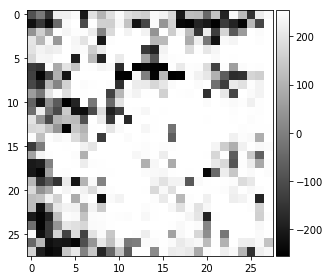

TARGET


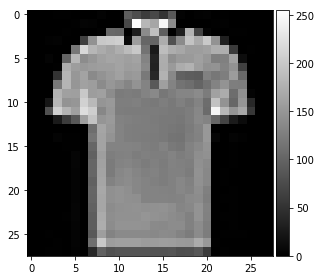

step  1000 / 1000 d_loss:  0.41927412152290344 g_loss:  0.8137834
epoch 12 progress report:
latent shape:  (1, 100)
latent:  [[0.03034168 0.65438366 0.54156058 0.1633094  0.841562   0.68599845
  0.39528777 0.82866761 0.52861323 0.25416842 0.64191472 0.05211272
  0.59211338 0.50627232 0.14729277 0.89555019 0.32123851 0.04023268
  0.23523779 0.27181747 0.14681133 0.17397426 0.71338603 0.36270421
  0.6366069  0.37520473 0.03612923 0.99672702 0.64246586 0.40390775
  0.16769659 0.40902679 0.80636317 0.12291701 0.3374529  0.60781298
  0.82941934 0.12686405 0.15917948 0.66909169 0.7070334  0.95151259
  0.74909066 0.66100583 0.89936963 0.65743841 0.63967695 0.75942523
  0.54134642 0.71766278 0.12807618 0.43578426 0.98680796 0.9876762
  0.32387835 0.70592438 0.93105581 0.32067941 0.51625925 0.01274857
  0.27111726 0.50804032 0.52426171 0.62504987 0.95925749 0.48906558
  0.15101326 0.06229941 0.28731973 0.35708161 0.86864526 0.66591884
  0.27324432 0.81969692 0.18185061 0.30993254 0.88963581 0.1

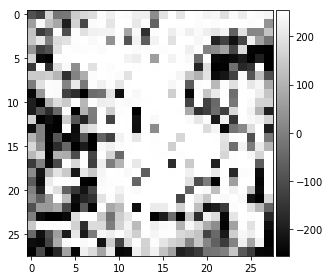

TARGET


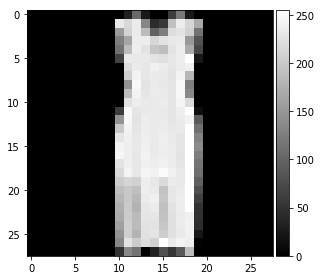

step  1000 / 1000 d_loss:  0.47982627153396606 g_loss:  0.81285185
epoch 13 progress report:
latent shape:  (1, 100)
latent:  [[0.43574297 0.6811907  0.15012571 0.06402291 0.62738664 0.85490939
  0.06574609 0.27738734 0.96134354 0.17543688 0.58950387 0.29996378
  0.95905216 0.55206137 0.4086735  0.82479093 0.54143217 0.00675541
  0.57345221 0.64041624 0.89996943 0.71123875 0.33207136 0.48462853
  0.99884893 0.62864818 0.14283181 0.37879683 0.1658964  0.38986896
  0.79657377 0.79089276 0.57939519 0.91136042 0.65999218 0.36532824
  0.27316215 0.22090438 0.46083267 0.23721273 0.4077193  0.03622406
  0.71692238 0.53196878 0.44822522 0.8515434  0.78269658 0.13069883
  0.67448401 0.70599526 0.34021401 0.80737675 0.84469054 0.1448827
  0.82053034 0.40304502 0.59779159 0.78628728 0.69119154 0.99445479
  0.84063261 0.55093667 0.80289099 0.64845848 0.16559552 0.1320657
  0.39787263 0.74102702 0.25017525 0.06346162 0.27144184 0.64224995
  0.88353206 0.64446021 0.63942681 0.69175518 0.97809196 0.9

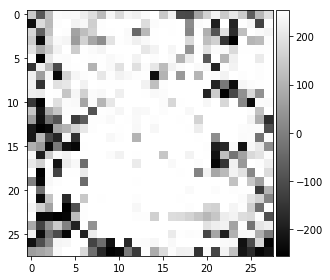

TARGET


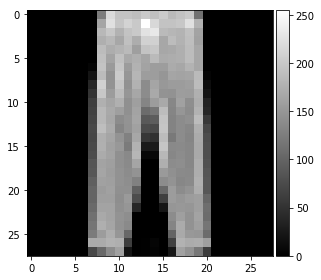

step  1000 / 1000 d_loss:  0.4422720968723297 g_loss:  0.8126262
epoch 14 progress report:
latent shape:  (1, 100)
latent:  [[0.71983368 0.35817047 0.50943724 0.15009075 0.23112859 0.05452892
  0.55753112 0.50279589 0.61090032 0.4878155  0.46732081 0.9327713
  0.85104621 0.54258996 0.37201784 0.89550258 0.30300271 0.20509977
  0.19275305 0.02984756 0.11031686 0.65819567 0.59024549 0.79704621
  0.7312965  0.1992503  0.41189315 0.55335224 0.32636701 0.43113792
  0.81284945 0.32735068 0.26799904 0.03628147 0.71658842 0.1002079
  0.79630202 0.28468153 0.15413199 0.59084713 0.76976162 0.44315641
  0.76159696 0.83412888 0.2278072  0.3339269  0.1398314  0.6040757
  0.16828689 0.22612255 0.17950923 0.91163381 0.4941209  0.85791701
  0.2054447  0.31692029 0.79710943 0.52051954 0.41919845 0.97727724
  0.21547093 0.8440131  0.45973056 0.37998014 0.30777269 0.18098794
  0.78130104 0.43480915 0.19425191 0.97819455 0.30079729 0.90081093
  0.93065825 0.89037321 0.75413017 0.43779686 0.56408741 0.6219

TARGET


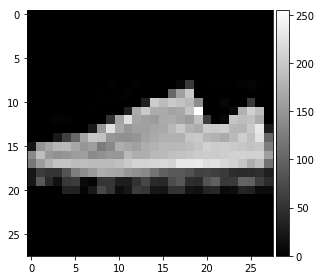

step  1000 / 1000 d_loss:  0.4178043007850647 g_loss:  0.8115399
epoch 15 progress report:
latent shape:  (1, 100)
latent:  [[0.28838006 0.44313773 0.55513574 0.89472092 0.23586886 0.00611011
  0.57172183 0.88256594 0.35615336 0.61492721 0.51338914 0.68651362
  0.33820939 0.18142213 0.86985092 0.72954923 0.65300918 0.74262975
  0.89078561 0.65842623 0.59633523 0.14596626 0.97847081 0.33009819
  0.83408617 0.18044269 0.87514956 0.81856677 0.58141861 0.63279529
  0.04438755 0.96873239 0.85772583 0.13065843 0.74634548 0.51020798
  0.32083671 0.41734507 0.21108385 0.64633785 0.51355094 0.84970084
  0.8303194  0.57958607 0.52648218 0.77427562 0.65288704 0.84529396
  0.7035037  0.29787396 0.42528732 0.54789673 0.92112468 0.45937116
  0.95593578 0.47679    0.83855945 0.41661497 0.3065181  0.10085859
  0.45171274 0.59736089 0.20811983 0.53604923 0.37000405 0.81296147
  0.91081935 0.72297152 0.54101825 0.21846504 0.50958295 0.43697786
  0.32483696 0.65365792 0.69696788 0.73160139 0.91680584 0.7

TARGET


step  1000 / 1000 d_loss:  0.4248935878276825 g_loss:  0.81116855
epoch 16 progress report:
latent shape:  (1, 100)
latent:  [[0.03535609 0.52554089 0.80004967 0.00177782 0.27636844 0.83267265
  0.15953384 0.21105287 0.4647983  0.97695333 0.5625282  0.04764586
  0.26277861 0.08394012 0.40031359 0.09111038 0.33373889 0.05165289
  0.24428576 0.9234052  0.38999893 0.91795091 0.33462227 0.26544692
  0.18882492 0.58815599 0.04083364 0.95705582 0.65329442 0.19008289
  0.95663001 0.43448622 0.96056551 0.19637347 0.20808977 0.11235974
  0.66356074 0.54641227 0.67916968 0.50406758 0.04632821 0.44442318
  0.39602318 0.13989105 0.41248977 0.69409195 0.85719449 0.38636056
  0.12991259 0.41621228 0.4884903  0.19547707 0.70210014 0.70369752
  0.24010065 0.28876591 0.34567869 0.01786621 0.36799495 0.72826895
  0.43764014 0.67677018 0.53271327 0.34072529 0.17748239 0.8575176
  0.04572933 0.21441554 0.96145955 0.15556112 0.48437982 0.60224017
  0.30399183 0.43450693 0.79003174 0.63577282 0.94149962 0.7

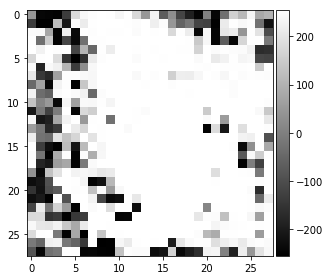

TARGET


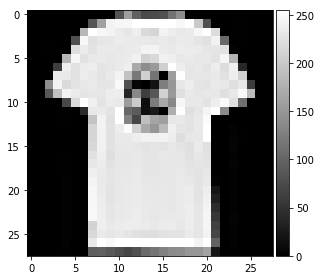

step  1000 / 1000 d_loss:  0.47571584582328796 g_loss:  0.81047434
epoch 17 progress report:
latent shape:  (1, 100)
latent:  [[0.68438029 0.63509797 0.10902047 0.03724156 0.59176404 0.53674287
  0.43676469 0.76006931 0.74873644 0.13618331 0.72347761 0.31275188
  0.12412596 0.1987977  0.32306839 0.84834159 0.2514812  0.20318593
  0.76960072 0.74706782 0.70565954 0.11026083 0.34247844 0.244749
  0.90116081 0.77337723 0.37468684 0.68349583 0.6339534  0.20182099
  0.42878109 0.12125258 0.29836055 0.2150511  0.67454568 0.53899296
  0.77063239 0.33957129 0.99270394 0.67754675 0.90086392 0.21394453
  0.27324288 0.36303215 0.82966436 0.60341601 0.29406664 0.92726236
  0.1502296  0.43149581 0.60909981 0.95408008 0.42480929 0.84423403
  0.11703013 0.00657655 0.239594   0.16973    0.83566654 0.42528816
  0.57338086 0.55423597 0.78790989 0.46572727 0.14567171 0.2008738
  0.66561988 0.49091786 0.25996874 0.66143556 0.67111123 0.8805269
  0.62663135 0.7720582  0.79359775 0.48340586 0.6896543  0.493

TARGET


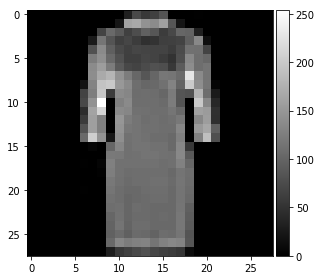

step  1000 / 1000 d_loss:  0.49148714542388916 g_loss:  0.80981994
epoch 18 progress report:
latent shape:  (1, 100)
latent:  [[0.98096084 0.79266799 0.49407377 0.71180317 0.02521817 0.66768994
  0.01738749 0.48468629 0.52482708 0.7737524  0.09378397 0.40640365
  0.89972042 0.34106137 0.82936756 0.74903316 0.91938755 0.15798891
  0.46037511 0.73443918 0.72277808 0.42065595 0.72273599 0.27616523
  0.77223943 0.47306433 0.06196298 0.39253072 0.84740541 0.30718432
  0.78640819 0.71546529 0.5832081  0.70519422 0.67140013 0.3627475
  0.3520697  0.86646431 0.08582351 0.21266954 0.06903485 0.992209
  0.44864745 0.89149096 0.0379549  0.81365238 0.81251339 0.56652875
  0.64038703 0.13016941 0.77067064 0.12100892 0.00147018 0.42860398
  0.72754469 0.5413567  0.64298638 0.25360493 0.236251   0.28720573
  0.22031767 0.85626958 0.18157771 0.5837424  0.08921388 0.82548997
  0.55495314 0.3727433  0.7905166  0.90822095 0.38588186 0.40898646
  0.03595334 0.18520044 0.1336799  0.7077329  0.35343133 0.28

TARGET


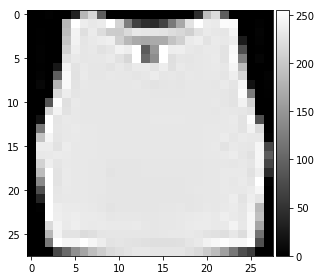

step  1000 / 1000 d_loss:  0.40627309679985046 g_loss:  0.80919933
epoch 19 progress report:
latent shape:  (1, 100)
latent:  [[0.24307506 0.40887284 0.37240635 0.60874518 0.86426916 0.13829002
  0.19131786 0.31487393 0.21838436 0.7791115  0.68834235 0.30699173
  0.89491049 0.1054546  0.55730023 0.6501623  0.47321179 0.07399595
  0.96060689 0.81683858 0.92965852 0.64144535 0.09328255 0.79330696
  0.55369841 0.95176726 0.33381956 0.29687063 0.7179212  0.36334808
  0.07650168 0.04315863 0.86488721 0.44413344 0.23871785 0.85651218
  0.78328257 0.16923461 0.32806183 0.76912022 0.59825362 0.7285918
  0.26173585 0.21656346 0.36315468 0.42739478 0.64747134 0.72561623
  0.85013769 0.43733206 0.00938661 0.90304459 0.61296929 0.72659678
  0.13628685 0.76165414 0.35023791 0.21935038 0.78676901 0.49030549
  0.30451245 0.03340833 0.26839645 0.49889512 0.19922893 0.21854056
  0.87986613 0.00812474 0.81682325 0.89917484 0.96635171 0.5472544
  0.96849952 0.12458059 0.82865033 0.65450466 0.52789337 0.4

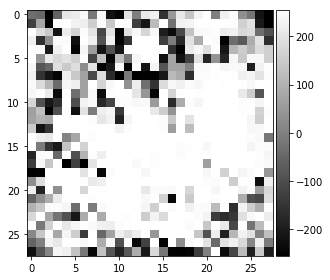

TARGET


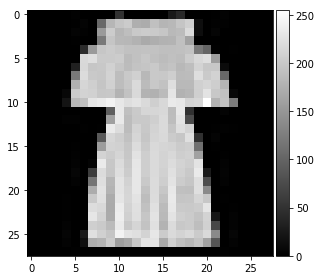

step  1000 / 1000 d_loss:  0.4746088981628418 g_loss:  0.8088412
epoch 20 progress report:
latent shape:  (1, 100)
latent:  [[0.15967494 0.19971238 0.49878823 0.08804185 0.37235223 0.56532564
  0.78640959 0.17299425 0.59707682 0.52008185 0.73695879 0.28664703
  0.07224593 0.67214801 0.44996301 0.1030609  0.91732239 0.07327194
  0.30853057 0.39649651 0.28267123 0.72413258 0.94895414 0.61698035
  0.8036575  0.57424588 0.09627837 0.05611128 0.89103654 0.8284311
  0.13098614 0.27769697 0.07102165 0.87982792 0.89799765 0.92219891
  0.26200519 0.63866533 0.09707059 0.50303513 0.30620626 0.85781547
  0.71643035 0.73897052 0.51732547 0.04733021 0.50459214 0.82906805
  0.60190488 0.62911502 0.14236459 0.17873393 0.45097921 0.69102772
  0.39350069 0.98279955 0.8155305  0.2466812  0.42602281 0.36943044
  0.91113504 0.94051983 0.17099105 0.76744135 0.17717717 0.05185094
  0.28631238 0.18135828 0.34636208 0.96746373 0.94941426 0.91351245
  0.16038736 0.80167019 0.22811754 0.25839092 0.82838845 0.01

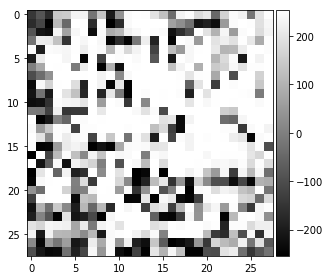

TARGET


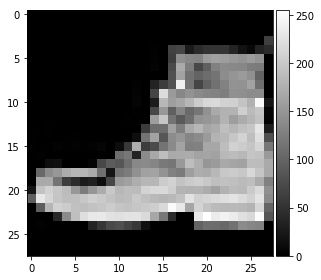

step  1000 / 1000 d_loss:  0.446769118309021 g_loss:  0.8085046
epoch 21 progress report:
latent shape:  (1, 100)
latent:  [[0.02894562 0.86333502 0.37338799 0.58527549 0.25900797 0.45700267
  0.51192715 0.03155447 0.14641647 0.64636621 0.46102543 0.45648356
  0.3232395  0.51664685 0.89201513 0.05834023 0.68672928 0.86774905
  0.7015642  0.54335576 0.06641988 0.81460202 0.86299161 0.37221248
  0.11155464 0.75482808 0.71022793 0.53268158 0.48978971 0.97456932
  0.25888151 0.97366342 0.59364059 0.58603826 0.82998227 0.74262333
  0.8498961  0.09747068 0.44987197 0.91262235 0.70490784 0.76689625
  0.77963175 0.02429541 0.88291285 0.24441914 0.1790218  0.1782771
  0.86064176 0.58417066 0.1425805  0.29525041 0.96513355 0.11330328
  0.19980102 0.88750789 0.9698113  0.87126303 0.5817797  0.49776253
  0.49260843 0.15515993 0.06928321 0.44332718 0.0389443  0.9265292
  0.69555862 0.3895329  0.93801156 0.06297206 0.0932184  0.08014177
  0.68637363 0.20010663 0.49940932 0.10205816 0.04298419 0.2179

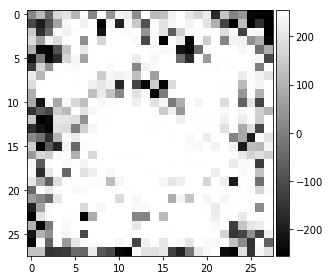

TARGET


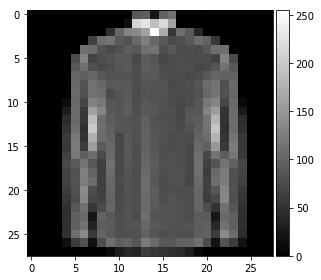

step  1000 / 1000 d_loss:  0.41489124298095703 g_loss:  0.80728614
epoch 22 progress report:
latent shape:  (1, 100)
latent:  [[0.88614445 0.88949261 0.48058353 0.75519962 0.9278065  0.72288098
  0.07824054 0.20980265 0.39294495 0.38413868 0.08860929 0.78590189
  0.59453989 0.81729872 0.87991864 0.27316107 0.10582557 0.19633913
  0.29914678 0.1705086  0.71907867 0.24244945 0.55381862 0.26530472
  0.99869563 0.13513221 0.54100757 0.85427617 0.34675935 0.1619623
  0.28308147 0.77999474 0.2887784  0.45902263 0.69288836 0.82170697
  0.58948458 0.70207342 0.38365384 0.27916889 0.8108661  0.10197542
  0.44052254 0.7620207  0.15784787 0.00246695 0.43242174 0.18892145
  0.60864291 0.38242819 0.2704733  0.69056896 0.95420778 0.16534675
  0.2173876  0.76002193 0.32623212 0.14196726 0.01681758 0.25108046
  0.89199818 0.47528453 0.14796678 0.26848162 0.08765373 0.15222924
  0.30483169 0.81074853 0.58711661 0.14354515 0.42753272 0.57167322
  0.02078161 0.22631655 0.99033569 0.38036644 0.16480681 0.

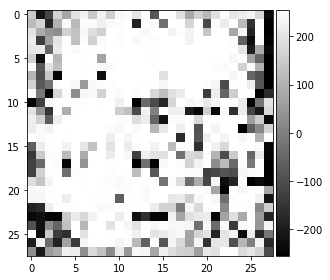

TARGET


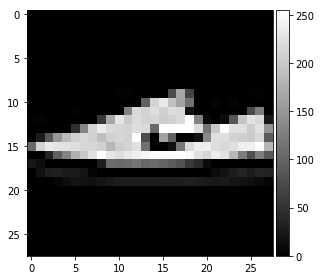

step  1000 / 1000 d_loss:  0.40983256697654724 g_loss:  0.8064389
epoch 23 progress report:
latent shape:  (1, 100)
latent:  [[0.8662939  0.40548758 0.90513452 0.75313562 0.25951237 0.55858469
  0.35621761 0.65107755 0.98978249 0.23186936 0.59448053 0.81170933
  0.86635004 0.33561759 0.08954256 0.14762662 0.70554722 0.88900153
  0.06156971 0.96481126 0.60556647 0.56208813 0.3406105  0.94118785
  0.32550697 0.25483645 0.84114763 0.5163765  0.79574387 0.8807392
  0.52494135 0.47296258 0.62660361 0.22127436 0.53147933 0.08093797
  0.54819705 0.85764117 0.62011516 0.14536911 0.03024597 0.7444929
  0.85638081 0.87351144 0.87568741 0.87776751 0.02855176 0.76028771
  0.83738755 0.29620156 0.18592502 0.60966678 0.19646667 0.53504939
  0.44068306 0.02367292 0.36720276 0.74321866 0.38917496 0.91793384
  0.71874969 0.47334861 0.7135101  0.60172508 0.78149822 0.03565175
  0.03149492 0.76496731 0.26830929 0.56600806 0.01094793 0.03540004
  0.40949212 0.50466064 0.74686109 0.80465623 0.5098326  0.11

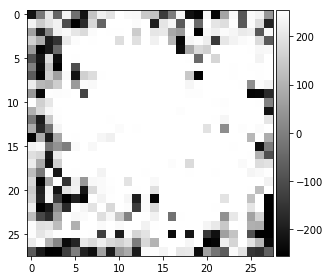

TARGET


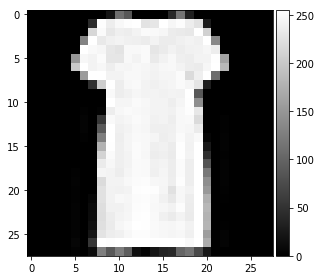

step  1000 / 1000 d_loss:  0.4610160291194916 g_loss:  0.806147
epoch 24 progress report:
latent shape:  (1, 100)
latent:  [[0.35513226 0.46528581 0.95842143 0.23549546 0.42253341 0.15777433
  0.97431531 0.84519957 0.85509515 0.9975867  0.14565865 0.63402707
  0.84621208 0.0132003  0.84741657 0.04449734 0.07765707 0.46354603
  0.91788013 0.84751983 0.7958414  0.44775453 0.8622441  0.47149168
  0.98550268 0.54350492 0.06686959 0.90712339 0.88537792 0.83666395
  0.38636781 0.55828636 0.3220504  0.85548657 0.16100337 0.56207853
  0.26310118 0.75839802 0.16397432 0.81025546 0.59026766 0.31315965
  0.50632012 0.68418151 0.29990407 0.91877654 0.10226316 0.25752351
  0.48665456 0.75356388 0.58836693 0.4101069  0.38278042 0.40496119
  0.93397493 0.84926653 0.17297317 0.11426329 0.26600603 0.62568009
  0.38425527 0.07949323 0.15295129 0.89969816 0.47057779 0.46722952
  0.29120598 0.72403177 0.40174462 0.45936154 0.74966386 0.56603743
  0.58995473 0.44056851 0.91357757 0.46968719 0.61185489 0.97

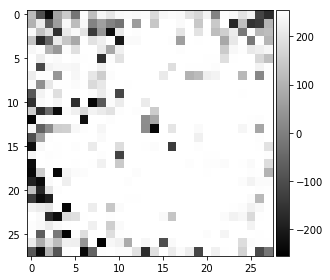

TARGET


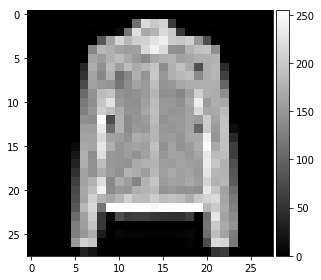

step  1000 / 1000 d_loss:  0.4031861424446106 g_loss:  0.80557215
epoch 25 progress report:
latent shape:  (1, 100)
latent:  [[0.54621992 0.28177027 0.76988245 0.40992381 0.15681744 0.09541739
  0.74490096 0.75808046 0.074543   0.29751998 0.93277874 0.69409624
  0.36441417 0.36533938 0.20360976 0.87984899 0.88470636 0.11602054
  0.89995694 0.18607721 0.73611131 0.81369337 0.93417025 0.89778039
  0.66519295 0.84658614 0.32083754 0.56273975 0.37608224 0.49044672
  0.12742009 0.39999839 0.47772162 0.50568302 0.54902394 0.48239294
  0.3852455  0.68832695 0.96651921 0.50652221 0.41892323 0.49005876
  0.54897735 0.21506264 0.97442522 0.09950169 0.46442043 0.62399356
  0.20030861 0.32349541 0.76569285 0.74519322 0.22189741 0.79954129
  0.90921402 0.54473949 0.29551862 0.6248294  0.94260329 0.42260734
  0.10255464 0.83712724 0.9960258  0.24223325 0.36707559 0.09326177
  0.12406822 0.73986909 0.75799765 0.02830347 0.50182655 0.99849081
  0.44591789 0.42461067 0.45934444 0.6620944  0.9307413  0.

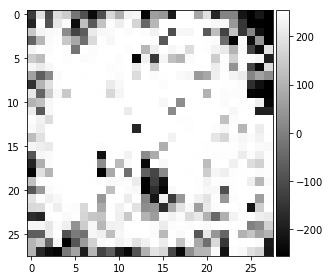

TARGET


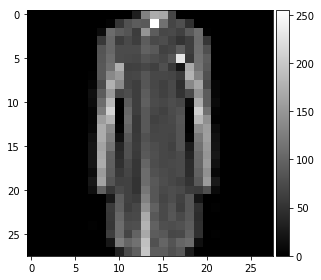

step  1000 / 1000 d_loss:  0.4240514636039734 g_loss:  0.80527365
epoch 26 progress report:
latent shape:  (1, 100)
latent:  [[0.29785031 0.67987137 0.53318507 0.9827461  0.07661994 0.86858233
  0.60360406 0.07851793 0.34089808 0.01180417 0.63452785 0.55260855
  0.9479768  0.34926099 0.6093213  0.24279028 0.89219436 0.24876098
  0.76452274 0.60553712 0.85446298 0.30870411 0.48985144 0.71759741
  0.1134954  0.98695896 0.33633132 0.70613492 0.91390306 0.66172918
  0.56398887 0.38994798 0.94756827 0.61922636 0.84899757 0.47281674
  0.70777454 0.08567887 0.27237907 0.36530178 0.73084559 0.23991871
  0.01657875 0.66058426 0.88700749 0.08007402 0.34830466 0.40440409
  0.00507792 0.51657527 0.17509143 0.59565426 0.5555656  0.50530335
  0.54104835 0.56420907 0.46875497 0.39467859 0.3443845  0.38172443
  0.86828099 0.17310222 0.68926725 0.97284445 0.51754435 0.51050143
  0.00258979 0.4922598  0.48806446 0.74311447 0.89877271 0.07714183
  0.22848555 0.39599939 0.42205424 0.28175621 0.10407188 0.

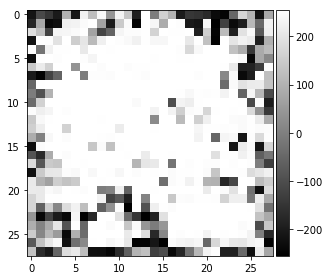

TARGET


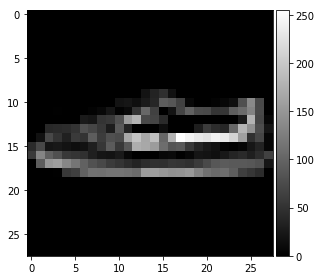

step  1000 / 1000 d_loss:  0.4465431571006775 g_loss:  0.80497354
epoch 27 progress report:
latent shape:  (1, 100)
latent:  [[0.86471828 0.08279746 0.12726008 0.04517484 0.34345693 0.59958835
  0.71912111 0.15773793 0.47161279 0.5427029  0.38540464 0.02506436
  0.44647314 0.51880208 0.68531963 0.5831644  0.29003074 0.6099382
  0.08248892 0.16802071 0.74779602 0.17453994 0.61147075 0.17805237
  0.60674022 0.39401241 0.82754852 0.00472824 0.4635971  0.18865936
  0.57882945 0.44623771 0.41005346 0.11902643 0.44954682 0.15540899
  0.42002766 0.9416949  0.45292004 0.56279654 0.56703047 0.9095686
  0.04858286 0.85567621 0.46270416 0.49992398 0.95102785 0.13183222
  0.6785572  0.96577172 0.65404084 0.55303186 0.00568786 0.96712106
  0.50884188 0.81017711 0.02873677 0.8866608  0.47827218 0.10204141
  0.68058915 0.65428679 0.53287094 0.74916018 0.03109151 0.98596475
  0.27328519 0.0869077  0.38909539 0.72285552 0.08681262 0.0566547
  0.97486106 0.77016918 0.33839523 0.40222719 0.49761686 0.751

TARGET


step  1000 / 1000 d_loss:  0.451074481010437 g_loss:  0.80467355
epoch 28 progress report:
latent shape:  (1, 100)
latent:  [[0.7946794  0.14812669 0.87588087 0.15236881 0.5573774  0.89246313
  0.09043117 0.17861347 0.77432371 0.70070539 0.946594   0.49735689
  0.19273332 0.34820243 0.50671676 0.50447084 0.7237287  0.80762914
  0.81828824 0.78069325 0.08792177 0.75283281 0.04561688 0.55000024
  0.3452628  0.08284974 0.65939014 0.41323791 0.3929609  0.88739327
  0.53557724 0.56856153 0.75323878 0.92831142 0.38167612 0.09300313
  0.27512822 0.81924756 0.1717187  0.43036933 0.33181408 0.59718154
  0.87675449 0.37306675 0.87773198 0.62980306 0.74432026 0.91420163
  0.52916078 0.75823208 0.38267134 0.40863    0.77005801 0.28729771
  0.88093035 0.08687013 0.17607662 0.93544239 0.48188915 0.87560531
  0.67358268 0.35781529 0.94014412 0.77532468 0.51848046 0.25520115
  0.4173889  0.59076746 0.60759985 0.29790532 0.90310344 0.97231962
  0.97701345 0.31611286 0.0984231  0.96961151 0.28769582 0.8

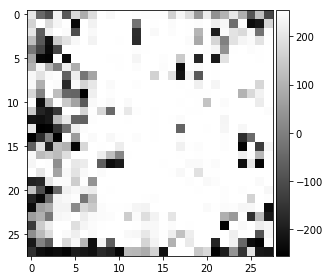

TARGET


step  1000 / 1000 d_loss:  0.4441567659378052 g_loss:  0.8041277
epoch 29 progress report:
latent shape:  (1, 100)
latent:  [[0.90921421 0.21927255 0.79091626 0.27806775 0.23311962 0.67831139
  0.34353817 0.56678218 0.91398304 0.47305858 0.13882982 0.46024914
  0.00484642 0.19942457 0.59069259 0.65986113 0.16858694 0.54188568
  0.7112281  0.78457217 0.13462115 0.73724674 0.28008747 0.81614844
  0.03621196 0.25236944 0.79739908 0.20778653 0.93022435 0.10244684
  0.20258642 0.20955275 0.69968547 0.45769693 0.24064805 0.0270957
  0.52320226 0.46980474 0.43444317 0.78543667 0.54052797 0.55592717
  0.56322966 0.41547337 0.18719418 0.61873557 0.91263959 0.22255244
  0.64929972 0.91856424 0.87122438 0.59013127 0.0383999  0.08446828
  0.18936574 0.49646859 0.53541893 0.54219139 0.06283419 0.28186382
  0.6261898  0.51347476 0.34471714 0.44027044 0.67537246 0.98092778
  0.04662984 0.75642676 0.52613011 0.34144359 0.22466688 0.97493027
  0.41669476 0.40830275 0.52991641 0.79600419 0.46302718 0.87

TARGET


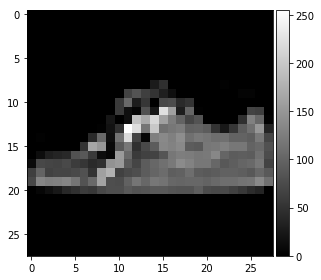

step  1000 / 1000 d_loss:  0.4020806550979614 g_loss:  0.8030875
epoch 30 progress report:
latent shape:  (1, 100)
latent:  [[0.96856061 0.66089711 0.73878076 0.93087299 0.43903927 0.82393465
  0.75101203 0.07431002 0.61230224 0.83363387 0.35242003 0.87562489
  0.53932293 0.35757124 0.14697512 0.51765018 0.8254668  0.92684626
  0.41979495 0.61305024 0.05604467 0.87344652 0.49352207 0.26724914
  0.63180484 0.4436665  0.91281085 0.04789165 0.23370466 0.42633639
  0.50822695 0.60937609 0.68553074 0.28729528 0.59610585 0.54978763
  0.94051948 0.10419412 0.44023256 0.91368189 0.08189814 0.87129723
  0.67295512 0.36581121 0.25747158 0.33691629 0.45310736 0.54513546
  0.83161983 0.0998282  0.11437927 0.85996989 0.24751007 0.50131758
  0.0626825  0.82717608 0.17234515 0.64472583 0.92488685 0.15266304
  0.86301015 0.3700486  0.43426006 0.27906562 0.52531127 0.16038612
  0.793612   0.27890774 0.00674522 0.05469058 0.84525267 0.37453306
  0.12441117 0.94200943 0.55505271 0.50424136 0.52670229 0.0

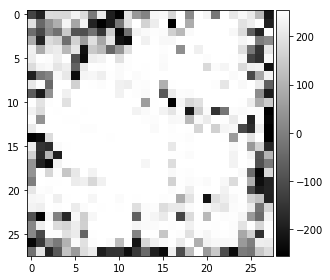

TARGET


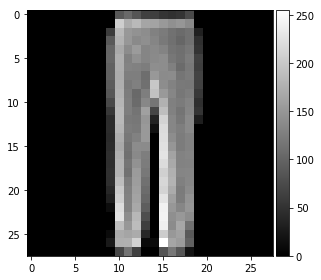

step  1000 / 1000 d_loss:  0.40581196546554565 g_loss:  0.8025227
epoch 31 progress report:
latent shape:  (1, 100)
latent:  [[0.56288786 0.41621703 0.20699548 0.4308699  0.9110816  0.01441237
  0.276305   0.39008972 0.25589441 0.81426048 0.48928694 0.70594776
  0.73240466 0.9507642  0.41551855 0.92698835 0.81127908 0.30380816
  0.41663443 0.89255615 0.99364489 0.23908478 0.64321465 0.69288316
  0.45474392 0.15242727 0.24794204 0.10002552 0.02623919 0.90108421
  0.96093602 0.61364079 0.26340788 0.09596519 0.66789478 0.17777187
  0.23505219 0.62906422 0.90416323 0.56833094 0.77090035 0.44274985
  0.97774709 0.64459525 0.4095192  0.89830625 0.08713105 0.58807873
  0.85421681 0.17052348 0.06551824 0.01037299 0.85445045 0.00625879
  0.70591066 0.66464887 0.37263477 0.50736138 0.93137513 0.31263167
  0.2206201  0.32240155 0.34734777 0.44019203 0.03915293 0.62970957
  0.1610549  0.82153215 0.17495518 0.53195248 0.76526788 0.7836524
  0.22491028 0.45857647 0.21423595 0.3611212  0.57315179 0.2

TARGET


step  1000 / 1000 d_loss:  0.40437889099121094 g_loss:  0.8022211
epoch 32 progress report:
latent shape:  (1, 100)
latent:  [[0.35945401 0.0495194  0.03620505 0.3231034  0.8948472  0.8106202
  0.71688282 0.83347033 0.90176681 0.73159835 0.69487071 0.64650412
  0.75802848 0.65577076 0.89811342 0.74025247 0.65439391 0.4154704
  0.83904721 0.46838941 0.6063554  0.86583072 0.05043921 0.99758761
  0.95372997 0.0208262  0.79378359 0.91529021 0.88851974 0.84877783
  0.07178493 0.44183231 0.9924873  0.26384408 0.02138112 0.67184809
  0.94445005 0.89723992 0.41330049 0.7455071  0.07267299 0.269296
  0.19608732 0.95110018 0.15423959 0.91903748 0.68330631 0.52943923
  0.01654117 0.06907084 0.54010939 0.54185777 0.0569228  0.95989743
  0.67510999 0.14577278 0.3023187  0.14671387 0.71065614 0.43857288
  0.04782712 0.49843041 0.58224623 0.96685322 0.67739759 0.63447005
  0.35183409 0.2039653  0.62796814 0.34534348 0.1970113  0.95704977
  0.00331551 0.10070512 0.52356235 0.98299797 0.73147496 0.6520

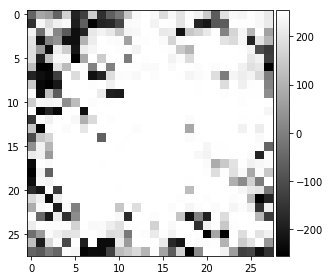

TARGET


step  1000 / 1000 d_loss:  0.40450337529182434 g_loss:  0.80190563
epoch 33 progress report:
latent shape:  (1, 100)
latent:  [[0.0711653  0.27235266 0.07947357 0.78780785 0.86660521 0.91147789
  0.08694967 0.22590705 0.96166886 0.18785607 0.22475871 0.55733013
  0.69583775 0.48725179 0.70317759 0.5146859  0.22546651 0.95240833
  0.82970718 0.69473101 0.56374335 0.90457357 0.91419333 0.18913194
  0.1755022  0.37581203 0.41025321 0.8263114  0.24940582 0.79909477
  0.11576893 0.27831077 0.98265488 0.89862136 0.83538056 0.46598986
  0.56277121 0.69169318 0.70397646 0.60605095 0.63483029 0.08761751
  0.31711895 0.67562977 0.42679187 0.38257737 0.15332754 0.52715998
  0.51476283 0.12940955 0.86066983 0.60671756 0.10578259 0.62993413
  0.47171914 0.95516577 0.43154162 0.76402307 0.46098685 0.40605097
  0.86039362 0.45701618 0.02497257 0.17473098 0.97101652 0.868336
  0.05838278 0.78848012 0.81138344 0.46800083 0.04912249 0.24231534
  0.51243559 0.53458774 0.14771923 0.75910848 0.48969884 0.6

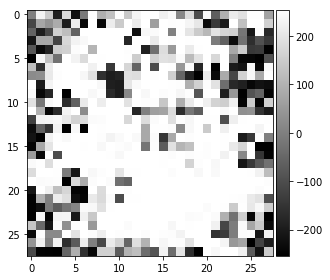

TARGET


step  1000 / 1000 d_loss:  0.4497864842414856 g_loss:  0.801589
epoch 34 progress report:
latent shape:  (1, 100)
latent:  [[2.87555060e-01 9.99399979e-01 7.71445667e-01 8.38924635e-01
  2.93264001e-01 5.04117593e-01 6.12120032e-01 2.68417689e-01
  2.49476750e-01 8.46494079e-03 3.97926295e-01 4.14007202e-02
  9.96576725e-01 8.36558407e-01 8.23713106e-01 2.25170021e-01
  8.10259059e-01 9.46838534e-01 9.79398341e-01 2.22100242e-01
  8.21340457e-01 2.20563926e-01 8.27893312e-01 4.29760828e-01
  9.37975206e-01 1.01055385e-01 4.84299261e-01 7.27246113e-01
  5.39229122e-01 1.20805708e-04 4.46368754e-01 2.10079873e-01
  7.83981172e-01 5.24561545e-01 3.12282315e-01 1.06427560e-01
  9.79707597e-01 3.36575645e-01 7.81112249e-01 2.85139285e-01
  4.78476652e-01 6.88301107e-01 8.63766191e-01 5.36719504e-01
  3.75620178e-01 3.34860076e-01 3.33889306e-01 9.29028504e-01
  6.98613993e-01 9.26293040e-03 6.71249349e-01 3.49252960e-01
  5.00512026e-01 5.59410248e-01 9.76689548e-01 2.07595349e-01
  3.63840

TARGET


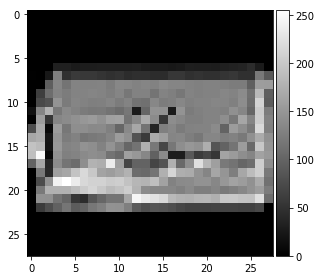

step  1000 / 1000 d_loss:  0.4040309190750122 g_loss:  0.8012701
epoch 35 progress report:
latent shape:  (1, 100)
latent:  [[0.41065483 0.6260054  0.89029543 0.77868128 0.34231469 0.68707718
  0.31456089 0.31764928 0.53321492 0.36120567 0.45941618 0.1638924
  0.48732    0.63932741 0.50848303 0.61361788 0.5212833  0.67941432
  0.65254616 0.20506213 0.35815409 0.64161947 0.22368509 0.2900445
  0.64724215 0.74680448 0.23780475 0.55248115 0.11284534 0.81039393
  0.72753029 0.20926746 0.9683587  0.63807281 0.60072222 0.37537635
  0.89077302 0.57934365 0.45762369 0.85227831 0.98184899 0.91492127
  0.53794214 0.27723097 0.63747624 0.06371195 0.27828429 0.37298378
  0.22180274 0.5592153  0.01623409 0.41215572 0.12249166 0.72653671
  0.16817959 0.89170731 0.85613803 0.74384997 0.39994466 0.61610228
  0.69398724 0.84069664 0.92677884 0.51952607 0.56405914 0.45949941
  0.11446067 0.40516499 0.02698054 0.71689686 0.30551033 0.53076662
  0.81309051 0.49972119 0.84549318 0.85115198 0.70525507 0.346

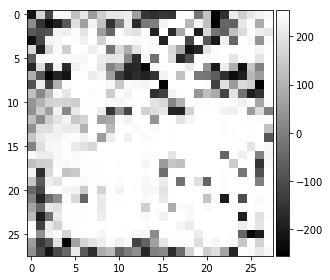

TARGET


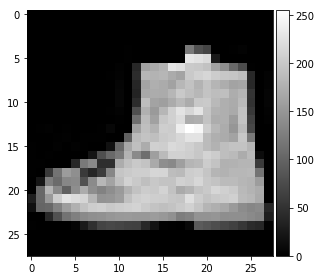

step  1000 / 1000 d_loss:  0.4011107385158539 g_loss:  0.80094254
epoch 36 progress report:
latent shape:  (1, 100)
latent:  [[0.38150372 0.49322671 0.51905394 0.61214386 0.9276107  0.76744018
  0.32103071 0.31450631 0.58348383 0.75668579 0.7064492  0.26669886
  0.8895152  0.46603495 0.01943091 0.78035879 0.58291052 0.60846257
  0.30378638 0.04289405 0.49630266 0.22795689 0.00124705 0.53929683
  0.23659747 0.21644468 0.75168928 0.28242923 0.6627031  0.45909605
  0.18340223 0.03345743 0.18233716 0.13377708 0.84760671 0.00224034
  0.267179   0.93636872 0.71624994 0.03142294 0.30903614 0.45238025
  0.81518285 0.54093645 0.76328663 0.60214838 0.77121745 0.55751324
  0.41732294 0.54287056 0.84117286 0.54105675 0.68084048 0.72923304
  0.59563761 0.34860543 0.5784755  0.0085842  0.16279938 0.61513299
  0.91177761 0.84972025 0.83236914 0.61281507 0.02241827 0.13874578
  0.40367029 0.05846347 0.70658614 0.37357681 0.97530013 0.84803278
  0.05421937 0.48804873 0.2011968  0.57456051 0.2582124  0.

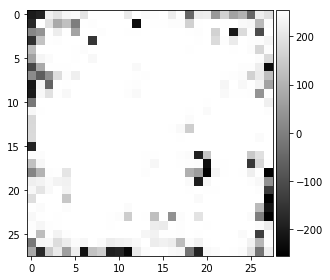

TARGET


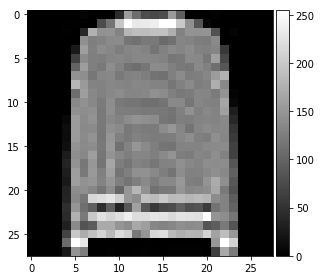

step  1000 / 1000 d_loss:  0.4137457609176636 g_loss:  0.80060863
epoch 37 progress report:
latent shape:  (1, 100)
latent:  [[0.80662888 0.71968421 0.63783544 0.54080141 0.75164206 0.58664146
  0.04174389 0.08156091 0.38270684 0.92945125 0.1694023  0.36880957
  0.43960354 0.33137678 0.15179451 0.21424547 0.51631871 0.19524277
  0.11046221 0.8644326  0.93882738 0.84428282 0.81977376 0.26687645
  0.64835704 0.79390512 0.85011574 0.37152976 0.84259769 0.70612423
  0.31253665 0.94229471 0.13758161 0.78744954 0.36468704 0.62251175
  0.89807532 0.42934485 0.32182522 0.14112725 0.07507043 0.19356373
  0.63730203 0.99128751 0.471744   0.53818727 0.52347439 0.40479638
  0.17627989 0.66073219 0.87747932 0.30230075 0.69959253 0.79312224
  0.30210501 0.87109589 0.98022716 0.01787556 0.07523823 0.58178233
  0.50313445 0.30904194 0.50602374 0.79269755 0.23376821 0.74615725
  0.50452841 0.36253379 0.1941778  0.25750847 0.93586201 0.82102906
  0.27292175 0.26854777 0.02613849 0.35043887 0.78369229 0.

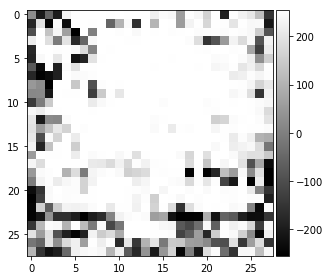

TARGET


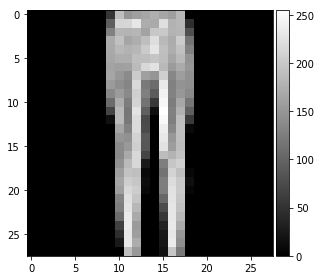

step  1000 / 1000 d_loss:  0.46750783920288086 g_loss:  0.799716
epoch 38 progress report:
latent shape:  (1, 100)
latent:  [[0.79577779 0.37677695 0.4407181  0.9517618  0.78325245 0.21822532
  0.84849456 0.79060402 0.11843847 0.14670988 0.40450486 0.42053335
  0.87658145 0.14745625 0.88488176 0.83656925 0.01704977 0.55653241
  0.96500806 0.20351808 0.14392443 0.41687768 0.75908668 0.54954218
  0.78440105 0.8825736  0.55770135 0.86464446 0.94437662 0.44872828
  0.27988118 0.77689154 0.76482658 0.27234543 0.88061096 0.20900647
  0.15528244 0.94326366 0.83181253 0.98321771 0.23393877 0.7812363
  0.43433061 0.77535241 0.64832976 0.89998932 0.39736891 0.55737867
  0.7237915  0.62590428 0.19235132 0.9916849  0.45827084 0.21638251
  0.83262487 0.88973459 0.99441714 0.7540913  0.96865455 0.25642893
  0.82142842 0.76910648 0.9294671  0.43839592 0.64832671 0.63597507
  0.81155743 0.34824558 0.34842388 0.61745845 0.40222442 0.7283494
  0.97904709 0.97997294 0.74339262 0.19239624 0.48782263 0.579

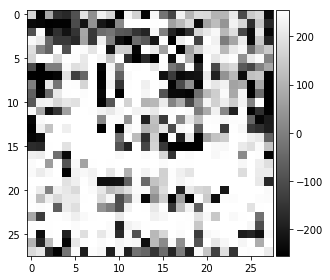

TARGET


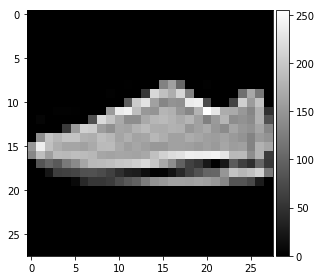

step  1000 / 1000 d_loss:  0.4114360213279724 g_loss:  0.7988373
epoch 39 progress report:
latent shape:  (1, 100)
latent:  [[0.81285774 0.06391942 0.13252971 0.09852624 0.33317965 0.66057405
  0.71951684 0.07141793 0.18708942 0.658671   0.75179311 0.90009589
  0.69137735 0.07910539 0.00726601 0.44203173 0.65744697 0.60490499
  0.79242814 0.18445678 0.5220231  0.87762253 0.12501007 0.72417161
  0.98735619 0.05129836 0.28734666 0.1628984  0.64060124 0.46570531
  0.23170445 0.75159106 0.97413146 0.20779199 0.02406514 0.59838695
  0.06248008 0.6615197  0.25240769 0.01464822 0.53165403 0.49473817
  0.81177278 0.93485632 0.01988826 0.79144564 0.60913642 0.81607389
  0.27781863 0.89299527 0.76587814 0.06484056 0.08093922 0.67488255
  0.17851747 0.25945896 0.00341404 0.70458343 0.17652185 0.95940448
  0.88865665 0.94616071 0.54780702 0.60485496 0.18637149 0.19402419
  0.08715427 0.84128014 0.05570624 0.3528956  0.42836154 0.12185254
  0.2648418  0.71143966 0.75335677 0.05642103 0.29540833 0.9

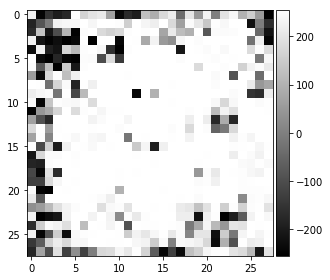

TARGET


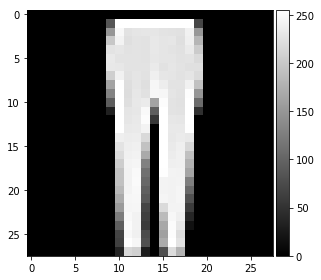

step  1000 / 1000 d_loss:  0.4554797112941742 g_loss:  0.7985252
epoch 40 progress report:
latent shape:  (1, 100)
latent:  [[0.78206505 0.56642335 0.44589605 0.06612722 0.31709938 0.94709341
  0.41474764 0.59047821 0.84986378 0.66919812 0.2377141  0.93550235
  0.87880859 0.68022988 0.1740654  0.42213815 0.69449798 0.69825725
  0.89232779 0.00414311 0.53516112 0.70843377 0.70618336 0.35916463
  0.65023574 0.19285478 0.59639701 0.15136182 0.22938426 0.45809617
  0.12227889 0.51578253 0.56227508 0.23662193 0.41544166 0.49266055
  0.01395756 0.91549154 0.32528705 0.90637042 0.02040787 0.91939584
  0.02734153 0.568791   0.76240339 0.70003729 0.34802262 0.45016072
  0.70467289 0.63281166 0.83592493 0.924587   0.45683657 0.70638152
  0.03714803 0.80957377 0.62078336 0.01687497 0.70785848 0.47494372
  0.92318849 0.8683606  0.19978286 0.02871596 0.72659433 0.16082096
  0.45901099 0.49106622 0.351974   0.48680877 0.99923799 0.00178626
  0.92658352 0.99474947 0.69066087 0.78874912 0.55409252 0.8

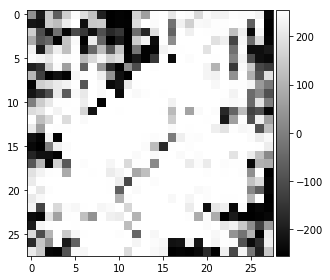

TARGET


step  1000 / 1000 d_loss:  0.39912307262420654 g_loss:  0.79803723
epoch 41 progress report:
latent shape:  (1, 100)
latent:  [[0.80016584 0.99265995 0.48708795 0.5860978  0.9299277  0.67267415
  0.61409893 0.31895996 0.02289834 0.95031027 0.86985102 0.05750735
  0.13220595 0.22331722 0.41349709 0.55687699 0.12816128 0.0501822
  0.40959391 0.49290299 0.06865921 0.94309881 0.65650436 0.40525377
  0.99878899 0.23198242 0.09400037 0.12859667 0.65832992 0.18073875
  0.10862548 0.14265389 0.24202219 0.55594525 0.56142478 0.75873789
  0.61517322 0.67745894 0.33300232 0.30394001 0.82333287 0.89465471
  0.82498834 0.19618564 0.00762827 0.72462858 0.16820851 0.36990094
  0.66670788 0.78002112 0.49324289 0.14733763 0.30428227 0.53671112
  0.2252826  0.24989797 0.33308898 0.29504254 0.77125523 0.41456105
  0.9426342  0.78184818 0.88287408 0.06908248 0.14195696 0.11151093
  0.73781069 0.62430661 0.93657447 0.33264755 0.89382418 0.09575444
  0.73216975 0.05626334 0.89021848 0.71898903 0.67236639 0.

TARGET


step  1000 / 1000 d_loss:  0.40425845980644226 g_loss:  0.797529
epoch 42 progress report:
latent shape:  (1, 100)
latent:  [[0.50913316 0.48048313 0.73615115 0.98940092 0.40089176 0.10277693
  0.79845018 0.55763722 0.14292092 0.37122249 0.80681027 0.92406323
  0.23873527 0.3920367  0.51237304 0.21934463 0.41253943 0.18451458
  0.13223987 0.04215963 0.5303277  0.27086903 0.95441718 0.70466402
  0.78348809 0.5540323  0.69055015 0.71886154 0.44115834 0.85519842
  0.48036115 0.18306477 0.44342967 0.45683206 0.43014569 0.90894415
  0.66804299 0.5730435  0.00152603 0.94721282 0.62102314 0.6802672
  0.50476513 0.18108726 0.65472787 0.30515777 0.66345355 0.32970189
  0.90378494 0.39873749 0.36980486 0.68595787 0.41234431 0.52918321
  0.60219552 0.09467797 0.38229376 0.46142595 0.51702251 0.98643803
  0.33100564 0.91425802 0.46320567 0.67694069 0.1645919  0.78486068
  0.38333925 0.1720575  0.95648359 0.96733687 0.94231506 0.7110275
  0.63788956 0.42553844 0.25465342 0.53031931 0.78755495 0.777

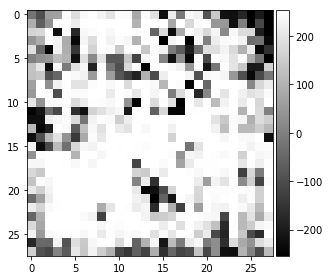

TARGET


step  1000 / 1000 d_loss:  0.41417354345321655 g_loss:  0.7971911
epoch 43 progress report:
latent shape:  (1, 100)
latent:  [[0.92017688 0.59962145 0.91075796 0.94484375 0.63234307 0.54380756
  0.29593011 0.15972485 0.68791168 0.84188368 0.37307515 0.77496717
  0.57936761 0.85964514 0.93295267 0.30933731 0.67142407 0.86923832
  0.62705989 0.47526214 0.4124773  0.85969506 0.76159591 0.10956736
  0.74170357 0.6101304  0.99090152 0.71377185 0.70075475 0.68041214
  0.63660807 0.65670079 0.55288291 0.27935495 0.55514388 0.10052278
  0.38767645 0.15405309 0.85699623 0.02679465 0.04963258 0.29065458
  0.44886477 0.11576704 0.60949572 0.84564132 0.64415177 0.82370998
  0.29028315 0.03995787 0.90867914 0.94131065 0.17621266 0.57960874
  0.23600811 0.31303085 0.88791589 0.55035928 0.07163678 0.55869262
  0.65914853 0.21399644 0.60960527 0.28420958 0.4155004  0.43453888
  0.51143731 0.3385054  0.61290306 0.40203391 0.42772891 0.47433675
  0.20022013 0.71902118 0.77186207 0.90169352 0.52759973 0.

TARGET


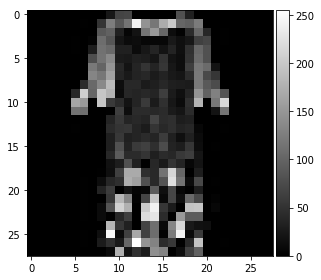

step  1000 / 1000 d_loss:  0.40673205256462097 g_loss:  0.79657376
epoch 44 progress report:
latent shape:  (1, 100)
latent:  [[0.53415108 0.23715619 0.24263073 0.94868687 0.88752997 0.86305569
  0.1716726  0.04862618 0.59443749 0.09963254 0.66156798 0.82972377
  0.96273446 0.09130655 0.95129009 0.80617132 0.47751104 0.8374928
  0.116402   0.03226393 0.38456634 0.79708632 0.240886   0.49498143
  0.86091296 0.00326086 0.52378247 0.88903603 0.21188241 0.79354186
  0.97232904 0.72448204 0.7015217  0.53584945 0.11945083 0.76422759
  0.32825321 0.83718754 0.14756284 0.5492021  0.6989013  0.64281552
  0.82527171 0.10309717 0.02134391 0.65044587 0.33417043 0.29327228
  0.20701567 0.53542916 0.91015742 0.96781878 0.20279605 0.5181129
  0.53532343 0.83230491 0.77511801 0.74916183 0.72443545 0.04010942
  0.58588016 0.64445905 0.60525849 0.60352678 0.92850301 0.26099093
  0.48706952 0.96090882 0.45772754 0.77167458 0.41174467 0.67158218
  0.0451023  0.2465815  0.98690396 0.34693367 0.81288751 0.7

TARGET


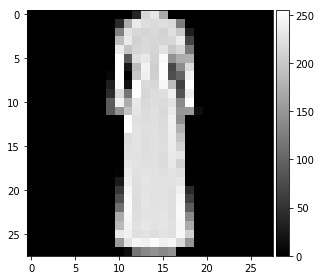

step  1000 / 1000 d_loss:  0.40459203720092773 g_loss:  0.79626524
epoch 45 progress report:
latent shape:  (1, 100)
latent:  [[0.9442268  0.23992478 0.12633692 0.02744583 0.14777946 0.3074719
  0.40215176 0.09073808 0.84668307 0.70729539 0.42614601 0.3501594
  0.01179393 0.29687072 0.77340574 0.91642912 0.27849057 0.39813661
  0.56358545 0.3037567  0.07643916 0.38229479 0.39888901 0.1386695
  0.39461153 0.31492095 0.85571174 0.65894432 0.76209225 0.70669765
  0.94985562 0.3155008  0.21300085 0.0027631  0.2938776  0.79004438
  0.92303465 0.56528589 0.59440688 0.32587633 0.79487066 0.09516156
  0.89471122 0.17833844 0.18925926 0.94856778 0.23492865 0.25650583
  0.26010122 0.08940038 0.67178403 0.96507348 0.35400082 0.42916065
  0.67149362 0.29179565 0.07128864 0.80243116 0.14035392 0.62831767
  0.86669559 0.02091547 0.28318126 0.19596002 0.33084249 0.88825137
  0.82009602 0.48146515 0.77620505 0.31239557 0.32009812 0.50390564
  0.51481791 0.91633248 0.07262392 0.13278917 0.97409295 0.46

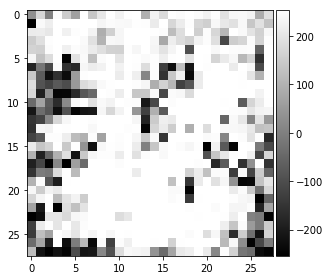

TARGET


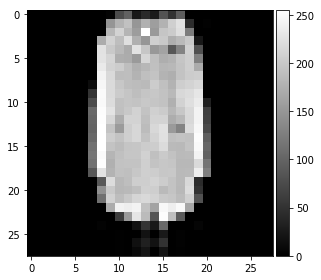

step  1000 / 1000 d_loss:  0.3984311819076538 g_loss:  0.7957016
epoch 46 progress report:
latent shape:  (1, 100)
latent:  [[0.41161305 0.03298523 0.42060023 0.17927117 0.89855114 0.88827714
  0.92143811 0.19625448 0.74180299 0.59435752 0.3523145  0.51780358
  0.401765   0.55235726 0.04352781 0.27457348 0.20412637 0.95265498
  0.37497981 0.14801717 0.74158424 0.68476813 0.65969943 0.46925313
  0.10193336 0.91962499 0.65899944 0.51701873 0.01031452 0.63771623
  0.38031545 0.10782397 0.3325874  0.58893276 0.85057697 0.32709765
  0.52297049 0.02024887 0.05683231 0.27166299 0.99803138 0.71487444
  0.45660902 0.98910219 0.71352875 0.88222645 0.70455516 0.79716955
  0.90886722 0.16987375 0.85606696 0.99185316 0.44746766 0.76535808
  0.63134311 0.61844745 0.5740343  0.55769832 0.00617376 0.79931986
  0.70577727 0.96473256 0.18980228 0.06785645 0.4562693  0.58335883
  0.78953192 0.49390447 0.89990698 0.4142945  0.9670095  0.58752405
  0.03243808 0.00419132 0.08749661 0.72139664 0.01185685 0.4

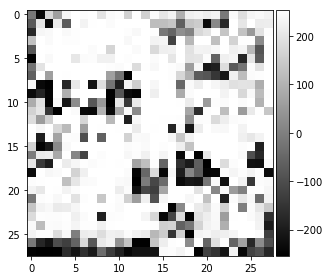

TARGET


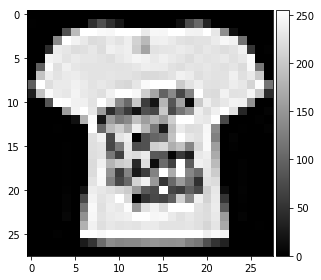

step  1000 / 1000 d_loss:  0.4003833830356598 g_loss:  0.7954063
epoch 47 progress report:
latent shape:  (1, 100)
latent:  [[0.23218802 0.73230447 0.01826583 0.46702634 0.38570347 0.99479531
  0.34359531 0.39601863 0.19631592 0.07347376 0.08643906 0.13081476
  0.19016886 0.23436231 0.42850979 0.98406452 0.98338767 0.53964175
  0.67089644 0.36019819 0.1939839  0.12811521 0.72885417 0.06896205
  0.9370789  0.78211976 0.53724698 0.45650949 0.42105718 0.37248248
  0.45039922 0.23824554 0.17615143 0.78176299 0.85045687 0.98724123
  0.96084593 0.70822735 0.65473355 0.74200771 0.69990712 0.12201622
  0.30978539 0.8090192  0.54001488 0.02606284 0.10956689 0.02996913
  0.7986585  0.90433107 0.0537737  0.20762468 0.99668289 0.66911989
  0.85911768 0.29552513 0.49569728 0.42444592 0.43185704 0.64087288
  0.7848014  0.42724405 0.76083499 0.50507542 0.6786908  0.09756846
  0.22785338 0.34939511 0.92837975 0.67570495 0.09915346 0.89586616
  0.38854081 0.16747742 0.46068531 0.06020779 0.40746861 0.7

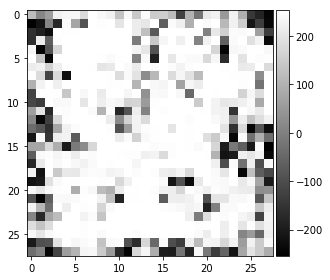

TARGET


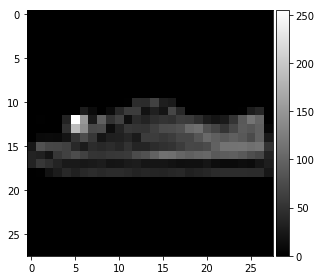

step  1000 / 1000 d_loss:  0.3979119658470154 g_loss:  0.7951003
epoch 48 progress report:
latent shape:  (1, 100)
latent:  [[0.9729468  0.93208228 0.85643768 0.28691079 0.22509551 0.4478218
  0.22244204 0.67425103 0.86653937 0.65285429 0.56301676 0.69110891
  0.02107689 0.55539673 0.8372681  0.62054831 0.80567875 0.71392087
  0.53328972 0.7416173  0.42835874 0.59278439 0.19220281 0.7599234
  0.10397973 0.59107141 0.49332827 0.50696898 0.05997616 0.20967168
  0.68423819 0.59430199 0.53534777 0.68616962 0.86542404 0.53752843
  0.0684617  0.39989454 0.31638211 0.0392928  0.5107184  0.15289207
  0.98684122 0.43558167 0.55524859 0.75323916 0.46411016 0.31292305
  0.96524472 0.35943237 0.97092057 0.8074119  0.96939993 0.39104493
  0.48548787 0.08606126 0.38828164 0.46174083 0.70230328 0.82074809
  0.86548998 0.58227087 0.12937682 0.97376022 0.25753302 0.16041955
  0.54115459 0.80260539 0.26212583 0.923037   0.48473343 0.61405208
  0.24374837 0.20498865 0.74741847 0.38522704 0.90722837 0.275

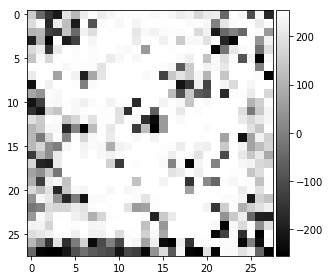

TARGET


step  1000 / 1000 d_loss:  0.40302038192749023 g_loss:  0.7947843
epoch 49 progress report:
latent shape:  (1, 100)
latent:  [[0.20678219 0.54928786 0.80101287 0.42748237 0.84632124 0.93100861
  0.87219405 0.11606398 0.32656101 0.16922228 0.45886816 0.92016757
  0.75906901 0.49286033 0.10439528 0.71724997 0.19758333 0.43727935
  0.17091548 0.59015958 0.54911254 0.11163806 0.45709382 0.54758638
  0.8287107  0.94331737 0.27286771 0.01576322 0.82771877 0.76890598
  0.3226938  0.0067274  0.51396468 0.7779168  0.04725876 0.26650923
  0.96791027 0.58101458 0.07602988 0.75748176 0.45877068 0.08119339
  0.23973844 0.37666404 0.35119866 0.97298396 0.03011676 0.97289427
  0.90618335 0.11267727 0.70457764 0.33624553 0.51717878 0.09613629
  0.91573797 0.96434238 0.60306326 0.7460749  0.15532538 0.08341945
  0.90936832 0.46596602 0.12703397 0.04382971 0.14001961 0.41155901
  0.40664987 0.50483509 0.14654353 0.11344726 0.17136319 0.98792621
  0.7761114  0.02513502 0.86073761 0.40400064 0.07425581 0.

TARGET


step  1000 / 1000 d_loss:  0.4047066271305084 g_loss:  0.7944587
epoch 50 progress report:
latent shape:  (1, 100)
latent:  [[0.14733092 0.94724199 0.87017556 0.65561199 0.17950532 0.70072705
  0.99594512 0.79390892 0.38289843 0.16475372 0.28045878 0.68833302
  0.88225864 0.34465255 0.19331115 0.36379549 0.3132135  0.16517722
  0.03917573 0.76908008 0.95410175 0.41055157 0.49563862 0.68491561
  0.36034011 0.24012082 0.57371132 0.85932155 0.62707077 0.91681234
  0.87385028 0.65058815 0.83492121 0.85019571 0.12227033 0.88509138
  0.46048352 0.17917994 0.25395004 0.66560295 0.70552397 0.9896363
  0.59543777 0.73841798 0.53196894 0.02280887 0.29562017 0.57187196
  0.84044058 0.0965082  0.55943669 0.81763292 0.10708557 0.08314652
  0.35174808 0.42607194 0.65978229 0.92864185 0.39986576 0.86139589
  0.76527133 0.23459442 0.21913117 0.21864553 0.09736555 0.56872111
  0.96246489 0.88255008 0.46332359 0.28822949 0.44800661 0.17320318
  0.7609579  0.75132892 0.73052628 0.49036923 0.0179956  0.80

TARGET


step  1000 / 1000 d_loss:  0.3973987102508545 g_loss:  0.7941285
epoch 51 progress report:
latent shape:  (1, 100)
latent:  [[0.33652499 0.94128235 0.01712615 0.72724023 0.23835698 0.87895927
  0.33907102 0.36667135 0.68965331 0.46910342 0.60975833 0.41035176
  0.7873417  0.00865837 0.69820648 0.62587468 0.37688506 0.63123987
  0.44874043 0.62222396 0.12353259 0.09804252 0.29176535 0.35000656
  0.00207415 0.9343709  0.92370038 0.67904006 0.83433678 0.21279912
  0.48165954 0.47139025 0.77986579 0.03562989 0.05543133 0.87982704
  0.94235808 0.31087135 0.7654292  0.95511379 0.78276014 0.86343277
  0.61240102 0.5275123  0.76280195 0.70800691 0.23456856 0.79190588
  0.69815339 0.71113272 0.13841663 0.48610589 0.74957353 0.87509293
  0.16679618 0.50176333 0.02214303 0.14389477 0.32019623 0.04036086
  0.36191616 0.24866206 0.4038299  0.39694593 0.32558899 0.31995075
  0.41714617 0.59239203 0.36055878 0.05052364 0.37024855 0.9948354
  0.90385886 0.5914546  0.99338752 0.16540854 0.96080482 0.47

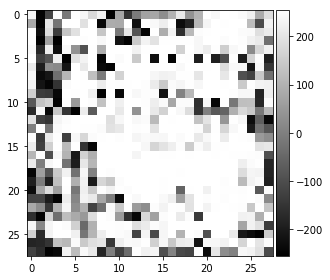

TARGET


step  1000 / 1000 d_loss:  0.40096455812454224 g_loss:  0.79380983
epoch 52 progress report:
latent shape:  (1, 100)
latent:  [[0.45784738 0.57778091 0.30731105 0.54590515 0.17956342 0.53106022
  0.36993362 0.99970266 0.6253067  0.61008217 0.19680306 0.85131649
  0.67073209 0.14278587 0.87394141 0.64906509 0.44661494 0.44391379
  0.60863733 0.79840419 0.4318228  0.85409112 0.38704187 0.99761583
  0.10281345 0.81164807 0.02600879 0.17213726 0.88138038 0.55934873
  0.12619407 0.49177561 0.40609555 0.70892229 0.4139043  0.79601271
  0.43565094 0.50539901 0.84293228 0.99780592 0.98362221 0.94021154
  0.92343873 0.99017821 0.09178493 0.90269745 0.47787084 0.38765582
  0.92509319 0.28211445 0.68004656 0.84433618 0.83821159 0.48392469
  0.18975881 0.85283453 0.99881981 0.09077315 0.12650239 0.00541377
  0.38230078 0.01095781 0.30332996 0.24768955 0.99488315 0.53165033
  0.46612489 0.87204707 0.69578871 0.79131154 0.27898157 0.33442981
  0.51558949 0.35429248 0.41474418 0.03994597 0.63677148 0

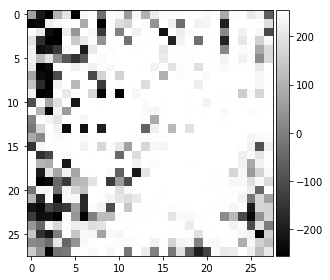

TARGET


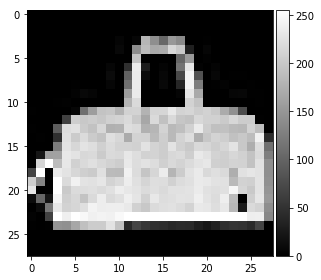

step  1000 / 1000 d_loss:  0.3972919285297394 g_loss:  0.79315287
epoch 53 progress report:
latent shape:  (1, 100)
latent:  [[0.30450033 0.11190451 0.88675106 0.07366071 0.52350651 0.64092462
  0.96627114 0.45979732 0.66805767 0.71698791 0.50324726 0.3597086
  0.98890033 0.99052864 0.24343179 0.03250372 0.19274184 0.09526265
  0.32204982 0.34458856 0.59776582 0.61772183 0.27244236 0.90814909
  0.7798814  0.2731524  0.66105283 0.06303612 0.55063858 0.76391551
  0.20972044 0.17534187 0.17592012 0.03567695 0.55762805 0.52411026
  0.35927834 0.23243921 0.97982186 0.03383438 0.01354568 0.4253331
  0.52066275 0.63115174 0.90797485 0.87762352 0.36250082 0.8857899
  0.83918005 0.11511802 0.94227592 0.10752328 0.89348527 0.63428901
  0.32008985 0.52021446 0.6510376  0.62423762 0.31644231 0.42629977
  0.13610785 0.94301018 0.30409708 0.95521079 0.65198546 0.45773295
  0.72594832 0.14207762 0.21548524 0.11965094 0.01893375 0.31239141
  0.96907512 0.42611292 0.10793205 0.40966574 0.66385939 0.980

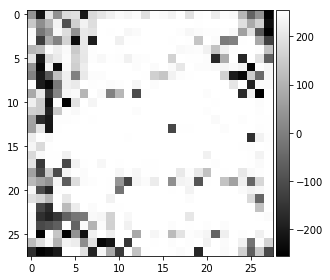

TARGET


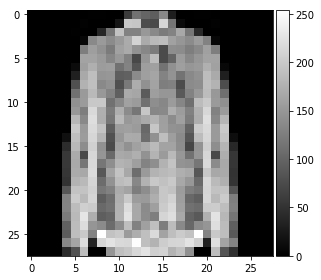

step  1000 / 1000 d_loss:  0.39864975214004517 g_loss:  0.7919837
epoch 54 progress report:
latent shape:  (1, 100)
latent:  [[0.05395543 0.67488558 0.64509922 0.3933717  0.09923468 0.30076191
  0.84352193 0.57724956 0.096538   0.34722414 0.95859465 0.19483129
  0.81994416 0.27528969 0.74872799 0.5173482  0.31410152 0.36750486
  0.51430333 0.87758105 0.74703486 0.36420592 0.94591557 0.49128326
  0.5737192  0.54463518 0.5589705  0.6064304  0.47030574 0.0435044
  0.01409313 0.88489234 0.93861862 0.93249027 0.28505666 0.38733377
  0.14284837 0.42558443 0.59610283 0.71135326 0.08265105 0.21093231
  0.40699822 0.22187149 0.06962266 0.11685397 0.58279319 0.66847454
  0.61514534 0.79544482 0.39595513 0.20785122 0.21324707 0.31146957
  0.21981343 0.6311672  0.39319392 0.1449267  0.91604165 0.39759988
  0.69107974 0.24076444 0.30815828 0.63018511 0.06207692 0.41150103
  0.61048575 0.62407817 0.10443439 0.73359228 0.52200687 0.55327153
  0.37608447 0.93929607 0.09871932 0.99118589 0.12760605 0.2

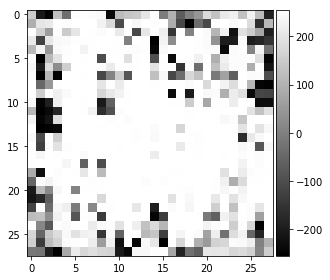

TARGET


step  1000 / 1000 d_loss:  0.43484535813331604 g_loss:  0.79123944
epoch 55 progress report:
latent shape:  (1, 100)
latent:  [[1.01338862e-01 7.44408990e-01 7.66282532e-01 2.03958732e-01
  8.33734752e-01 3.00247078e-01 6.23684593e-01 9.04060101e-02
  2.22726741e-01 3.26200117e-01 2.51612384e-01 1.42884202e-01
  5.36461951e-01 2.08162403e-01 1.89589996e-01 2.34159495e-01
  7.26629914e-01 4.30368654e-01 9.23817185e-01 4.28704359e-02
  2.49171772e-01 1.67716383e-01 3.47413911e-01 9.72011252e-01
  4.03166519e-01 7.78119229e-01 2.81218960e-01 9.48869424e-01
  6.22781414e-01 2.56998618e-01 2.45781176e-01 3.98437734e-01
  4.14182961e-01 8.86220941e-01 5.48190235e-01 8.53594275e-01
  9.75047889e-01 2.95876230e-01 2.83105845e-01 9.53774653e-01
  5.85859200e-01 6.35875170e-01 8.90177570e-01 7.47283734e-01
  1.89834309e-01 8.98043138e-01 5.89304224e-01 1.17509356e-01
  8.97779335e-01 8.07433513e-01 3.02574531e-01 2.35488230e-01
  1.18596979e-01 1.23626867e-01 8.53627145e-01 9.30204196e-02
  7.48

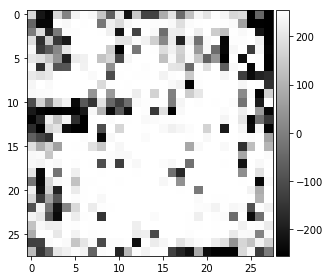

TARGET


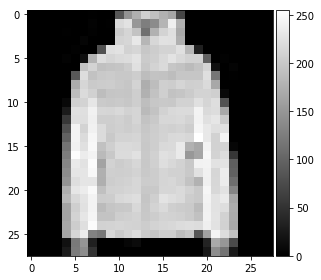

step  1000 / 1000 d_loss:  0.47406935691833496 g_loss:  0.79099256
epoch 56 progress report:
latent shape:  (1, 100)
latent:  [[0.37808609 0.15118291 0.35927569 0.28251959 0.18818256 0.73892703
  0.56610825 0.693167   0.37629948 0.97869538 0.05818465 0.42221348
  0.94354318 0.43537525 0.07195291 0.15605427 0.39432432 0.72042411
  0.58051156 0.62067879 0.35602366 0.87842589 0.97850359 0.90602513
  0.68114    0.36373895 0.46480392 0.39094962 0.22090836 0.99467095
  0.79199951 0.01436278 0.92350618 0.46996852 0.6683992  0.57034572
  0.92004415 0.83325282 0.3487537  0.54561478 0.35642923 0.33932838
  0.99547532 0.19100744 0.53371027 0.90045846 0.50647188 0.60993815
  0.33408609 0.41297915 0.3088527  0.80249352 0.50314817 0.25028804
  0.71248485 0.02916692 0.78099165 0.22767186 0.43139143 0.99651892
  0.87837522 0.38643991 0.120133   0.28092259 0.01281704 0.99910509
  0.10671121 0.94341136 0.89973263 0.23435321 0.79096628 0.8182461
  0.43895325 0.84755284 0.12353983 0.16477723 0.86351423 0.

TARGET


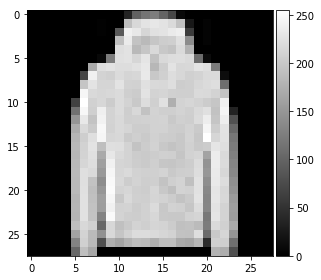

step  1000 / 1000 d_loss:  0.45313188433647156 g_loss:  0.7901484
epoch 57 progress report:
latent shape:  (1, 100)
latent:  [[4.40505245e-01 7.29550106e-01 4.13145098e-01 8.53868479e-01
  4.20027452e-01 9.94480442e-03 3.42827638e-03 9.85416790e-01
  6.10912146e-01 4.69346816e-01 5.60052680e-01 7.64343985e-01
  8.57372857e-02 6.89805529e-02 9.29774603e-01 1.91487586e-01
  6.77035614e-01 4.53476353e-04 8.61462150e-01 7.37531185e-01
  5.82271138e-01 9.16113891e-01 8.16970644e-01 6.73709571e-01
  1.46078928e-01 7.38884174e-01 6.25227423e-01 5.75969595e-01
  8.40261561e-01 2.92636947e-01 2.32584472e-01 3.76046678e-01
  1.60531048e-02 2.14747474e-01 2.08710404e-01 2.89273332e-01
  6.06710162e-01 2.80941400e-01 7.44272302e-01 7.08055015e-01
  5.77672390e-01 1.64893937e-01 3.63497484e-01 3.61333575e-01
  9.74730841e-01 2.98840172e-02 2.51992564e-01 6.72550280e-01
  8.22714381e-01 1.69793553e-01 2.26948504e-01 3.72746429e-01
  7.32934876e-01 5.18012676e-01 4.91586380e-01 5.88895060e-01
  3.626

TARGET


step  1000 / 1000 d_loss:  0.4498573839664459 g_loss:  0.78991544
epoch 58 progress report:
latent shape:  (1, 100)
latent:  [[0.35280722 0.94654678 0.49053312 0.72961835 0.80290745 0.08060939
  0.58946759 0.70143841 0.90275436 0.99199172 0.58160189 0.63101767
  0.11337507 0.18098293 0.64690733 0.65222284 0.820322   0.43865784
  0.01750801 0.17535929 0.36163796 0.08341064 0.02939339 0.42374812
  0.86788253 0.17636525 0.25233962 0.70625227 0.85985614 0.62828373
  0.74186448 0.07447493 0.54200209 0.02871323 0.46840902 0.3153971
  0.85510213 0.72060841 0.27495432 0.37178543 0.25685937 0.11142361
  0.94478142 0.0070885  0.62036458 0.78489901 0.84189131 0.34480458
  0.13797534 0.999724   0.8747204  0.31364286 0.91447917 0.44462594
  0.86331484 0.1460039  0.77295259 0.42930546 0.74319243 0.82285864
  0.83584837 0.77819655 0.68559118 0.40009466 0.07921227 0.84686977
  0.11135405 0.58030019 0.42139373 0.09330586 0.04761591 0.92898809
  0.46335131 0.53219718 0.60471579 0.62632672 0.26183515 0.4

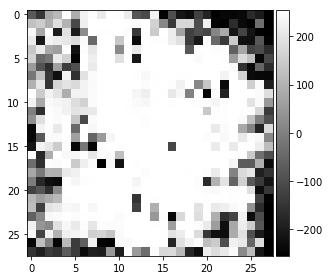

TARGET


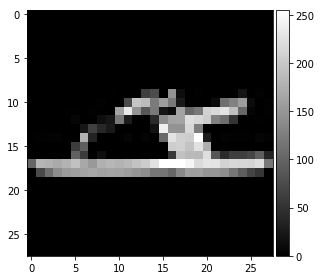

step  1000 / 1000 d_loss:  0.3955364525318146 g_loss:  0.7896583
epoch 59 progress report:
latent shape:  (1, 100)
latent:  [[0.46554094 0.24847728 0.95507947 0.73411767 0.75514556 0.11336199
  0.14426106 0.95439368 0.24222383 0.31808646 0.36648973 0.93638589
  0.27860204 0.07598662 0.59784269 0.30493681 0.67648164 0.99384321
  0.95367422 0.85952717 0.93861184 0.27321661 0.13678262 0.5051891
  0.22825725 0.44092911 0.03592848 0.10418735 0.8211895  0.98273357
  0.78342274 0.07256055 0.16845907 0.95260515 0.59157146 0.44145902
  0.31995433 0.46565278 0.09521815 0.41582399 0.9572777  0.73079779
  0.56293021 0.67289358 0.77176415 0.60517611 0.12239718 0.75671807
  0.43508576 0.41282759 0.95291438 0.00644055 0.38654188 0.69511839
  0.85273595 0.18320609 0.39054604 0.08173126 0.65626775 0.89962643
  0.07013451 0.78092804 0.78183924 0.89102146 0.73857926 0.68752068
  0.58432993 0.21687171 0.29693027 0.21621767 0.46618918 0.77284367
  0.75402859 0.26282661 0.0540815  0.87651734 0.95290298 0.28

TARGET


step  1000 / 1000 d_loss:  0.3969113230705261 g_loss:  0.7893811
epoch 60 progress report:
latent shape:  (1, 100)
latent:  [[0.84254875 0.26841947 0.20568502 0.15906017 0.84114401 0.78100299
  0.70077297 0.25163383 0.67916708 0.29305566 0.02900419 0.81143448
  0.69639904 0.55936413 0.15316005 0.21511625 0.07180915 0.25350698
  0.65445807 0.99541656 0.62841832 0.17273133 0.64855224 0.13510055
  0.22636541 0.25905902 0.20249711 0.31431676 0.7503518  0.05900531
  0.76292361 0.26766571 0.5042644  0.53865359 0.18907349 0.23447266
  0.72977151 0.97158577 0.99327979 0.69434068 0.48411823 0.47993294
  0.25727847 0.10810111 0.08548242 0.49828816 0.65905903 0.21523363
  0.09229591 0.14909604 0.30837331 0.27767553 0.7052355  0.07104865
  0.54844348 0.75678725 0.10406785 0.37913167 0.74466899 0.53961689
  0.21602414 0.21033525 0.0976533  0.49039433 0.28726062 0.35859461
  0.15639025 0.69404909 0.08443652 0.91931719 0.42765204 0.59653921
  0.7129008  0.66777378 0.70023553 0.53865732 0.07560664 0.3

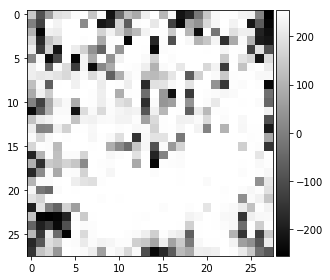

TARGET


step  1000 / 1000 d_loss:  0.4051674008369446 g_loss:  0.78886914
epoch 61 progress report:
latent shape:  (1, 100)
latent:  [[0.32521436 0.24678589 0.34306365 0.03823267 0.25237021 0.31430195
  0.00299602 0.83462497 0.95303041 0.71870743 0.07801382 0.40696349
  0.02478564 0.59529161 0.00871242 0.38431183 0.59028895 0.88772219
  0.18976842 0.43778596 0.71817072 0.74153505 0.17172442 0.52740136
  0.55613373 0.53690812 0.51503323 0.93687631 0.83835955 0.80240436
  0.3191399  0.33650178 0.20667375 0.14492647 0.86132866 0.51310338
  0.59234482 0.432236   0.56473029 0.5788862  0.85387831 0.57333307
  0.85722133 0.64017665 0.5532681  0.27423864 0.77233442 0.4131988
  0.09598955 0.77573383 0.13378819 0.67959422 0.58922931 0.54124783
  0.43648289 0.0366419  0.92289933 0.74185382 0.99615939 0.93102733
  0.58169738 0.9927059  0.79984966 0.42342863 0.54262883 0.84960749
  0.84164674 0.85040203 0.85143347 0.0070665  0.65548004 0.38625166
  0.11617493 0.89627048 0.72707251 0.88630909 0.96770882 0.9

TARGET


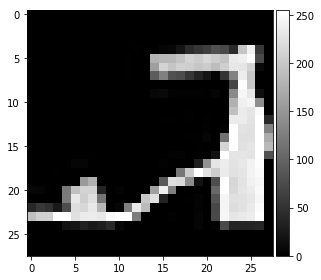

step  1000 / 1000 d_loss:  0.4243867099285126 g_loss:  0.7886062
epoch 62 progress report:
latent shape:  (1, 100)
latent:  [[0.92592882 0.51867998 0.35804436 0.75459285 0.42522309 0.1562666
  0.22123952 0.30436164 0.55383601 0.17574405 0.79555736 0.29009372
  0.36631692 0.31479761 0.65827726 0.65964947 0.42796906 0.31489298
  0.91913803 0.89404532 0.32740549 0.92802806 0.21884109 0.47147163
  0.50913924 0.55482998 0.12827711 0.20124812 0.32276563 0.57202727
  0.24065073 0.94075954 0.09535674 0.96907344 0.14502775 0.16085502
  0.99475822 0.86125515 0.65804047 0.55569833 0.01204699 0.18836156
  0.18453981 0.64094614 0.82386028 0.69862248 0.12018365 0.94072243
  0.57341859 0.90693284 0.60715086 0.48273987 0.16172381 0.64316186
  0.15834979 0.08610445 0.46607375 0.69761599 0.0372843  0.36559264
  0.87821202 0.59086632 0.64686027 0.72970788 0.82259463 0.05349097
  0.04935612 0.47215191 0.971463   0.97817124 0.53198922 0.39653848
  0.07886457 0.81908606 0.48112961 0.07596371 0.92144897 0.61

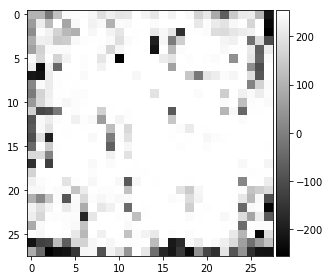

TARGET


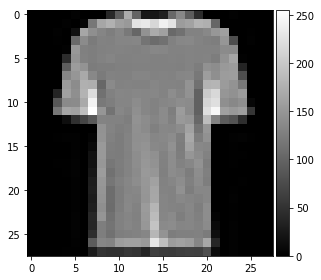

step  1000 / 1000 d_loss:  0.4330136775970459 g_loss:  0.78810906
epoch 63 progress report:
latent shape:  (1, 100)
latent:  [[0.67739822 0.48897955 0.14621728 0.3232264  0.08861042 0.03831094
  0.52615274 0.96369936 0.78477769 0.86575839 0.47140524 0.44394274
  0.37134148 0.91509639 0.44117156 0.39455605 0.96700519 0.02241796
  0.31220706 0.1112221  0.80987507 0.98864024 0.06258325 0.99299673
  0.85544167 0.5441998  0.48019325 0.82414467 0.62245929 0.36482455
  0.74455215 0.41039001 0.16984394 0.90250355 0.40486904 0.57063605
  0.63314071 0.91066717 0.38470907 0.14737714 0.71493029 0.30998403
  0.88476653 0.26481616 0.14290868 0.33126139 0.21330907 0.67971698
  0.16473859 0.23079341 0.10087158 0.83810086 0.19291455 0.75188782
  0.07919034 0.23450987 0.85030992 0.84964534 0.98237386 0.70776101
  0.1791065  0.23119239 0.66515126 0.29224623 0.08925624 0.20253782
  0.07220004 0.80794453 0.39778934 0.03168913 0.07994618 0.7590643
  0.85409937 0.80453445 0.29656398 0.08737272 0.90014525 0.8

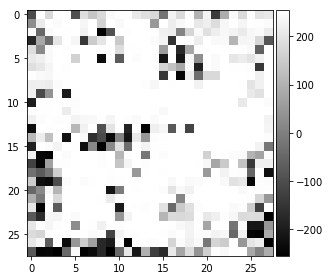

TARGET


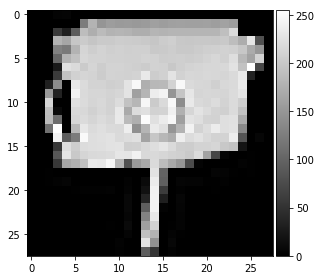

step  1000 / 1000 d_loss:  0.43990933895111084 g_loss:  0.7878574
epoch 64 progress report:
latent shape:  (1, 100)
latent:  [[0.51317267 0.07654076 0.60303359 0.49102068 0.322453   0.36761497
  0.96171976 0.61398642 0.28209625 0.99496324 0.74501354 0.94624383
  0.11737415 0.0954387  0.89889564 0.75423483 0.3904247  0.8406879
  0.67744589 0.52588303 0.35442115 0.96168169 0.6385961  0.8020072
  0.14280053 0.57506063 0.12262953 0.99951104 0.44953905 0.37669531
  0.34923965 0.0758174  0.30317025 0.27457818 0.50518665 0.20658751
  0.30706662 0.49078011 0.99496672 0.41797646 0.89268435 0.14979759
  0.16577282 0.11986468 0.45914747 0.75755682 0.56599784 0.84543442
  0.01557465 0.10714026 0.31831334 0.08481813 0.23279509 0.76459198
  0.14900086 0.20376065 0.76592423 0.63508992 0.74781831 0.16583876
  0.14499228 0.57927297 0.28672431 0.78013165 0.54994689 0.43789868
  0.9821063  0.82019744 0.57362903 0.73428259 0.35155802 0.42867242
  0.05143867 0.09344931 0.95872939 0.92994988 0.68812339 0.07

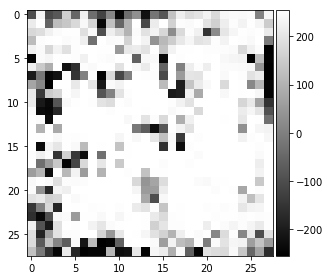

TARGET


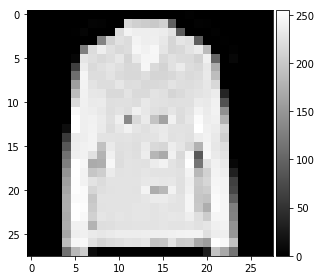

step  1000 / 1000 d_loss:  0.398853063583374 g_loss:  0.7873201
epoch 65 progress report:
latent shape:  (1, 100)
latent:  [[0.78687079 0.3388367  0.29786034 0.54514312 0.89077898 0.9158645
  0.14626918 0.60334967 0.08789855 0.80022035 0.86636971 0.32359036
  0.33409186 0.09459259 0.40976897 0.49840378 0.77785464 0.92164871
  0.17247117 0.0299154  0.84390628 0.4631876  0.27962173 0.38699721
  0.7045856  0.45260542 0.9115498  0.02776373 0.00193773 0.245624
  0.52841144 0.80391486 0.00889822 0.55793054 0.16696081 0.5083652
  0.5963059  0.83280976 0.88595828 0.80489596 0.48825316 0.09036855
  0.85692896 0.0866791  0.89298026 0.52949101 0.75278631 0.44201039
  0.82794837 0.70102427 0.68115506 0.93940819 0.51601328 0.03268934
  0.30102021 0.74955176 0.20454666 0.26179471 0.80495184 0.2857004
  0.74838252 0.04210538 0.48107281 0.95933773 0.28013599 0.67562163
  0.73793456 0.80038197 0.66732571 0.98495952 0.45893953 0.13440607
  0.36254995 0.08700095 0.21753486 0.9448855  0.33193287 0.5599858

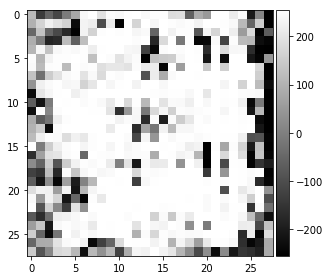

TARGET


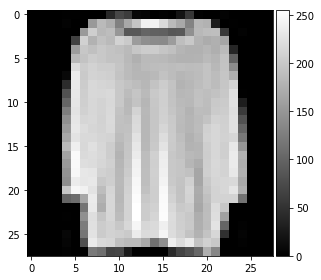

step  1000 / 1000 d_loss:  0.40864211320877075 g_loss:  0.78703594
epoch 66 progress report:
latent shape:  (1, 100)
latent:  [[0.14107997 0.30629499 0.50712541 0.19176569 0.91297474 0.28819273
  0.21009862 0.57299614 0.38856957 0.84990957 0.70138371 0.17473731
  0.69740953 0.81126801 0.16085403 0.89273056 0.58348811 0.61014492
  0.86320086 0.88156362 0.04498134 0.55944318 0.29408544 0.56037217
  0.42795173 0.80768167 0.87706747 0.37642794 0.03672313 0.88118702
  0.66738501 0.36785765 0.86874621 0.78593526 0.41682549 0.01574907
  0.39089274 0.4273259  0.02917327 0.25982968 0.0145105  0.0090906
  0.83559222 0.79633205 0.67903507 0.184369   0.2574124  0.2355212
  0.19712329 0.91705745 0.89401114 0.57764073 0.9395277  0.03160466
  0.76682049 0.04027483 0.61814827 0.90856036 0.16809819 0.17689371
  0.61286038 0.23476068 0.17586014 0.44459062 0.73508645 0.01554711
  0.23049482 0.38074358 0.46575279 0.44329195 0.98286464 0.50213294
  0.78251648 0.91060244 0.38574966 0.03311397 0.69177906 0.7

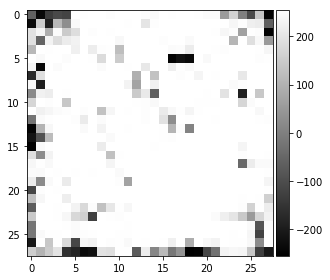

TARGET


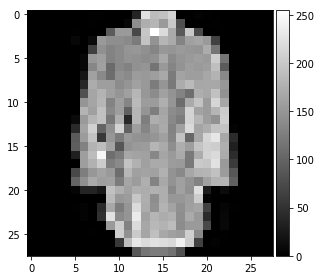

step  1000 / 1000 d_loss:  0.42172864079475403 g_loss:  0.78674185
epoch 67 progress report:
latent shape:  (1, 100)
latent:  [[0.15450098 0.6069214  0.89841361 0.72473432 0.20138556 0.33499904
  0.56711827 0.46688351 0.20599187 0.70286506 0.51976081 0.22058237
  0.85904292 0.30297781 0.3016204  0.63789603 0.93682494 0.65121109
  0.80184178 0.65574582 0.26492324 0.40057999 0.95388577 0.31104704
  0.23220472 0.93229475 0.79274854 0.99155408 0.8763987  0.4940695
  0.17303564 0.54000439 0.18139904 0.33608626 0.69124386 0.05417431
  0.82276801 0.70121755 0.34629303 0.59362144 0.26166949 0.20040774
  0.94629036 0.32212195 0.70998239 0.31547747 0.58273917 0.10179593
  0.59839633 0.88001576 0.50328981 0.21861339 0.25914609 0.44877807
  0.32764798 0.02866648 0.79962062 0.88838958 0.25080531 0.99640842
  0.8066146  0.10400599 0.06230836 0.08493449 0.42771916 0.4490338
  0.1671058  0.66360258 0.97405453 0.77838695 0.97353991 0.42645211
  0.34390675 0.32347202 0.35435258 0.90209988 0.77471025 0.2

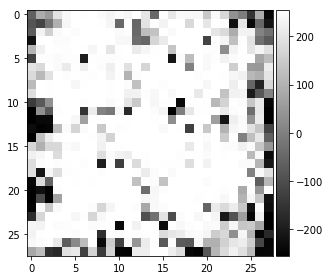

TARGET


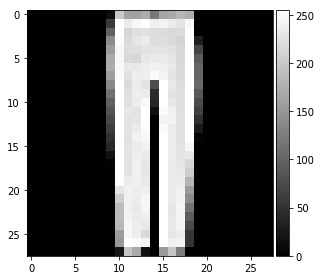

step  1000 / 1000 d_loss:  0.39331549406051636 g_loss:  0.78616035
epoch 68 progress report:
latent shape:  (1, 100)
latent:  [[0.68751692 0.73108985 0.44019352 0.48541407 0.76477828 0.04650243
  0.88918749 0.79654534 0.24421526 0.74889648 0.40453988 0.3706179
  0.69705962 0.84606135 0.0770111  0.19781873 0.49222688 0.84516997
  0.45802819 0.96757388 0.48906356 0.95579355 0.81506436 0.35223659
  0.25029719 0.37924057 0.68606041 0.160626   0.98119673 0.45358594
  0.68190508 0.72044101 0.4337174  0.77118181 0.03479268 0.75219296
  0.83415392 0.66066784 0.8046954  0.54826516 0.21391534 0.47343538
  0.46626355 0.81221705 0.86602997 0.96362742 0.41010374 0.72584018
  0.97610869 0.97093011 0.33251714 0.20101852 0.67542832 0.47790833
  0.7621032  0.49539798 0.43945367 0.31565092 0.8924745  0.01822949
  0.34438134 0.92477394 0.30547797 0.29009222 0.64466969 0.67034976
  0.03424999 0.54383992 0.40725484 0.96564053 0.52167564 0.81882354
  0.20259986 0.33858508 0.79125643 0.47963911 0.6870976  0.

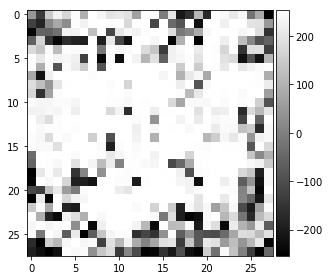

TARGET


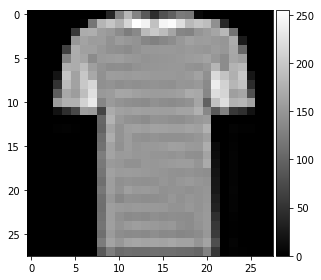

step  1000 / 1000 d_loss:  0.480112761259079 g_loss:  0.78587276
epoch 69 progress report:
latent shape:  (1, 100)
latent:  [[0.95180966 0.09672562 0.53214464 0.47888285 0.24422416 0.24038257
  0.60312742 0.69879495 0.91548668 0.31764724 0.64396013 0.06050872
  0.82028677 0.84369674 0.14231888 0.84955446 0.11948045 0.42575347
  0.59316003 0.65588771 0.80404677 0.89946323 0.29629893 0.98998919
  0.16030704 0.5606338  0.04685703 0.00501868 0.6585955  0.20913761
  0.00274545 0.18936525 0.3220684  0.07687692 0.24490626 0.6568513
  0.57314271 0.80748418 0.37998767 0.38531502 0.24318468 0.0359271
  0.39546393 0.26788083 0.41504263 0.80130759 0.40533112 0.46520441
  0.29977613 0.88474198 0.85457231 0.17624077 0.47478912 0.84664397
  0.49399824 0.70692731 0.68735733 0.97954826 0.88792009 0.77156963
  0.13926108 0.79679962 0.89799105 0.98183845 0.04343763 0.28364731
  0.06773764 0.17535344 0.71464627 0.97279958 0.57769776 0.13397149
  0.15696169 0.82680717 0.36811516 0.52126963 0.92017423 0.907

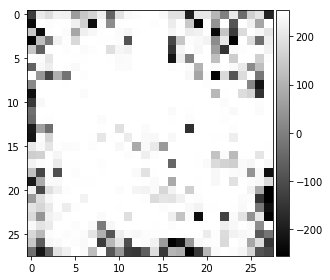

TARGET


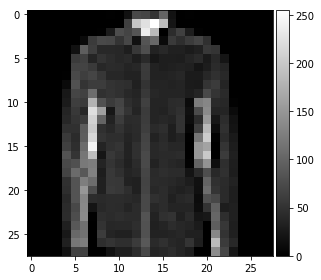

step  1000 / 1000 d_loss:  0.45465901494026184 g_loss:  0.7855787
epoch 70 progress report:
latent shape:  (1, 100)
latent:  [[0.91472839 0.45841066 0.76885689 0.86697561 0.64500224 0.10406167
  0.86304078 0.34961857 0.90962913 0.94073294 0.4434128  0.2819302
  0.15842206 0.17263051 0.17208568 0.55753322 0.22518284 0.11949425
  0.65599127 0.85826356 0.19506448 0.75512379 0.35517233 0.3809724
  0.10226916 0.23462647 0.04501452 0.1614346  0.99218464 0.02331044
  0.3148321  0.53743708 0.78507679 0.73854364 0.08815125 0.70826581
  0.64022298 0.42492168 0.07245625 0.60607455 0.34359061 0.38618351
  0.38478825 0.58304273 0.01069451 0.60894343 0.18102036 0.24834704
  0.96327809 0.31255133 0.5544034  0.12713578 0.83009136 0.09476165
  0.7501711  0.43366339 0.7713677  0.75644962 0.39482437 0.18724999
  0.2501842  0.53779373 0.7395597  0.06979467 0.84806788 0.50634748
  0.39729808 0.16134055 0.0570488  0.60432994 0.59514289 0.09641333
  0.81748924 0.91681284 0.00727846 0.96423982 0.24010583 0.47

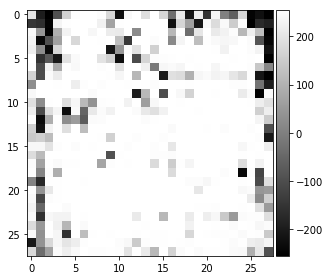

TARGET


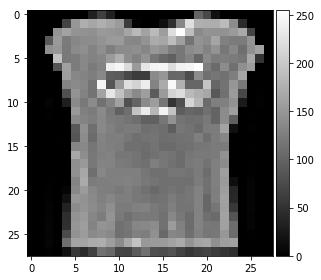

step  1000 / 1000 d_loss:  0.39279747009277344 g_loss:  0.7852727
epoch 71 progress report:
latent shape:  (1, 100)
latent:  [[0.87439979 0.89218325 0.80501857 0.16456218 0.32902416 0.55613376
  0.1604954  0.09830718 0.28298095 0.77485314 0.95146976 0.3240549
  0.43461568 0.8330965  0.06258723 0.19794366 0.06086611 0.02522295
  0.8321967  0.86295988 0.83681527 0.16765422 0.231961   0.45127109
  0.29177694 0.4416736  0.75136742 0.40644115 0.63653581 0.73097647
  0.75005652 0.32440752 0.86304382 0.11028077 0.13707035 0.16311893
  0.88421679 0.824452   0.18644531 0.11091886 0.75383752 0.03242611
  0.16937666 0.66860632 0.99498991 0.63421858 0.66156393 0.21804401
  0.46989317 0.11580757 0.44177224 0.23130388 0.72549435 0.63302323
  0.42219837 0.84904128 0.63075048 0.42551108 0.03211024 0.94244095
  0.29576012 0.51288475 0.87665416 0.87943514 0.04951567 0.3225563
  0.45405515 0.34826348 0.00588131 0.65091274 0.47787252 0.40230942
  0.10681382 0.72286231 0.54583809 0.03078144 0.79653567 0.51

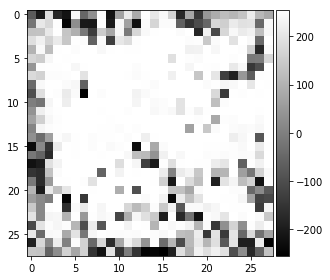

TARGET


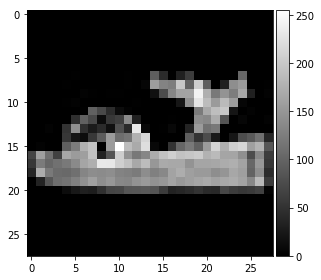

step  1000 / 1000 d_loss:  0.40430447459220886 g_loss:  0.7849566
epoch 72 progress report:
latent shape:  (1, 100)
latent:  [[0.81687513 0.51133644 0.67944765 0.24246389 0.76736241 0.36809996
  0.16184048 0.37135847 0.38777199 0.88638095 0.24282391 0.88637331
  0.53351919 0.30790669 0.41827875 0.04713839 0.72404801 0.23404335
  0.39704727 0.33749553 0.92251243 0.37063948 0.89288195 0.1811779
  0.60866811 0.08274804 0.82301516 0.97492869 0.89096991 0.57218308
  0.07433401 0.43937982 0.64580225 0.8731461  0.74497266 0.52644414
  0.74507403 0.94498477 0.90640394 0.12271114 0.42353086 0.61601247
  0.16059473 0.95995695 0.71714905 0.98171003 0.38928367 0.3047341
  0.24023728 0.92262094 0.06429511 0.13599096 0.63092476 0.74451096
  0.19844472 0.76725616 0.35552202 0.79769708 0.61711237 0.80306475
  0.71788351 0.37584238 0.27884797 0.52619501 0.63803222 0.17011915
  0.72240439 0.61129561 0.95976997 0.59808788 0.2070583  0.79535754
  0.53167828 0.60198967 0.74222968 0.92118186 0.59675844 0.54

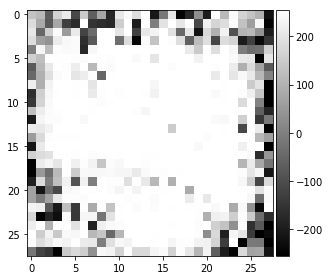

TARGET


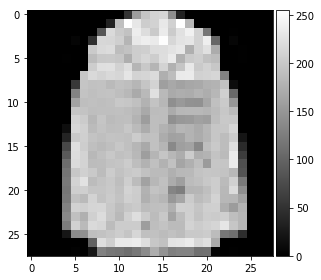

step  1000 / 1000 d_loss:  0.39639198780059814 g_loss:  0.784637
epoch 73 progress report:
latent shape:  (1, 100)
latent:  [[0.51875866 0.42951426 0.34745531 0.02060076 0.1319828  0.22440287
  0.12739317 0.76845394 0.1448624  0.67177271 0.37948335 0.8602371
  0.85259641 0.28288571 0.66091241 0.58356409 0.97502851 0.26372028
  0.30423264 0.95187088 0.97596545 0.25347871 0.38831782 0.57979597
  0.61967963 0.17912401 0.94367021 0.34632376 0.84607913 0.14949537
  0.50671798 0.88320249 0.72494094 0.35984434 0.87878598 0.54598796
  0.91704141 0.01950516 0.91063372 0.25595519 0.11184503 0.34228217
  0.87801662 0.39848281 0.68453494 0.66369294 0.02627791 0.95501107
  0.60929878 0.69645274 0.2396309  0.70032799 0.95816834 0.36533222
  0.70667924 0.37277419 0.98174612 0.64106122 0.6915134  0.56630508
  0.54105781 0.66285792 0.48393731 0.77190056 0.75230875 0.91576604
  0.7577432  0.32094498 0.45156951 0.93964031 0.25985727 0.04376498
  0.31348138 0.87834054 0.00498113 0.34803042 0.30600133 0.03

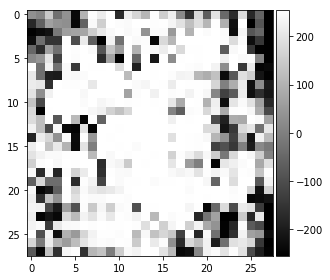

TARGET


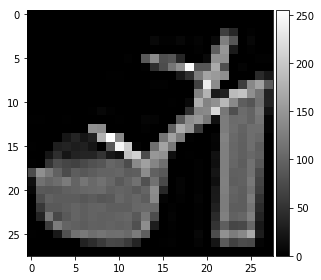

step  1000 / 1000 d_loss:  0.3984401822090149 g_loss:  0.7843136
epoch 74 progress report:
latent shape:  (1, 100)
latent:  [[3.39257219e-01 4.43601430e-01 4.72761215e-01 9.62327882e-01
  1.65126243e-01 7.27407247e-01 2.70763331e-01 2.08788681e-01
  2.48696378e-01 9.66669637e-02 4.51607283e-01 8.58279752e-01
  6.53988422e-01 2.59502346e-01 4.35449587e-01 8.88501364e-01
  4.51553601e-01 9.48314966e-01 1.78232528e-01 3.50089122e-01
  2.19915498e-01 1.94859699e-04 8.33266670e-01 2.01819157e-01
  2.63301145e-01 4.69521246e-01 6.67891785e-01 5.93573652e-01
  6.60766636e-01 6.27848366e-01 3.17574180e-01 2.03751947e-03
  3.68151846e-01 3.01407721e-01 2.80162961e-01 8.13010625e-01
  4.56469355e-01 9.57387065e-01 8.29364221e-02 4.32591751e-01
  9.46184773e-01 6.73495724e-01 9.14950965e-01 9.59257833e-01
  5.01026327e-01 3.62434725e-02 2.92312511e-01 9.22251393e-01
  3.96420945e-02 6.80545756e-01 9.09037762e-01 2.25115557e-01
  7.99401972e-01 5.31704547e-02 2.65239625e-01 7.24191236e-01
  1.2531

TARGET


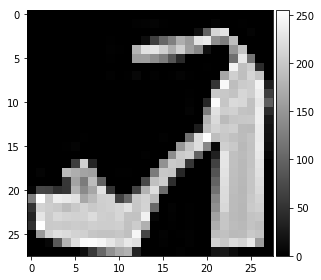

step  1000 / 1000 d_loss:  0.39261001348495483 g_loss:  0.7839837
epoch 75 progress report:
latent shape:  (1, 100)
latent:  [[0.97395424 0.78948369 0.89067455 0.29541294 0.75021448 0.88423481
  0.94253827 0.38312281 0.21711839 0.59955138 0.31330704 0.6673881
  0.66546297 0.08724956 0.97380564 0.27396612 0.58366031 0.77524108
  0.30046602 0.12955193 0.69208085 0.23888743 0.59591555 0.40220458
  0.67239305 0.08978865 0.05862695 0.34619511 0.76814629 0.25591962
  0.24996545 0.80910967 0.11861965 0.335949   0.50501877 0.00608354
  0.67364725 0.86517454 0.50736415 0.10584736 0.24712375 0.91825665
  0.77272818 0.82268499 0.08346968 0.77836981 0.82141757 0.4380596
  0.14457255 0.31945789 0.65772639 0.26482754 0.39189051 0.12395613
  0.56535848 0.86691532 0.20628365 0.17086244 0.49303855 0.91641949
  0.91940284 0.81710238 0.80822193 0.57037359 0.85822223 0.31417609
  0.31253985 0.70318463 0.60958434 0.08664204 0.19469352 0.5651791
  0.12921081 0.94451639 0.28105941 0.52035641 0.05624836 0.556

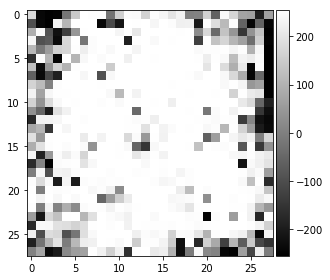

TARGET


step  1000 / 1000 d_loss:  0.3971419334411621 g_loss:  0.7830069
epoch 76 progress report:
latent shape:  (1, 100)
latent:  [[0.68867448 0.59946629 0.10777584 0.95903764 0.08735355 0.57635618
  0.22350204 0.95578529 0.91569381 0.90731522 0.07101367 0.88797369
  0.10122905 0.06055938 0.64401095 0.4285614  0.75632337 0.62073876
  0.47819762 0.73995603 0.98133591 0.25225738 0.37185927 0.22837199
  0.29404564 0.52068705 0.14043283 0.17771478 0.39682975 0.235824
  0.28962332 0.14634321 0.1522479  0.68402235 0.17692067 0.1740322
  0.45101018 0.90380023 0.42169812 0.85236015 0.16293174 0.38609019
  0.69479329 0.32957828 0.88924062 0.27107811 0.382388   0.19281878
  0.46643998 0.91367372 0.07680367 0.86350918 0.8844624  0.0712361
  0.08521039 0.30654111 0.5595255  0.26358877 0.4189504  0.01879023
  0.1329202  0.00585924 0.5110667  0.78839381 0.60424711 0.92874244
  0.21394408 0.94416808 0.71338903 0.36322682 0.63069529 0.84930158
  0.58692582 0.59839166 0.85011383 0.94131582 0.52155848 0.47666

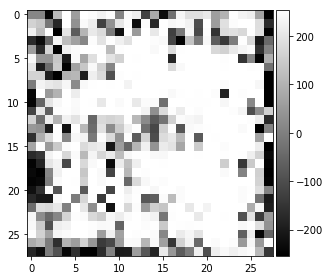

TARGET


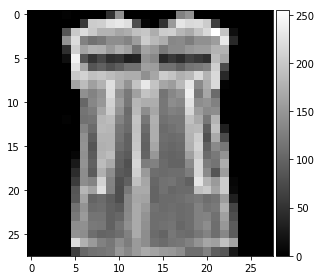

step  1000 / 1000 d_loss:  0.46278688311576843 g_loss:  0.7826929
epoch 77 progress report:
latent shape:  (1, 100)
latent:  [[0.98292075 0.11237426 0.64015002 0.77581891 0.219616   0.86457532
  0.38240813 0.46567489 0.95468068 0.08543999 0.90562106 0.3384748
  0.25450744 0.12439798 0.02491284 0.79873122 0.31145395 0.16234811
  0.39982579 0.88483958 0.4562736  0.87792766 0.1448509  0.42126845
  0.97186989 0.8859857  0.83693797 0.66363295 0.08819874 0.83214418
  0.24417983 0.46356266 0.26749937 0.44164842 0.79707759 0.7742924
  0.88273036 0.47477745 0.04433481 0.12223014 0.89677044 0.74588329
  0.51213856 0.49961935 0.82109137 0.70483328 0.50012523 0.90483421
  0.69830207 0.90993384 0.92860987 0.7051735  0.81589653 0.89371851
  0.63839043 0.03179349 0.18698618 0.90255958 0.83386978 0.37668847
  0.599007   0.35926056 0.90238234 0.39025123 0.85341522 0.61962152
  0.73152744 0.55373146 0.24732589 0.20856325 0.09236584 0.65742269
  0.96284244 0.81513937 0.89535014 0.57234521 0.51710501 0.97

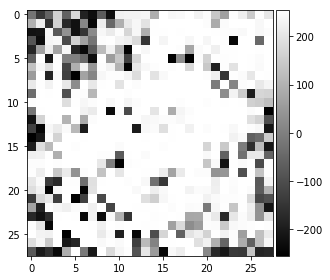

TARGET


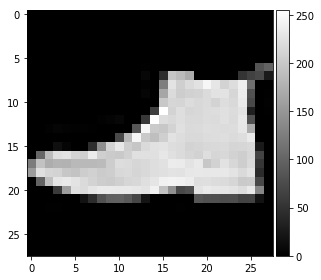

step  1000 / 1000 d_loss:  0.3916082978248596 g_loss:  0.78201383
epoch 78 progress report:
latent shape:  (1, 100)
latent:  [[0.40029052 0.25780481 0.7245957  0.63312352 0.17400863 0.16386992
  0.03003665 0.13908872 0.69822808 0.92797337 0.43613034 0.43834695
  0.99543351 0.96004978 0.31422785 0.05621372 0.46094024 0.72881426
  0.78111865 0.16728163 0.77868324 0.56274021 0.56246427 0.10143581
  0.81650324 0.31992389 0.1220559  0.69276457 0.63356432 0.68018445
  0.00997475 0.72298629 0.17303397 0.65728411 0.78161388 0.26392724
  0.18506265 0.20632949 0.73023747 0.06478861 0.84354133 0.82476171
  0.98673022 0.84998207 0.32192728 0.58769535 0.73177043 0.2401732
  0.35257806 0.33837253 0.38409604 0.35245692 0.22928062 0.79102741
  0.43540992 0.78128901 0.54900733 0.61990552 0.20699799 0.81351985
  0.12412699 0.90978405 0.12235534 0.74454563 0.65825856 0.79253383
  0.79824697 0.24193744 0.97874834 0.22365004 0.82610653 0.76848626
  0.10430008 0.64966877 0.62026001 0.72320017 0.01574874 0.5

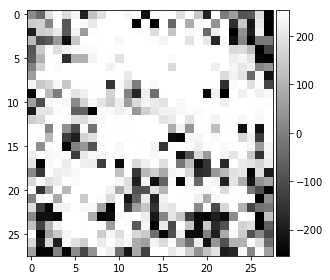

TARGET


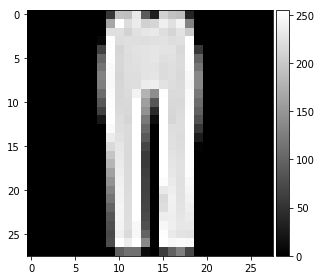

step  1000 / 1000 d_loss:  0.4912651479244232 g_loss:  0.7816702
epoch 79 progress report:
latent shape:  (1, 100)
latent:  [[0.90293096 0.32591369 0.42898059 0.7572928  0.28094472 0.49970622
  0.58821737 0.26159016 0.69860882 0.06497053 0.76299809 0.30519929
  0.45613999 0.52216097 0.33177749 0.61707202 0.13244401 0.41970443
  0.41594495 0.76891495 0.36421546 0.63113608 0.76708487 0.56235428
  0.59175406 0.40722958 0.67774061 0.32552816 0.89268178 0.47185105
  0.74888649 0.63483887 0.45935815 0.90391766 0.42129549 0.40773402
  0.4490419  0.58536021 0.05253264 0.84626383 0.21895617 0.49635827
  0.00647831 0.90194255 0.23542526 0.66843156 0.42839757 0.93906457
  0.81227436 0.59532788 0.61744199 0.59421355 0.61642414 0.50516236
  0.24976021 0.43641783 0.36696955 0.61484834 0.66235646 0.42997429
  0.63635412 0.78024604 0.50440308 0.94304749 0.24401079 0.39692101
  0.23397856 0.18179937 0.44708655 0.12698774 0.64412871 0.43742752
  0.69859528 0.50841171 0.88055429 0.71825015 0.46104047 0.7

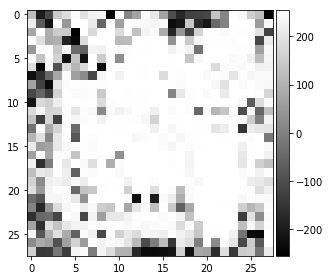

TARGET


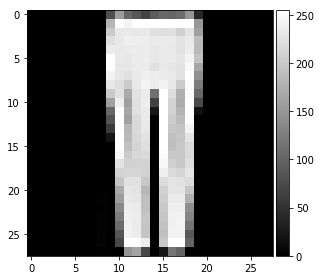

step  1000 / 1000 d_loss:  0.4643056094646454 g_loss:  0.7813405
epoch 80 progress report:
latent shape:  (1, 100)
latent:  [[0.18245293 0.87116546 0.04507423 0.52770129 0.15403412 0.51733486
  0.96216024 0.77663385 0.48011767 0.29340907 0.94436885 0.73548501
  0.69077579 0.05281312 0.80632984 0.81573091 0.62547835 0.97834382
  0.30652742 0.85895032 0.15192185 0.7716348  0.9610212  0.31844272
  0.15119973 0.5440547  0.16635623 0.99590431 0.49491286 0.08786086
  0.3025737  0.36001402 0.41173538 0.48842462 0.72838682 0.15732006
  0.89922278 0.85122238 0.69013714 0.67385419 0.76025324 0.51505096
  0.10895265 0.0671531  0.11141394 0.38375835 0.60272383 0.86308362
  0.1016269  0.36612501 0.28291119 0.43953189 0.37203698 0.30587321
  0.15530902 0.48271266 0.77643431 0.94664276 0.91889077 0.05819124
  0.12437048 0.01463324 0.13796872 0.35378275 0.62128191 0.1737357
  0.48889895 0.54107828 0.77822455 0.34603943 0.73709716 0.108685
  0.23845369 0.88584109 0.32051407 0.09232949 0.25283651 0.2938

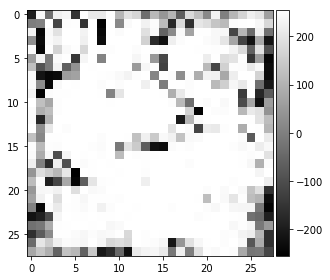

TARGET


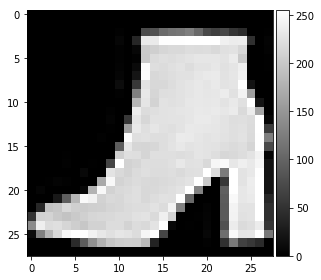

step  1000 / 1000 d_loss:  0.4186554551124573 g_loss:  0.7809995
epoch 81 progress report:
latent shape:  (1, 100)
latent:  [[0.11636458 0.38062737 0.191811   0.28205881 0.51098988 0.64150987
  0.185141   0.46498772 0.06938043 0.39640556 0.66160824 0.79344449
  0.68659913 0.90954385 0.35901797 0.46565669 0.91737577 0.96823518
  0.3488712  0.84215444 0.57383882 0.70428243 0.81875316 0.96483594
  0.08578235 0.97208881 0.20484713 0.68451855 0.68638429 0.43147854
  0.48236125 0.27893353 0.31785244 0.0967422  0.71519137 0.80799185
  0.85340893 0.6128066  0.96710347 0.85407424 0.2973383  0.74775252
  0.8676198  0.50131088 0.2437654  0.8659082  0.16457062 0.89293139
  0.24363273 0.53979341 0.72432914 0.77447363 0.16769507 0.33604876
  0.80371308 0.29897512 0.58135893 0.69313834 0.44457621 0.6394954
  0.11786166 0.78364546 0.5737632  0.40244692 0.43857186 0.32374129
  0.64046174 0.55008856 0.72199114 0.57668249 0.82505858 0.75526055
  0.19034432 0.12003172 0.69905785 0.17718125 0.36944634 0.37

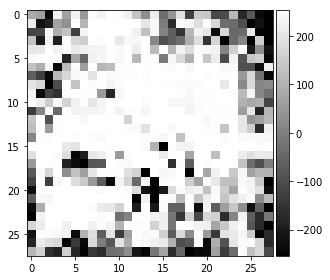

TARGET


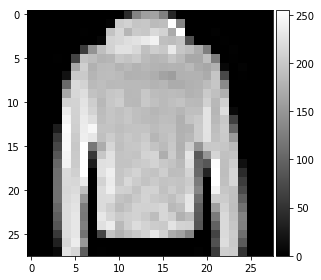

step  1000 / 1000 d_loss:  0.3991367816925049 g_loss:  0.7808635
epoch 82 progress report:
latent shape:  (1, 100)
latent:  [[0.59591749 0.03646259 0.17040837 0.67977111 0.42635784 0.60800774
  0.09396621 0.03183059 0.33976407 0.74986831 0.82288428 0.41020315
  0.70872123 0.09004259 0.65650577 0.0778899  0.02721545 0.81918404
  0.02696371 0.64774015 0.13530309 0.69229184 0.33387736 0.17272111
  0.7223429  0.66491567 0.25538543 0.85223717 0.09588174 0.92857153
  0.22574433 0.89607636 0.14278434 0.03146093 0.13628075 0.26913754
  0.56539245 0.8553956  0.11801533 0.25304423 0.92102629 0.5010374
  0.88118861 0.99255441 0.42307397 0.29786544 0.12527232 0.99609401
  0.19811946 0.39966162 0.1446126  0.51043977 0.53494472 0.84954548
  0.44002425 0.55849314 0.44215986 0.22926262 0.88376994 0.67442293
  0.62994064 0.10833869 0.19516456 0.97142152 0.1357347  0.41186957
  0.94841043 0.01823548 0.01628839 0.47271659 0.04029511 0.85869016
  0.2624026  0.53907294 0.28617813 0.37605307 0.4417446  0.25

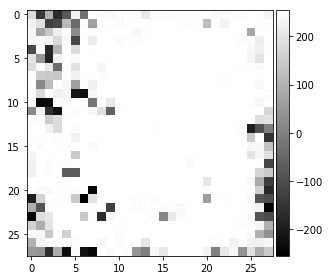

TARGET


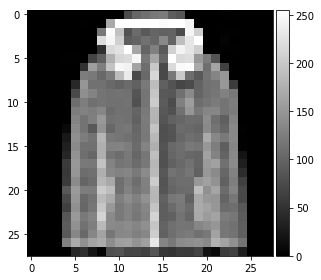

step  1000 / 1000 d_loss:  0.4969977140426636 g_loss:  0.77875036
epoch 83 progress report:
latent shape:  (1, 100)
latent:  [[0.97667745 0.95399332 0.26327671 0.97255534 0.19870808 0.8838316
  0.37884369 0.44830646 0.43274853 0.81916692 0.20457172 0.04434097
  0.10113917 0.55494402 0.20314504 0.22898006 0.85910004 0.17514156
  0.87837187 0.28113312 0.212074   0.18104201 0.65608653 0.9718561
  0.70611046 0.64937263 0.09517369 0.6151505  0.63577645 0.76424372
  0.01706163 0.18139703 0.12724754 0.00940497 0.67583835 0.19612087
  0.75336139 0.06052684 0.61874424 0.27096921 0.74399967 0.57487781
  0.69616116 0.15007415 0.70162913 0.60279231 0.15373174 0.54483203
  0.48429293 0.00488967 0.32266165 0.48437199 0.16681779 0.82729912
  0.28174303 0.98684638 0.12599719 0.56278635 0.67905539 0.26912799
  0.87616164 0.26558511 0.23363355 0.72884449 0.99840578 0.30736422
  0.21177507 0.66390489 0.14538591 0.79134409 0.49595236 0.44624865
  0.39907532 0.92988326 0.03254921 0.26247193 0.20263553 0.89

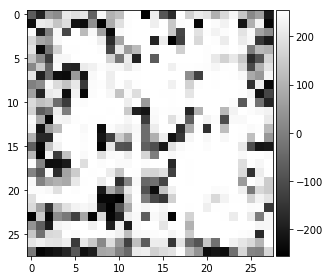

TARGET


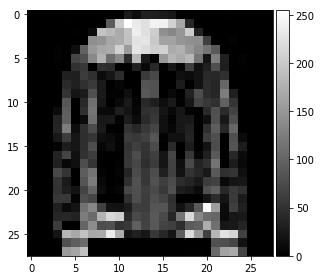

step  1000 / 1000 d_loss:  0.3895609676837921 g_loss:  0.77822113
epoch 84 progress report:
latent shape:  (1, 100)
latent:  [[0.36002244 0.04526088 0.62992651 0.53334481 0.29486016 0.66970196
  0.78859165 0.37505066 0.94923293 0.47254762 0.27504727 0.79934806
  0.35192179 0.45825855 0.93308785 0.37920222 0.57774454 0.05116675
  0.80717194 0.98772202 0.72588114 0.13690012 0.91976747 0.79995978
  0.16880522 0.61777062 0.12720765 0.89112925 0.78219688 0.76882483
  0.56082182 0.00883058 0.6341918  0.58066546 0.57763386 0.5059826
  0.83761969 0.98515866 0.90063973 0.55847136 0.01542539 0.98998352
  0.4822548  0.26864271 0.47553971 0.21664123 0.38113771 0.53833524
  0.28202999 0.24657593 0.40186666 0.43122017 0.91801192 0.01845386
  0.43822251 0.40275417 0.05322533 0.95636581 0.4708302  0.31893051
  0.97156075 0.25107433 0.72295449 0.92129526 0.21896437 0.9498904
  0.47822757 0.22614268 0.59307612 0.593592   0.74820489 0.3938338
  0.19106813 0.50629773 0.46004837 0.79532553 0.81650746 0.293

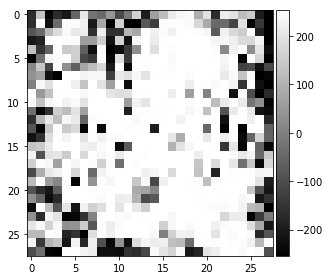

TARGET


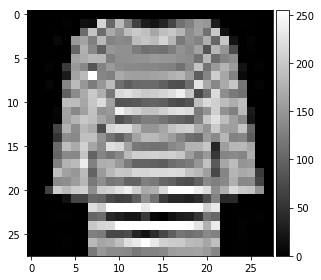

step  1000 / 1000 d_loss:  0.4315115511417389 g_loss:  0.7778323
epoch 85 progress report:
latent shape:  (1, 100)
latent:  [[0.80009819 0.69822051 0.78646265 0.44161773 0.23030548 0.66796889
  0.53136237 0.50179701 0.78315636 0.07611555 0.42916979 0.3680087
  0.65806355 0.16062644 0.23597446 0.17678256 0.83604446 0.88075406
  0.06090432 0.53630619 0.1469415  0.93313157 0.58413799 0.35814511
  0.8878336  0.2691737  0.01714763 0.59630515 0.44514453 0.35337136
  0.39547757 0.43775596 0.29881318 0.2844034  0.32423419 0.36127943
  0.88746132 0.29228858 0.83355215 0.23997602 0.84705056 0.16999389
  0.19511971 0.25407433 0.90000801 0.8584649  0.06129153 0.14943072
  0.10390146 0.46085778 0.29127202 0.44822282 0.82424746 0.55832538
  0.21057785 0.07678641 0.75523434 0.57918981 0.06018831 0.36135898
  0.47530656 0.78645956 0.74851371 0.18370179 0.68916876 0.49942957
  0.26228813 0.9700403  0.52523195 0.15387902 0.42865917 0.95437563
  0.69268528 0.88447383 0.50071921 0.09800995 0.4552584  0.22

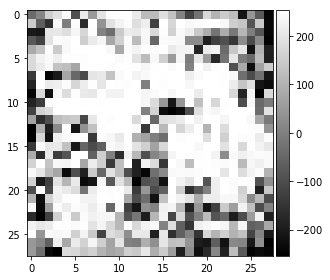

TARGET


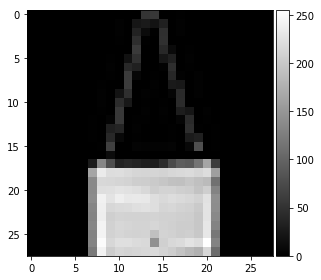

step  1000 / 1000 d_loss:  0.3917388916015625 g_loss:  0.77717465
epoch 86 progress report:
latent shape:  (1, 100)
latent:  [[0.09394027 0.7912778  0.73035298 0.81962836 0.92174144 0.70797424
  0.17747735 0.39747638 0.10391151 0.39270799 0.6530011  0.9841103
  0.19051652 0.72169096 0.66645478 0.24699612 0.25271606 0.65277096
  0.81671329 0.01358825 0.11570116 0.56092549 0.78153388 0.79241112
  0.72241268 0.06054493 0.46033386 0.50356212 0.2909509  0.47972904
  0.51554493 0.81463217 0.60564532 0.59078186 0.1056481  0.23028552
  0.1405605  0.0433741  0.80173603 0.34023894 0.69953295 0.9093642
  0.3095016  0.3392246  0.2796104  0.79936325 0.28771941 0.56776894
  0.6596847  0.84195886 0.1488547  0.26343954 0.51033767 0.61590137
  0.09179683 0.20229741 0.16241454 0.22667707 0.67045695 0.2365516
  0.66335158 0.53367997 0.40853336 0.43780612 0.64733729 0.43693196
  0.38580404 0.99983945 0.34491353 0.11151572 0.33043826 0.14196412
  0.09826569 0.19598733 0.58918049 0.21233582 0.53733038 0.710

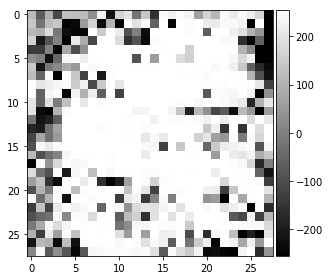

TARGET


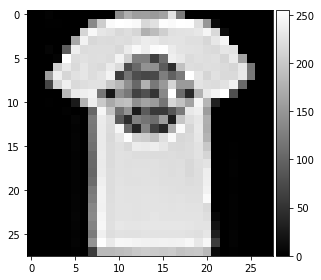

step  1000 / 1000 d_loss:  0.38957151770591736 g_loss:  0.77691746
epoch 87 progress report:
latent shape:  (1, 100)
latent:  [[0.63630989 0.36435215 0.06333332 0.67776574 0.15450092 0.0152552
  0.06690068 0.8556802  0.30594274 0.95096985 0.28130032 0.99081416
  0.36834948 0.62455048 0.14304779 0.08500158 0.84861311 0.7391743
  0.99101214 0.70809767 0.4791629  0.38386052 0.40142419 0.66849561
  0.65290817 0.38094474 0.84333784 0.18604664 0.16074488 0.28195186
  0.44319985 0.79040256 0.86311793 0.45598223 0.85871605 0.21977062
  0.32639706 0.74845447 0.61193074 0.17136966 0.21883557 0.92962387
  0.22267864 0.8260982  0.53803466 0.15190057 0.75372234 0.77915437
  0.69070932 0.5686864  0.45905967 0.76511122 0.51685604 0.60192627
  0.98394527 0.23964913 0.29533928 0.82928081 0.77213534 0.25361839
  0.64431008 0.69089894 0.15940337 0.17794535 0.80592962 0.41313216
  0.03163084 0.49270199 0.31548969 0.46637782 0.00794943 0.49799481
  0.24731127 0.44613258 0.8728231  0.09632222 0.37941531 0.9

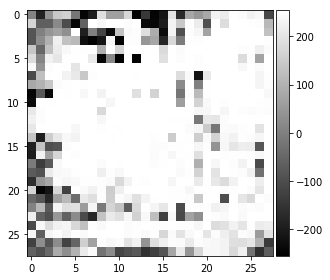

TARGET


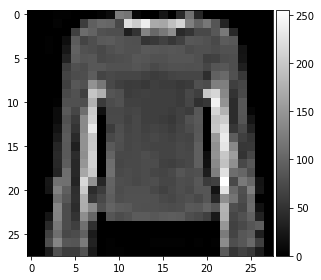

step  1000 / 1000 d_loss:  0.4660693109035492 g_loss:  0.77640676
epoch 88 progress report:
latent shape:  (1, 100)
latent:  [[0.54137208 0.20987761 0.14475429 0.11139163 0.49207236 0.27000376
  0.45007074 0.38666828 0.65157738 0.77060477 0.41477056 0.05469614
  0.39845831 0.11727903 0.37734442 0.56165514 0.69173536 0.76807871
  0.49915287 0.40527437 0.6608908  0.7831351  0.84619224 0.96665048
  0.95595291 0.12733505 0.05432634 0.22230567 0.09890868 0.19804133
  0.5727981  0.11662697 0.70643298 0.2388945  0.84713588 0.59960839
  0.12956058 0.51372491 0.8954558  0.40926591 0.75281443 0.3188135
  0.49214368 0.85371921 0.07878562 0.02044828 0.5965346  0.5643408
  0.32323515 0.27419438 0.60434541 0.07398607 0.60532675 0.3578346
  0.02701323 0.88184414 0.42124309 0.81486218 0.1365683  0.71385004
  0.76272441 0.43321885 0.13889029 0.92737108 0.7516478  0.16052806
  0.52912882 0.4724391  0.34683849 0.50814858 0.021277   0.66629321
  0.33361594 0.16752315 0.81974933 0.8741868  0.01851951 0.002

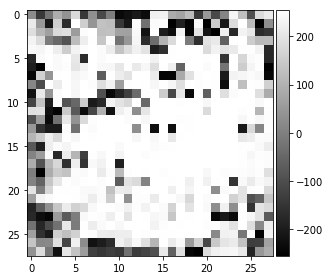

TARGET


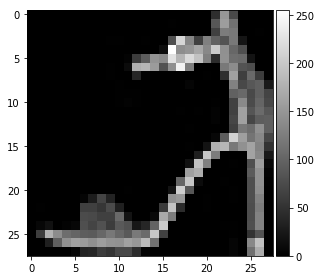

step  1000 / 1000 d_loss:  0.41670262813568115 g_loss:  0.77593493
epoch 89 progress report:
latent shape:  (1, 100)
latent:  [[0.47368031 0.93541501 0.15849675 0.86907436 0.04295505 0.79404132
  0.70424109 0.4762062  0.66505534 0.88294379 0.81587349 0.40651894
  0.58357541 0.94661229 0.74667662 0.97654494 0.79519536 0.36346391
  0.42694579 0.13322049 0.82449598 0.35118526 0.10757455 0.58710592
  0.85193844 0.83496658 0.48077229 0.71700029 0.07692985 0.15484106
  0.89014989 0.10545871 0.49907538 0.91276267 0.37748952 0.26214405
  0.10443194 0.2988626  0.88830603 0.13524964 0.48490823 0.43916041
  0.05866406 0.61249072 0.95973822 0.97851033 0.3906227  0.67528981
  0.24284095 0.02971298 0.39950197 0.35216902 0.73079797 0.24362894
  0.97227934 0.75043535 0.41112395 0.32683666 0.55524006 0.96745528
  0.88484845 0.77375434 0.67074578 0.06830722 0.91234296 0.42218928
  0.32892394 0.87901274 0.20169121 0.45006306 0.82137633 0.66225549
  0.6855859  0.95838493 0.02479821 0.98544827 0.11176025 0

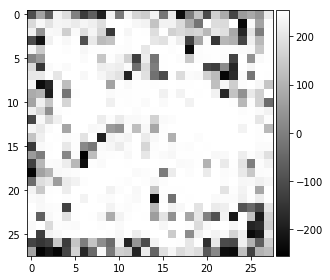

TARGET


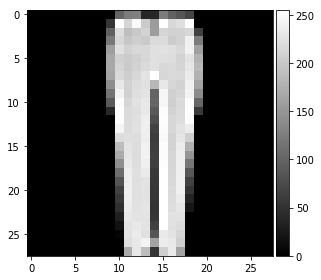

step  1000 / 1000 d_loss:  0.47386792302131653 g_loss:  0.7756953
epoch 90 progress report:
latent shape:  (1, 100)
latent:  [[0.81194771 0.91905437 0.24642665 0.98128247 0.42375096 0.69702241
  0.93550726 0.48915986 0.88621161 0.68415348 0.36916688 0.36566994
  0.29978629 0.49038427 0.84145641 0.54732055 0.39588342 0.19620643
  0.686749   0.773238   0.07217277 0.85139983 0.18114584 0.96691357
  0.46467414 0.45065555 0.60282426 0.61716426 0.89978835 0.65169859
  0.38016415 0.6214721  0.42449273 0.35975267 0.54119536 0.23880893
  0.96019896 0.59747172 0.70589675 0.44310043 0.32832435 0.7555081
  0.55811197 0.99864763 0.26059657 0.18052725 0.48475031 0.95918651
  0.38697073 0.05423463 0.83483274 0.22053586 0.23017223 0.27235701
  0.02600932 0.40260961 0.92353689 0.95103637 0.82520893 0.50249964
  0.61465397 0.91945514 0.21303104 0.41509158 0.47278542 0.59532027
  0.95739696 0.26489858 0.92931741 0.00189949 0.32583556 0.80073946
  0.96309873 0.51742146 0.12725387 0.96773635 0.67016038 0.7

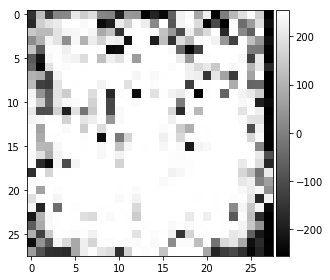

TARGET


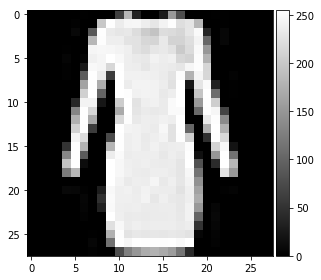

step  1000 / 1000 d_loss:  0.4069331884384155 g_loss:  0.77545214
epoch 91 progress report:
latent shape:  (1, 100)
latent:  [[0.75732256 0.22112084 0.52592998 0.57774061 0.24871002 0.72135838
  0.60147556 0.06208361 0.60977448 0.39018226 0.79699311 0.54274627
  0.6623941  0.8491705  0.94914589 0.75478501 0.94630928 0.30997317
  0.12346783 0.30270176 0.50344224 0.09690786 0.83892367 0.99993248
  0.63901582 0.55175482 0.8497572  0.97651055 0.01371088 0.91654434
  0.72531398 0.92394698 0.59541454 0.23144526 0.84918303 0.31085953
  0.49058204 0.31137015 0.08822755 0.86556381 0.95043598 0.56895288
  0.58178964 0.94929873 0.86560013 0.35706526 0.06154329 0.02697417
  0.72120898 0.61432095 0.12368972 0.99717546 0.84510726 0.11661512
  0.81557678 0.43240832 0.31323105 0.85956051 0.1883118  0.03465918
  0.23866048 0.08504643 0.30368578 0.31398816 0.45456009 0.28692806
  0.66311259 0.84402119 0.22370934 0.0559977  0.85789666 0.36599834
  0.98197687 0.76858433 0.49893998 0.16105455 0.85912459 0.

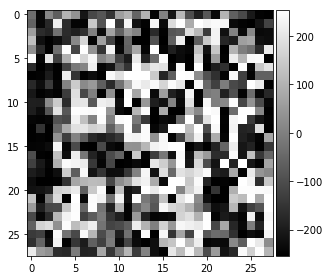

TARGET


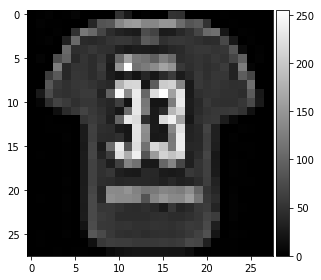

step  1000 / 1000 d_loss:  0.41347846388816833 g_loss:  0.7751882
epoch 92 progress report:
latent shape:  (1, 100)
latent:  [[0.99810872 0.34771571 0.57705926 0.06356581 0.43463476 0.63794348
  0.35626652 0.39758456 0.97903559 0.63672504 0.86173944 0.44218386
  0.39072464 0.52555141 0.88591855 0.9214953  0.24112316 0.10545188
  0.70186174 0.49340716 0.54114647 0.20673041 0.30557591 0.19791952
  0.16510099 0.86427131 0.05096704 0.44466391 0.26186158 0.79089437
  0.08069961 0.30527488 0.14492517 0.38624557 0.95469235 0.70199703
  0.05171023 0.16318924 0.15679147 0.95782868 0.57436481 0.21484825
  0.21856586 0.626856   0.01004669 0.6355281  0.68064194 0.34105022
  0.70857832 0.77792993 0.77224438 0.53467698 0.34106054 0.95344863
  0.80542614 0.29177003 0.8154063  0.79449199 0.19795438 0.74426491
  0.95179742 0.14266681 0.40937324 0.84893887 0.87069468 0.08711197
  0.89285844 0.49610237 0.76266048 0.40673298 0.07620304 0.00195876
  0.97776358 0.44020968 0.24847558 0.05081953 0.98331888 0.

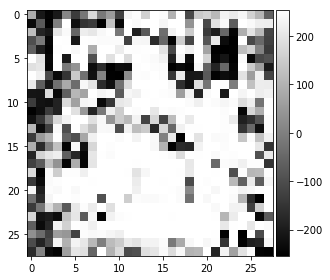

TARGET


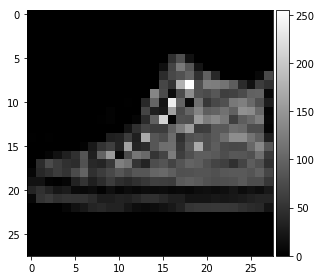

step  1000 / 1000 d_loss:  0.45350775122642517 g_loss:  0.77491677
epoch 93 progress report:
latent shape:  (1, 100)
latent:  [[0.37224964 0.90821134 0.09646296 0.32854765 0.30516128 0.17081114
  0.15534071 0.9018874  0.99425997 0.7968312  0.23265962 0.95438707
  0.61974702 0.73531696 0.72722888 0.76437654 0.57387929 0.25428505
  0.74583185 0.45691696 0.34598869 0.52222681 0.44638966 0.18477079
  0.80007853 0.28623663 0.39738508 0.97042777 0.70202686 0.06618536
  0.81190458 0.73966543 0.83002114 0.97578301 0.52439822 0.53993335
  0.54575136 0.29976503 0.03707267 0.81412289 0.43164625 0.54960289
  0.870133   0.61789012 0.26660953 0.79958234 0.98333538 0.33254966
  0.13480315 0.7284799  0.63440274 0.26132121 0.70713174 0.75509946
  0.47939809 0.2325574  0.36348855 0.62162279 0.40008784 0.4624189
  0.61995139 0.03983644 0.45024724 0.46248096 0.17857931 0.47099617
  0.74233224 0.37827962 0.82232583 0.47444094 0.51482795 0.31107369
  0.74449189 0.73834463 0.33900351 0.46412271 0.30945431 0.

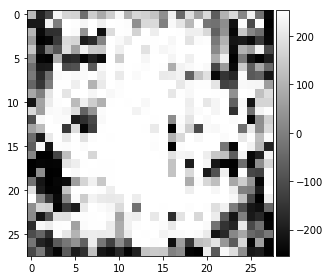

TARGET


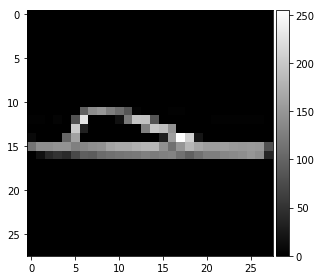

step  1000 / 1000 d_loss:  0.3908814787864685 g_loss:  0.77403283
epoch 94 progress report:
latent shape:  (1, 100)
latent:  [[0.29409781 0.42333677 0.13626863 0.9454745  0.41281843 0.44355012
  0.21429808 0.63109211 0.39430029 0.67140841 0.34123435 0.53800087
  0.78398947 0.23910944 0.26368681 0.68994832 0.39342078 0.05613458
  0.07874092 0.438968   0.4551057  0.14687255 0.37431929 0.5420951
  0.39910866 0.97975544 0.57418155 0.97282078 0.50146621 0.23812879
  0.93609379 0.59646822 0.06185897 0.73822304 0.56062801 0.73793681
  0.32564623 0.64781052 0.9151522  0.15697184 0.66926523 0.12770195
  0.10076775 0.68535731 0.31732364 0.5983875  0.60942017 0.0167765
  0.51741858 0.77235257 0.89547791 0.28272079 0.3839935  0.51351651
  0.90902978 0.48527521 0.36736404 0.17895229 0.05333113 0.8833404
  0.17599918 0.45662078 0.96647097 0.93004449 0.46529878 0.6317584
  0.34133012 0.5691205  0.63164549 0.827132   0.42963113 0.20517307
  0.47807237 0.05986192 0.90818404 0.22786997 0.5306923  0.9922

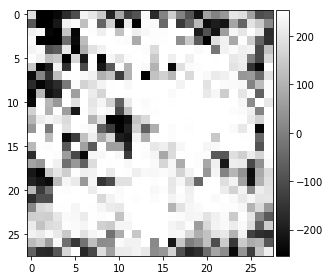

TARGET


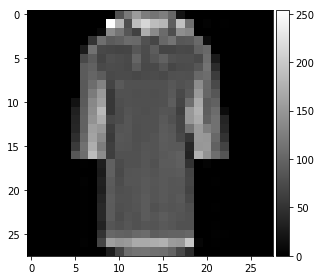

step  1000 / 1000 d_loss:  0.3870314955711365 g_loss:  0.7737877
epoch 95 progress report:
latent shape:  (1, 100)
latent:  [[0.03059196 0.48829323 0.87610633 0.30618293 0.67901715 0.85218478
  0.04719643 0.12547319 0.3775392  0.67105596 0.60875755 0.54043237
  0.91228663 0.64565903 0.18318177 0.42796131 0.91608534 0.20677649
  0.57582656 0.55965317 0.31124158 0.76309923 0.3188505  0.22620928
  0.96849929 0.62886258 0.67651023 0.20959047 0.89504376 0.48602621
  0.82775188 0.44728923 0.05881618 0.65784653 0.52593146 0.45711096
  0.24491722 0.76154691 0.08265464 0.05260541 0.16507006 0.94001865
  0.9973043  0.09956554 0.8086512  0.41497282 0.62320465 0.55738744
  0.41054803 0.72267539 0.92086024 0.05908428 0.58154709 0.48018165
  0.56186312 0.43191204 0.78608575 0.73728561 0.70555917 0.51907435
  0.57165316 0.97181432 0.98471544 0.89157639 0.8473212  0.60185942
  0.66607265 0.34738863 0.04196146 0.67655627 0.2452442  0.25613856
  0.85197923 0.03301357 0.25473869 0.58769553 0.26169387 0.8

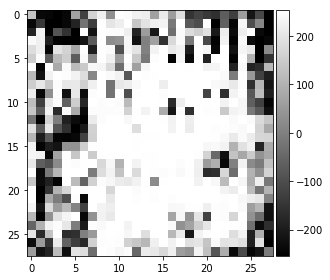

TARGET


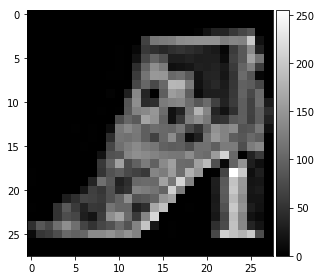

step  1000 / 1000 d_loss:  0.3956810235977173 g_loss:  0.77352136
epoch 96 progress report:
latent shape:  (1, 100)
latent:  [[0.47678921 0.23402128 0.73979971 0.41660925 0.88819914 0.15745051
  0.50880768 0.34945315 0.98503105 0.75735722 0.30101943 0.08827978
  0.804014   0.15909723 0.64700141 0.87107795 0.6113386  0.06587021
  0.35332798 0.93243086 0.46580986 0.75775231 0.27193263 0.20480549
  0.84968934 0.39216411 0.15829962 0.75765091 0.57876158 0.65788944
  0.37970267 0.08980752 0.8948954  0.67630344 0.02747903 0.44567763
  0.53306658 0.4276768  0.59183919 0.18663698 0.89422493 0.41691915
  0.48854267 0.15436539 0.15566053 0.88438168 0.56046341 0.21902057
  0.86848265 0.17580092 0.34800745 0.18865334 0.92061672 0.08054732
  0.0696777  0.60990787 0.72642462 0.31094925 0.63405885 0.32152466
  0.67653834 0.83293874 0.17217548 0.45199082 0.82324605 0.07651132
  0.4028363  0.90430421 0.50085634 0.62864566 0.05093009 0.83603988
  0.73134183 0.63365776 0.02329034 0.35392722 0.86632742 0.

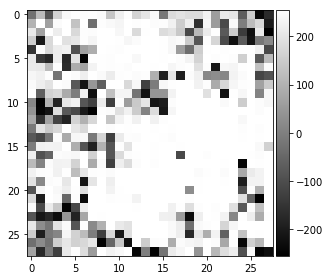

TARGET


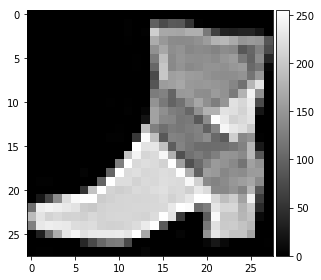

step  1000 / 1000 d_loss:  0.39035117626190186 g_loss:  0.7728263
epoch 97 progress report:
latent shape:  (1, 100)
latent:  [[0.26654613 0.48972006 0.6425491  0.97609388 0.73337651 0.64719807
  0.18416549 0.53145641 0.6553913  0.07395269 0.77259008 0.55845458
  0.53861364 0.68950036 0.2416889  0.04107838 0.90801974 0.45098247
  0.72678656 0.62493608 0.13809757 0.26007383 0.56056105 0.01130447
  0.7847496  0.79209775 0.49977152 0.17887528 0.0121318  0.80213128
  0.88137515 0.68443378 0.75923117 0.61373435 0.2569783  0.66699672
  0.1412296  0.65182603 0.99072918 0.58152909 0.93750039 0.45193271
  0.8822211  0.65163469 0.47870789 0.49391816 0.35673038 0.33938826
  0.88258468 0.24508537 0.5658476  0.01145398 0.46054019 0.93977634
  0.82940153 0.76977172 0.31042807 0.04987773 0.35995725 0.40285304
  0.96983698 0.05262254 0.76230575 0.39899036 0.26861204 0.64695473
  0.3088804  0.60687148 0.14245622 0.22747018 0.75378321 0.77585287
  0.22585557 0.8005147  0.8822876  0.3796443  0.5199348  0.

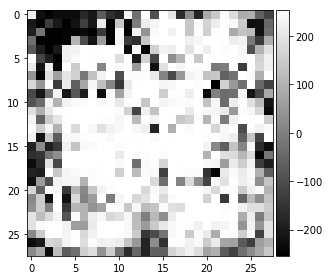

TARGET


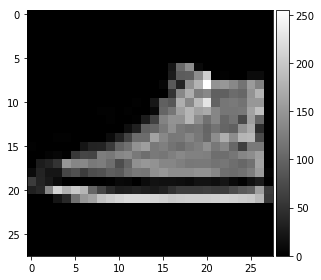

step  1000 / 1000 d_loss:  0.497432142496109 g_loss:  0.77249604
epoch 98 progress report:
latent shape:  (1, 100)
latent:  [[2.74149076e-01 6.30881519e-01 6.89423987e-01 2.87223487e-01
  9.12603532e-01 8.62646218e-01 9.47734468e-01 2.52595180e-01
  4.15115917e-01 9.51330556e-01 6.02783737e-01 4.96172184e-01
  5.18383897e-01 1.27887461e-01 5.34869335e-01 8.17340950e-01
  3.45994677e-01 9.39740365e-01 8.79810109e-01 2.57559926e-01
  4.05965150e-01 2.11952995e-01 4.73701027e-01 9.56569205e-01
  4.95170784e-01 4.24344179e-01 6.13907472e-01 2.93929725e-01
  9.69790781e-01 1.37902112e-02 8.63670916e-01 3.56948307e-02
  7.98369572e-01 7.77821535e-01 3.29690657e-01 5.53625351e-01
  2.34885003e-01 7.82546427e-01 5.14913280e-01 6.16965422e-01
  1.25057415e-01 3.38389744e-01 4.48368344e-01 4.39755127e-01
  6.87723573e-01 4.10548542e-01 2.49887922e-03 5.15875133e-01
  7.34164934e-01 8.14357645e-01 6.63269411e-03 4.34863149e-01
  9.20088706e-02 5.96211929e-01 6.21049521e-01 5.55735050e-01
  5.5549

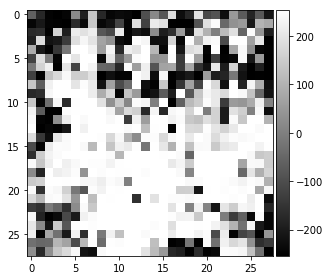

TARGET


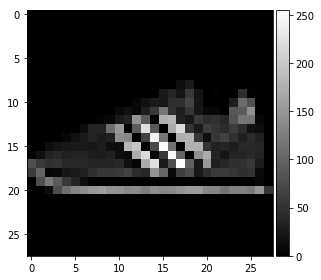

step  1000 / 1000 d_loss:  0.38616955280303955 g_loss:  0.7710884
epoch 99 progress report:
latent shape:  (1, 100)
latent:  [[0.98350161 0.81654215 0.69233976 0.82733095 0.38312245 0.89171842
  0.90339151 0.71644048 0.52759918 0.6865429  0.51573214 0.54490723
  0.5414613  0.50434158 0.1653389  0.05633639 0.76854058 0.65639155
  0.88920126 0.10231931 0.80436614 0.33922629 0.16146279 0.37357607
  0.65235087 0.40066154 0.12816478 0.19573623 0.09486139 0.86620036
  0.22343433 0.55912174 0.36236953 0.41706324 0.48822091 0.88867742
  0.32811062 0.9482282  0.35808494 0.49431399 0.78852044 0.6438624
  0.88963744 0.81154703 0.1841274  0.1908218  0.16553424 0.54534167
  0.33561535 0.62605965 0.17205731 0.62703243 0.62720645 0.30537618
  0.49777503 0.33430785 0.69519114 0.2375702  0.14748918 0.76090438
  0.93387535 0.67308146 0.94438766 0.49812805 0.03151129 0.32675131
  0.06971894 0.56061125 0.39173441 0.6703084  0.04295366 0.96975979
  0.20525439 0.80449837 0.97010142 0.43424066 0.5505908  0.7

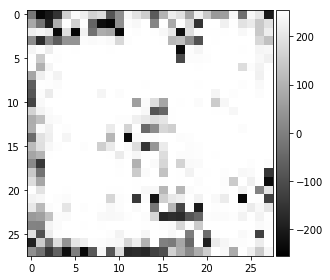

TARGET


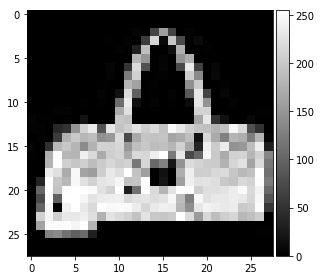

step  1000 / 1000 d_loss:  0.39528244733810425 g_loss:  0.7707949
epoch 100 progress report:
latent shape:  (1, 100)
latent:  [[0.89539933 0.81318312 0.81294281 0.80274751 0.74883118 0.13998389
  0.60775683 0.16973728 0.14690443 0.90991029 0.06508081 0.59751284
  0.03418896 0.94412623 0.96807419 0.59983089 0.73228392 0.50819201
  0.67989356 0.01564454 0.97329173 0.7527416  0.51611908 0.85834674
  0.95469886 0.14020229 0.63901626 0.57111201 0.15484774 0.65807506
  0.8446635  0.82395514 0.8014897  0.80429381 0.9179841  0.90399836
  0.6249907  0.21863489 0.95523388 0.12698546 0.93604098 0.728915
  0.19962657 0.43659203 0.26584416 0.1668845  0.08216067 0.65783596
  0.4778865  0.72658756 0.95303745 0.43182837 0.80274967 0.19013848
  0.12413761 0.42576427 0.69258784 0.24567356 0.17571343 0.4058117
  0.00623154 0.88936575 0.79106786 0.76209668 0.23935104 0.41446424
  0.84794242 0.00912004 0.70398206 0.30523099 0.90055914 0.07767601
  0.49201312 0.90870502 0.81714838 0.89442765 0.13716059 0.43

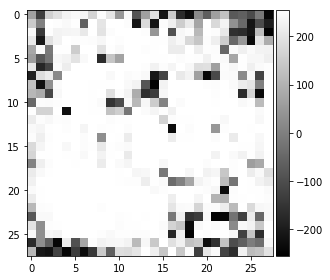

TARGET


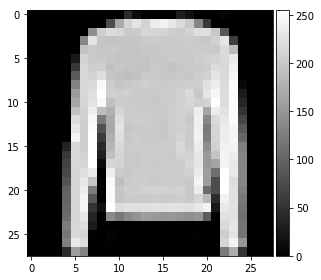

step  1000 / 1000 d_loss:  0.3972577452659607 g_loss:  0.7704939
epoch 101 progress report:
latent shape:  (1, 100)
latent:  [[0.49707936 0.54380847 0.28351899 0.43823451 0.45450757 0.48262624
  0.04299478 0.65934387 0.90869401 0.35761975 0.92744664 0.94202273
  0.00652701 0.9950266  0.26861218 0.19542067 0.0349566  0.12625052
  0.68546175 0.28598643 0.66946784 0.18075747 0.00115511 0.23660239
  0.52246686 0.97761583 0.18653556 0.64846459 0.58123172 0.6392469
  0.72685987 0.94810538 0.72877493 0.19106835 0.44474319 0.89399153
  0.79790524 0.90590531 0.97475882 0.30600095 0.0384606  0.58105042
  0.31997691 0.78318203 0.70292756 0.03471723 0.94446322 0.9371844
  0.16944534 0.69898959 0.89314545 0.53727508 0.81557348 0.65998154
  0.47158071 0.09801348 0.54831236 0.53893011 0.92334465 0.25700444
  0.11448842 0.33506631 0.35481237 0.52177153 0.8917396  0.83727764
  0.61619154 0.40322987 0.67076281 0.99719308 0.8172949  0.75579166
  0.74258552 0.0385967  0.76448377 0.45259322 0.29604058 0.48

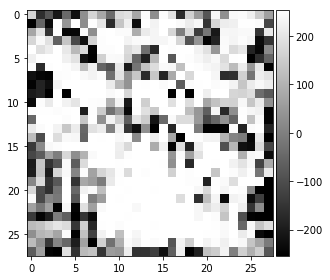

TARGET


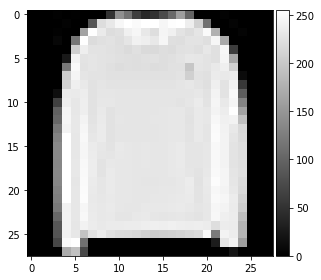

step  1000 / 1000 d_loss:  0.45389485359191895 g_loss:  0.7701949
epoch 102 progress report:
latent shape:  (1, 100)
latent:  [[0.71576004 0.9369827  0.23222583 0.35480068 0.48434235 0.52489194
  0.16734944 0.49709978 0.12772123 0.13947132 0.81672974 0.16671332
  0.75124119 0.73880129 0.88835521 0.25036938 0.1171642  0.01975704
  0.44669815 0.10127362 0.46454784 0.27152876 0.12914731 0.10136626
  0.74541192 0.64415356 0.34271969 0.90011088 0.68250834 0.32667405
  0.1441796  0.99867576 0.10427618 0.63716451 0.230532   0.24067885
  0.31185194 0.94072281 0.22150536 0.14578932 0.76446284 0.789144
  0.21197065 0.99321925 0.58970992 0.24394226 0.65500765 0.95969867
  0.90270281 0.94612257 0.70487181 0.61980491 0.3250433  0.79078409
  0.73848879 0.75329677 0.92127432 0.65472391 0.31580848 0.20101184
  0.35834358 0.72626159 0.9287658  0.62594292 0.36457155 0.16755375
  0.78751226 0.62808229 0.6960377  0.57224856 0.78605089 0.51656316
  0.42747986 0.63639347 0.85013252 0.73025406 0.26857141 0.5

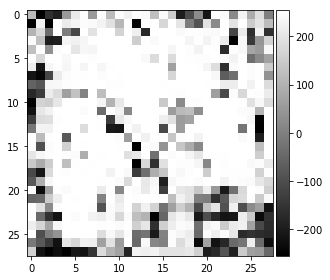

TARGET


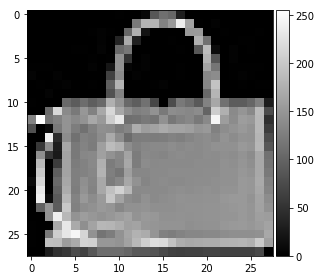

step  1000 / 1000 d_loss:  0.3863758146762848 g_loss:  0.76989263
epoch 103 progress report:
latent shape:  (1, 100)
latent:  [[0.17252487 0.89123508 0.86424813 0.85480972 0.0856105  0.7870697
  0.95351366 0.07119505 0.08155826 0.92510794 0.53332936 0.5411678
  0.80506613 0.77070804 0.30494843 0.38694819 0.48205765 0.17564301
  0.47267967 0.71436139 0.69983701 0.03909454 0.33773756 0.62737402
  0.58086851 0.49759963 0.31837515 0.47204927 0.72899341 0.15105445
  0.36395831 0.30109782 0.35954058 0.75622466 0.0034848  0.34465527
  0.10176102 0.5744119  0.27322594 0.01351782 0.3924621  0.756875
  0.76929645 0.37613308 0.94006628 0.34744635 0.05387935 0.3981025
  0.696127   0.33279698 0.07223989 0.52243867 0.94858317 0.65178107
  0.5779189  0.56966101 0.81901356 0.24344402 0.78414723 0.49926459
  0.28805208 0.6116935  0.298996   0.11006666 0.84167044 0.6755976
  0.45702319 0.82942508 0.11335297 0.532975   0.59321753 0.14934506
  0.09704145 0.25487277 0.08724662 0.91560205 0.26924425 0.18860

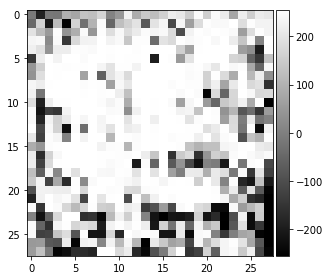

TARGET


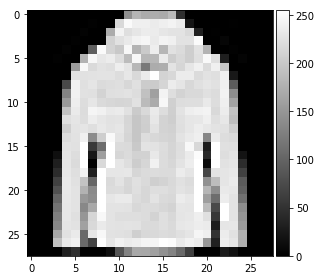

step  1000 / 1000 d_loss:  0.39700406789779663 g_loss:  0.7695851
epoch 104 progress report:
latent shape:  (1, 100)
latent:  [[0.63564624 0.20897356 0.73793198 0.18243061 0.59325149 0.13083601
  0.39268153 0.89388153 0.71025445 0.87107902 0.37042879 0.39338335
  0.27504692 0.12969399 0.76783505 0.14370256 0.63286446 0.6327403
  0.96805976 0.44541492 0.0567596  0.95484468 0.12930596 0.12640584
  0.97345249 0.1964075  0.99022385 0.23732171 0.87768768 0.95061407
  0.39810666 0.72416146 0.31798381 0.24769889 0.58368896 0.56066619
  0.34462098 0.79460145 0.57618934 0.45171582 0.25664805 0.0049878
  0.36539221 0.0676678  0.81355823 0.93882972 0.92006339 0.84604895
  0.61487852 0.63973581 0.41747775 0.97620193 0.50327663 0.31922725
  0.07166907 0.57358055 0.71307875 0.81067798 0.72145359 0.3298452
  0.53081857 0.93857616 0.37339252 0.85850747 0.56223273 0.18984803
  0.04458251 0.49492739 0.34521746 0.28550802 0.70717252 0.50866675
  0.9726238  0.79161232 0.54138774 0.90016281 0.66027228 0.86

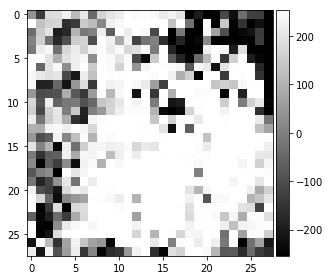

TARGET


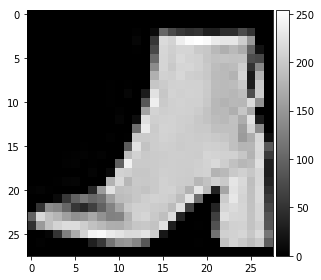

step  1000 / 1000 d_loss:  0.4516386091709137 g_loss:  0.7692709
epoch 105 progress report:
latent shape:  (1, 100)
latent:  [[0.72324113 0.61485496 0.62254878 0.39011324 0.16004863 0.27868637
  0.73014903 0.62725589 0.17501138 0.97540796 0.67877804 0.56872857
  0.42738823 0.7105735  0.06720235 0.93301609 0.99299418 0.82743733
  0.82342716 0.72400926 0.14459007 0.0751418  0.41916235 0.08295308
  0.2437409  0.37240627 0.46692824 0.45513645 0.43206661 0.40706529
  0.80659664 0.43391974 0.71013259 0.53940445 0.80645591 0.35269515
  0.01885317 0.03987904 0.31238769 0.77270458 0.35333594 0.42664121
  0.47738126 0.61536875 0.51232855 0.30372502 0.98229504 0.18061687
  0.70241767 0.98806741 0.44562575 0.64429037 0.05115863 0.07650334
  0.76813154 0.37281802 0.94803707 0.31483279 0.96487868 0.01055897
  0.83429942 0.13715554 0.96958519 0.09713455 0.72331889 0.41532143
  0.71575906 0.44227439 0.06348511 0.00345228 0.5095603  0.42053134
  0.9735423  0.62028731 0.59001817 0.50835921 0.82592629 0.

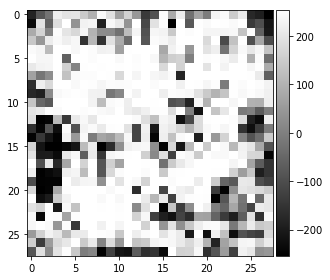

TARGET


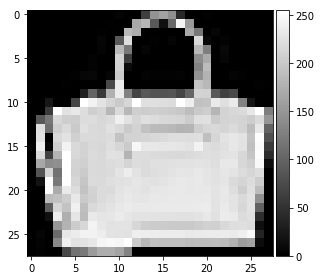

step  1000 / 1000 d_loss:  0.400177001953125 g_loss:  0.76895374
epoch 106 progress report:
latent shape:  (1, 100)
latent:  [[0.21284245 0.16346233 0.75086453 0.80965179 0.74416263 0.2603614
  0.64870159 0.62718087 0.56092293 0.40307174 0.10410959 0.94491261
  0.14055585 0.37809884 0.40806089 0.48901562 0.27151735 0.86120267
  0.79428863 0.88884452 0.66871582 0.62567742 0.4135257  0.42506766
  0.86021935 0.87452763 0.75441413 0.49801695 0.54237499 0.80305518
  0.79754916 0.93223553 0.26454109 0.53087647 0.02597288 0.11527677
  0.38868945 0.86923325 0.34441536 0.89032751 0.22937316 0.10090903
  0.98356975 0.60067507 0.53972359 0.95095787 0.96035863 0.12801504
  0.08377313 0.35509963 0.4088902  0.89865256 0.66979562 0.69656857
  0.90473382 0.95720379 0.65004814 0.22540627 0.44764982 0.18484134
  0.66889437 0.09729275 0.10814174 0.39322519 0.81516651 0.23683674
  0.20386487 0.5914957  0.67504114 0.68818031 0.90543574 0.45392969
  0.52477244 0.58927257 0.88730432 0.51895485 0.51709654 0.3

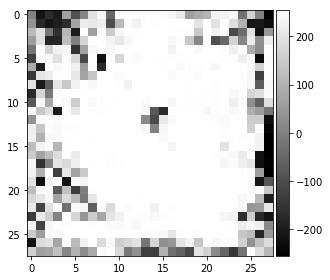

TARGET


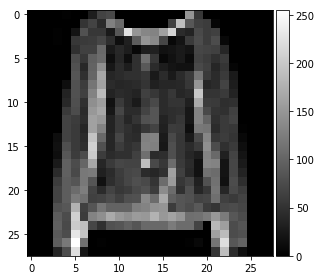

step  1000 / 1000 d_loss:  0.438176691532135 g_loss:  0.76864207
epoch 107 progress report:
latent shape:  (1, 100)
latent:  [[0.66736826 0.24222331 0.55351318 0.15857045 0.38114355 0.50731365
  0.84890985 0.09163787 0.09247051 0.87466854 0.34818555 0.62003786
  0.45599481 0.95898703 0.52331642 0.60232414 0.54029315 0.10596085
  0.96266898 0.73369793 0.03441227 0.47126511 0.30486998 0.42379768
  0.72707357 0.53627809 0.35805354 0.45757749 0.97289605 0.47126853
  0.01569634 0.87526889 0.71877472 0.76981809 0.47707519 0.39258524
  0.70558129 0.75907864 0.87627593 0.14605516 0.38758478 0.77805357
  0.9314168  0.51982317 0.63859078 0.59486302 0.02042172 0.58794681
  0.01051372 0.83278225 0.35085551 0.70603071 0.32214707 0.10194164
  0.10849909 0.86030691 0.40981393 0.69622153 0.2208888  0.51979015
  0.82241346 0.90159936 0.98522232 0.48522675 0.23331145 0.9156013
  0.7314169  0.94441862 0.65396272 0.25293868 0.49027888 0.98530487
  0.22974995 0.27253899 0.61088597 0.75979146 0.42229335 0.8

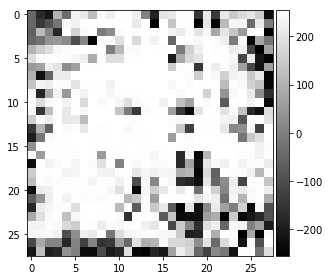

TARGET


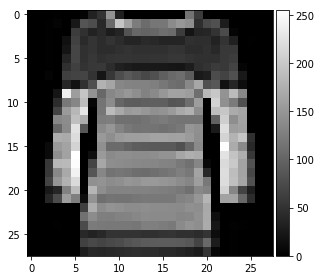

step  1000 / 1000 d_loss:  0.3846488893032074 g_loss:  0.7683303
epoch 108 progress report:
latent shape:  (1, 100)
latent:  [[0.01972671 0.62576538 0.66685439 0.10346845 0.61131215 0.5993595
  0.25785382 0.56420871 0.94370576 0.62055014 0.63702405 0.6152968
  0.83835618 0.27708594 0.49299477 0.46351642 0.40835336 0.5150947
  0.69551772 0.93269737 0.0484345  0.57809621 0.25460361 0.92050508
  0.15682196 0.46393268 0.29789615 0.01575252 0.93989832 0.19646382
  0.64957186 0.77084227 0.07116819 0.38214736 0.32998407 0.36913536
  0.69914275 0.02259205 0.07473131 0.55363857 0.81573174 0.18389303
  0.59458057 0.97200751 0.06388277 0.13254648 0.97249928 0.68789253
  0.46196669 0.80519193 0.24624658 0.57554359 0.18857715 0.39977155
  0.04093086 0.04292671 0.63921321 0.32395996 0.52824979 0.96192414
  0.54157836 0.06447332 0.97961665 0.20909619 0.94218617 0.49029972
  0.25152631 0.6540629  0.12648728 0.05828131 0.45401193 0.39333424
  0.1785404  0.97807056 0.88917025 0.26737433 0.92929728 0.948

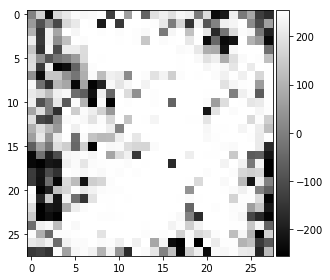

TARGET


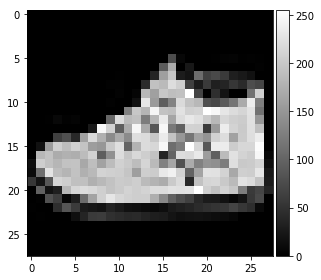

step  1000 / 1000 d_loss:  0.4840795695781708 g_loss:  0.7677721
epoch 109 progress report:
latent shape:  (1, 100)
latent:  [[0.16269814 0.08698411 0.35864896 0.65660875 0.99358987 0.15129169
  0.70155418 0.18688944 0.23206673 0.06841814 0.03549053 0.5665236
  0.18341571 0.80654443 0.50676434 0.89661398 0.84795407 0.26330101
  0.8925729  0.71871295 0.71904615 0.99889885 0.55479324 0.81307869
  0.11998731 0.04879406 0.29289336 0.33876224 0.71156918 0.93882032
  0.49469966 0.09560556 0.86358539 0.31641604 0.51711742 0.83436909
  0.65485487 0.17101926 0.6061111  0.76454479 0.93650604 0.24929394
  0.34319474 0.06585307 0.74860451 0.28036086 0.59670837 0.25876625
  0.73494393 0.93215229 0.35678245 0.60082044 0.74239253 0.43640634
  0.62399516 0.11062586 0.89127448 0.69631604 0.23346063 0.85202286
  0.8526355  0.87241511 0.07650431 0.34902384 0.89031935 0.93720091
  0.60807129 0.66284029 0.0207851  0.4640036  0.67269198 0.29944365
  0.16241799 0.13793099 0.03674738 0.22761887 0.33026307 0.4

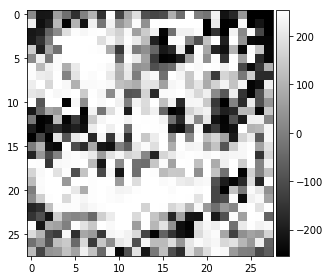

TARGET


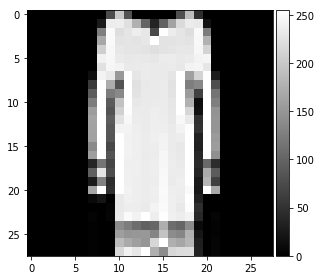

step  1000 / 1000 d_loss:  0.44287553429603577 g_loss:  0.76730144
epoch 110 progress report:
latent shape:  (1, 100)
latent:  [[0.10016779 0.7499793  0.65156049 0.45927929 0.38492402 0.81650375
  0.92727592 0.9773855  0.65428573 0.05289261 0.62135924 0.59168009
  0.76170487 0.02001885 0.70075851 0.97939932 0.66083586 0.07434559
  0.50363231 0.38215608 0.78610299 0.3860578  0.78524492 0.72807733
  0.34995834 0.78017077 0.76628848 0.32261059 0.19312612 0.07135869
  0.27308032 0.96900384 0.314002   0.31636659 0.27539155 0.23932521
  0.70631241 0.27407494 0.66972468 0.32367436 0.83086799 0.67672088
  0.43681484 0.73238799 0.81515104 0.10249358 0.60019205 0.12776307
  0.03323512 0.03204717 0.72795779 0.90828972 0.52733506 0.22348061
  0.69845605 0.63597531 0.15553646 0.83645736 0.70552611 0.24159006
  0.01279106 0.72749741 0.21784356 0.69034183 0.46613507 0.58680639
  0.97841491 0.93923395 0.16736342 0.44932151 0.21847493 0.14064601
  0.55173419 0.54533089 0.35213897 0.68821314 0.65966845 

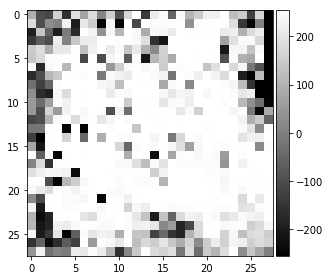

TARGET


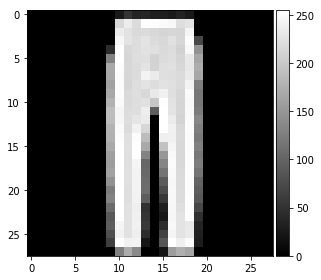

step  1000 / 1000 d_loss:  0.4530242085456848 g_loss:  0.7670642
epoch 111 progress report:
latent shape:  (1, 100)
latent:  [[0.41963609 0.23925963 0.13603704 0.41460922 0.40067636 0.61683854
  0.42789694 0.60098826 0.58607953 0.94125412 0.50921215 0.60900824
  0.71092522 0.58422117 0.39582897 0.09191631 0.19244057 0.89120159
  0.08805571 0.40612432 0.12232913 0.84779609 0.19095835 0.8212897
  0.39490324 0.74705311 0.86466026 0.0166569  0.44063658 0.49044271
  0.99784752 0.00175953 0.27034057 0.05832835 0.28947143 0.26591003
  0.94991951 0.18373617 0.15311354 0.38564362 0.30722434 0.02766985
  0.32058951 0.5844641  0.18913521 0.61313842 0.31677731 0.54529478
  0.01877646 0.98740343 0.17046158 0.87856834 0.22775485 0.96586185
  0.93520602 0.51386382 0.61317856 0.79081649 0.50032506 0.26768046
  0.64540992 0.37379523 0.5658577  0.80452748 0.55959073 0.86469979
  0.51641737 0.10632971 0.04645532 0.83262833 0.32252036 0.4716062
  0.78291411 0.68143177 0.43774783 0.57607829 0.70437831 0.37

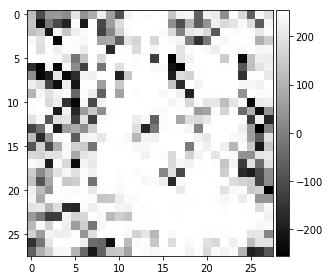

TARGET


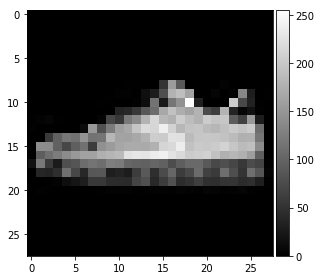

step  1000 / 1000 d_loss:  0.39831140637397766 g_loss:  0.7668174
epoch 112 progress report:
latent shape:  (1, 100)
latent:  [[0.2436699  0.1629592  0.21446041 0.06188646 0.10149793 0.14478982
  0.42226015 0.30119262 0.29470614 0.91642895 0.54008326 0.39806512
  0.64284934 0.99395276 0.09639471 0.30055351 0.66198314 0.88817011
  0.30678109 0.42211055 0.5560965  0.98476802 0.53247955 0.91593685
  0.51228434 0.08329809 0.96933724 0.01815329 0.86487617 0.12093066
  0.14208583 0.39438196 0.32686278 0.18063597 0.94582547 0.68030248
  0.64256883 0.91729148 0.61109201 0.53725971 0.2398344  0.8276269
  0.84542973 0.41619899 0.3077059  0.92782492 0.26067604 0.49217561
  0.78562929 0.34303023 0.07766366 0.13239253 0.46341934 0.6498706
  0.80390046 0.46548776 0.69397135 0.01142912 0.62753463 0.81863205
  0.09959984 0.16835196 0.6806738  0.95435956 0.11390109 0.76343556
  0.15984936 0.70459928 0.74672847 0.47308632 0.72897243 0.30125527
  0.53213508 0.7553965  0.16158341 0.24410987 0.77951462 0.1

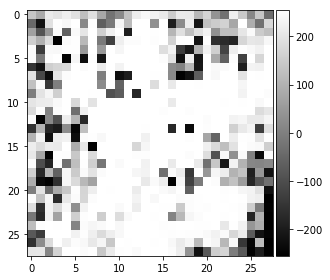

TARGET


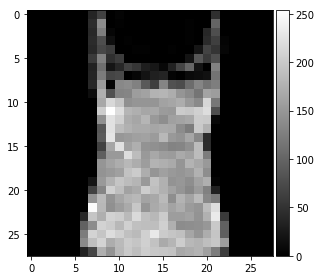

step  1000 / 1000 d_loss:  0.39131441712379456 g_loss:  0.7665575
epoch 113 progress report:
latent shape:  (1, 100)
latent:  [[0.6504426  0.49137277 0.63835336 0.94898201 0.43512084 0.26076747
  0.09475817 0.04882252 0.23091069 0.39146634 0.58068346 0.65305383
  0.50831648 0.92735832 0.24391848 0.9782033  0.38959278 0.57505184
  0.52115286 0.7025203  0.80943385 0.33080038 0.69735988 0.7578236
  0.49608262 0.04569797 0.73086191 0.81229749 0.53246243 0.22947105
  0.7560543  0.49345048 0.14578553 0.28334832 0.33107567 0.82103428
  0.27128292 0.15802219 0.92764075 0.10771205 0.1000216  0.01815845
  0.62389928 0.58590856 0.13796744 0.60121152 0.52586388 0.22649079
  0.96074307 0.22863681 0.29888271 0.53928875 0.71829027 0.33459712
  0.83407535 0.63853175 0.71356263 0.49676095 0.06914911 0.0356051
  0.68228765 0.67339144 0.30003704 0.3914055  0.64616979 0.10998208
  0.9090238  0.36441608 0.95477134 0.10143256 0.29125012 0.45576174
  0.21814233 0.34400679 0.45335674 0.17006108 0.23388781 0.4

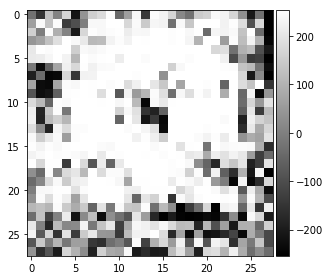

TARGET


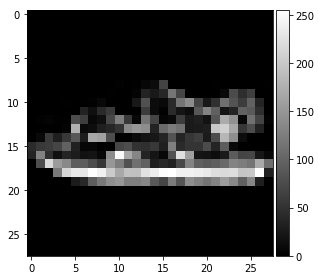

step  1000 / 1000 d_loss:  0.4152533710002899 g_loss:  0.7662812
epoch 114 progress report:
latent shape:  (1, 100)
latent:  [[0.97194284 0.67614646 0.53064884 0.27446736 0.10647577 0.4567485
  0.90485606 0.28186172 0.6812692  0.50150149 0.85928801 0.47410156
  0.00674976 0.52254831 0.65211779 0.12602742 0.92681323 0.53688646
  0.08698908 0.15463884 0.63019883 0.13094335 0.56739209 0.41076334
  0.59058414 0.97457576 0.72330736 0.70137606 0.58034621 0.6760386
  0.24892966 0.04765269 0.54657899 0.04684102 0.33816717 0.91354903
  0.20551715 0.09750723 0.88791091 0.98732843 0.10412286 0.72503106
  0.57373885 0.14605156 0.71906579 0.89762086 0.40368353 0.50451702
  0.3995766  0.28235965 0.0282875  0.81378078 0.2159131  0.38729499
  0.15304705 0.21408197 0.23192769 0.85750462 0.2741936  0.65104027
  0.10430725 0.39338022 0.14876611 0.21007054 0.7725499  0.96328937
  0.56909284 0.70671454 0.78614969 0.06116075 0.33373726 0.27300679
  0.29980696 0.36480556 0.01348974 0.01959666 0.50773933 0.02

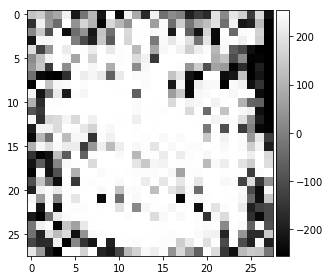

TARGET


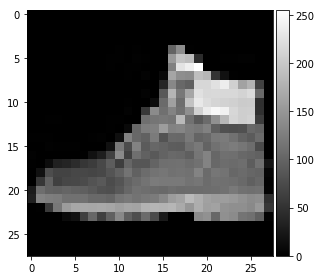

step  1000 / 1000 d_loss:  0.38398277759552 g_loss:  0.76579076
epoch 115 progress report:
latent shape:  (1, 100)
latent:  [[0.70297886 0.62232825 0.47629682 0.70287453 0.22956156 0.03351023
  0.61741097 0.80749971 0.35629316 0.41359039 0.81594209 0.11501871
  0.11205474 0.48271259 0.29748679 0.15922779 0.83398554 0.34586144
  0.95795148 0.62906722 0.58756496 0.70354817 0.97132081 0.6550362
  0.1360367  0.92391564 0.401647   0.60144428 0.4508148  0.65062659
  0.61346479 0.0319392  0.6984572  0.41221661 0.79016895 0.63451285
  0.56233136 0.51821612 0.33773628 0.40968429 0.19287982 0.78243504
  0.69314363 0.3268055  0.72117968 0.71069154 0.31826554 0.96486984
  0.73918331 0.38262379 0.5515817  0.68414974 0.80980869 0.82030972
  0.77727627 0.32392059 0.32950731 0.52730671 0.05930765 0.93768927
  0.22738008 0.97783449 0.82459788 0.5353256  0.70615943 0.13234075
  0.64482396 0.04010935 0.07928879 0.28744695 0.65456858 0.81031296
  0.73301972 0.33926119 0.53307262 0.49300067 0.87656829 0.70

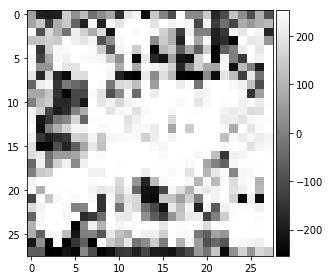

TARGET


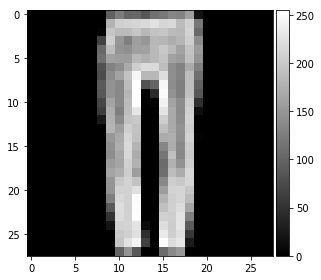

step  1000 / 1000 d_loss:  0.3830054700374603 g_loss:  0.7654902
epoch 116 progress report:
latent shape:  (1, 100)
latent:  [[0.66005995 0.1987273  0.22125136 0.8445047  0.77306124 0.73423531
  0.01894064 0.59667636 0.58205811 0.62762907 0.6399726  0.54252722
  0.81178978 0.69203451 0.88593009 0.6352798  0.38177921 0.39383815
  0.62985043 0.8060626  0.41226209 0.39905572 0.94972656 0.89151984
  0.21830963 0.70147001 0.77122558 0.05320502 0.52491569 0.95761081
  0.08820673 0.91129896 0.69070166 0.59039691 0.61789833 0.34264721
  0.45574295 0.57047469 0.00308696 0.61579095 0.83328818 0.43863453
  0.34359419 0.21347684 0.19101059 0.89461013 0.09733312 0.76407485
  0.04359343 0.91223493 0.22199074 0.25099851 0.01032294 0.83184119
  0.4357391  0.7986886  0.953129   0.24483288 0.34273959 0.53380986
  0.82540636 0.52076461 0.63175353 0.947468   0.69860664 0.80411264
  0.80628265 0.84332486 0.98173846 0.09357073 0.25512033 0.64417512
  0.28091963 0.32916462 0.26670614 0.22830883 0.4393395  0.

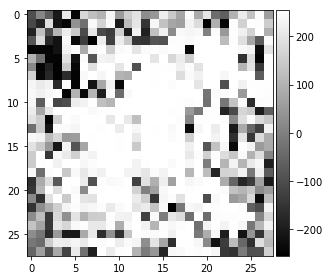

TARGET


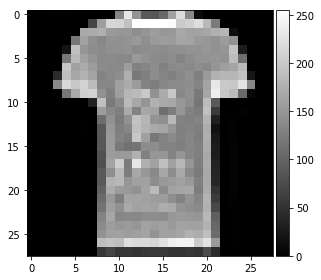

step  1000 / 1000 d_loss:  0.41782695055007935 g_loss:  0.7652072
epoch 117 progress report:
latent shape:  (1, 100)
latent:  [[0.30088547 0.26689151 0.34070675 0.17310073 0.34601314 0.53363913
  0.54898538 0.16987914 0.30687596 0.90498266 0.40412646 0.50821122
  0.17482779 0.01303894 0.5353214  0.15703413 0.88805846 0.47742897
  0.78244964 0.62449395 0.03970698 0.12801757 0.86164245 0.99075883
  0.86509974 0.82209853 0.25901376 0.62234075 0.8392822  0.09007303
  0.58004686 0.28490154 0.0448992  0.67773705 0.28152549 0.87949344
  0.2136895  0.38991872 0.67533242 0.97418488 0.72313742 0.94335934
  0.75377869 0.66125732 0.2457972  0.46537833 0.35846051 0.13917862
  0.61860633 0.9978267  0.20286028 0.81831238 0.80884771 0.52794598
  0.25165324 0.49448891 0.59903302 0.39827837 0.20920712 0.15193129
  0.90839355 0.13038479 0.59890726 0.82617804 0.72920789 0.70063735
  0.96765721 0.87631568 0.39844469 0.64776733 0.73718616 0.61537061
  0.20304562 0.86778848 0.54601641 0.42123414 0.75251126 0

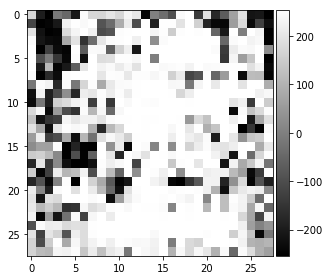

TARGET


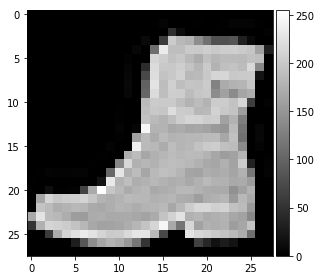

step  1000 / 1000 d_loss:  0.3840818405151367 g_loss:  0.7649204
epoch 118 progress report:
latent shape:  (1, 100)
latent:  [[6.28361120e-01 7.28878637e-01 6.70198458e-02 6.17861853e-01
  1.32956447e-01 2.34945926e-02 4.42812888e-01 4.63846934e-01
  9.77569133e-01 7.36226641e-01 5.55379680e-01 6.82231016e-01
  9.25577548e-01 9.54159125e-01 8.43256972e-01 6.72019051e-02
  5.23213068e-01 3.00987342e-02 2.16647527e-02 7.36641276e-01
  3.64442864e-01 7.65025939e-01 3.31893642e-01 4.43015142e-01
  1.25241191e-01 1.11359178e-02 6.17527923e-01 1.64518528e-01
  4.02916899e-01 2.22149686e-01 3.72399536e-01 2.17055320e-01
  1.84687857e-01 2.68303889e-01 9.74219246e-01 6.83212240e-02
  1.20049857e-01 2.81345941e-01 2.62913132e-01 8.88254108e-01
  5.32280811e-01 1.26974398e-01 2.23388297e-01 3.64439091e-01
  2.28675609e-01 9.45984533e-01 1.02159372e-01 1.48197391e-01
  3.89312900e-01 7.06896616e-01 4.20942035e-01 3.47422062e-01
  8.74794214e-01 4.81604373e-01 5.80234323e-01 4.32917969e-01
  8.084

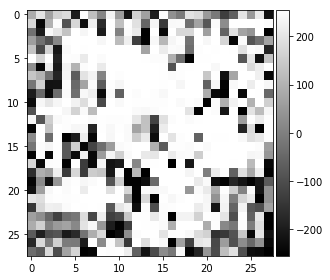

TARGET


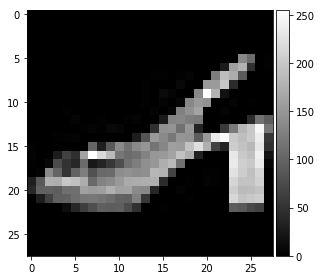

step  1000 / 1000 d_loss:  0.4909908175468445 g_loss:  0.76462567
epoch 119 progress report:
latent shape:  (1, 100)
latent:  [[0.21539992 0.89526295 0.17353938 0.08132237 0.34744672 0.49745938
  0.30271041 0.86969501 0.04157034 0.19914318 0.34692452 0.16774975
  0.43255483 0.73821128 0.46494604 0.89360449 0.32324603 0.52321404
  0.36073383 0.61955446 0.59817494 0.31353978 0.42365556 0.82407081
  0.82114004 0.17563147 0.39788818 0.70036504 0.48628613 0.10358612
  0.69453567 0.28236336 0.02932373 0.98959799 0.18656856 0.64659232
  0.82792584 0.48144287 0.41175854 0.56153219 0.11379615 0.13027509
  0.71429617 0.02146365 0.15765642 0.4846227  0.27614624 0.4623706
  0.99657123 0.72422072 0.86303853 0.61998727 0.24324853 0.95801529
  0.21098391 0.47690779 0.66380202 0.59650374 0.05720217 0.78935761
  0.78466636 0.13656231 0.93545506 0.24768029 0.50186967 0.49543997
  0.47520813 0.302718   0.53834112 0.33581931 0.95356066 0.31407636
  0.37882028 0.42802514 0.54249755 0.01887941 0.88566233 0.

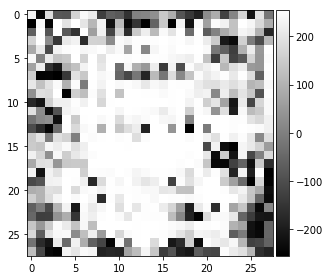

TARGET


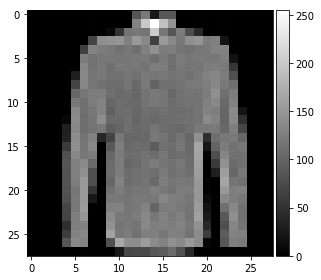

step  1000 / 1000 d_loss:  0.38286933302879333 g_loss:  0.76433015
epoch 120 progress report:
latent shape:  (1, 100)
latent:  [[0.90471895 0.67061865 0.09476731 0.8975069  0.38113933 0.8318406
  0.52300504 0.61883534 0.08236469 0.19490019 0.15652235 0.04184441
  0.81700855 0.13806854 0.75492037 0.49989983 0.95492922 0.70229084
  0.6045026  0.55283763 0.15940183 0.01915043 0.98474335 0.26569153
  0.05670458 0.91323117 0.98179024 0.3504819  0.09072364 0.99004705
  0.5529298  0.32023106 0.62109096 0.39982681 0.94448799 0.76833379
  0.02564893 0.78830918 0.27532775 0.74788283 0.71557682 0.42474737
  0.53869103 0.853594   0.10298136 0.80218492 0.93177386 0.52323717
  0.71411609 0.03774939 0.41495296 0.68462774 0.57882511 0.71017545
  0.95161322 0.57459981 0.35443074 0.73373892 0.03134232 0.41460716
  0.08240087 0.46560368 0.91820679 0.84559023 0.16143003 0.22807832
  0.25222889 0.02813498 0.70887277 0.39920672 0.2827195  0.7943789
  0.03265675 0.05572656 0.86609274 0.88814023 0.97559833 0.

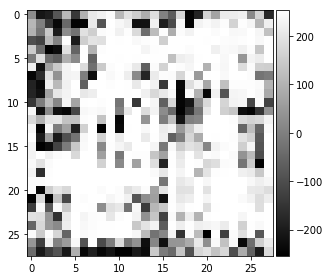

TARGET


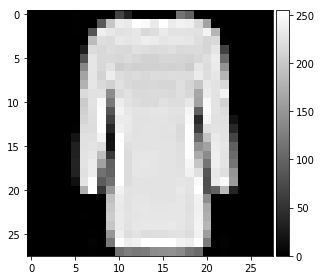

step  1000 / 1000 d_loss:  0.4151647388935089 g_loss:  0.76219225
epoch 121 progress report:
latent shape:  (1, 100)
latent:  [[0.39325244 0.26660605 0.15398768 0.14065102 0.32812909 0.67713183
  0.89338127 0.06803649 0.55177785 0.07147945 0.37575362 0.32656886
  0.6352082  0.53577362 0.55627304 0.11666558 0.88510124 0.61335159
  0.11221293 0.76619105 0.44141152 0.62550372 0.68267617 0.72879674
  0.08064977 0.28302504 0.19563276 0.49944571 0.66964396 0.28568826
  0.6339495  0.82890382 0.3868029  0.42174437 0.16260311 0.84272506
  0.61324425 0.66489879 0.73043912 0.5542577  0.94196495 0.01542625
  0.63886609 0.58824433 0.82557675 0.59085238 0.2307578  0.09876169
  0.90199776 0.68616545 0.7301434  0.04128916 0.2529781  0.98551265
  0.68927177 0.79684181 0.76470763 0.67447809 0.82911375 0.61730462
  0.19290839 0.84747721 0.16890021 0.9137876  0.2483017  0.66720625
  0.93313252 0.45944029 0.60326983 0.06085694 0.12545679 0.13992257
  0.03768685 0.97294613 0.77247524 0.91692763 0.81879993 0

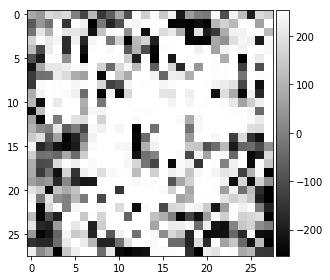

TARGET


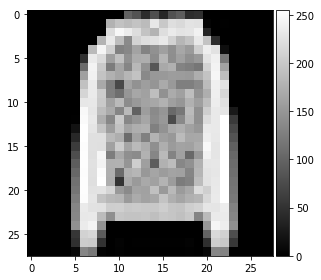

step  1000 / 1000 d_loss:  0.3807394504547119 g_loss:  0.7611401
epoch 122 progress report:
latent shape:  (1, 100)
latent:  [[0.07589118 0.62863804 0.7567027  0.18518452 0.69316078 0.009317
  0.41655268 0.77788131 0.54026653 0.01107429 0.95699488 0.84856066
  0.90935826 0.75512409 0.15077632 0.01084946 0.69726765 0.22526908
  0.84757654 0.17553199 0.11889711 0.6351931  0.81492339 0.98613994
  0.75325289 0.44857955 0.75715173 0.76179655 0.1369456  0.80530022
  0.68404429 0.13882547 0.42618861 0.26460074 0.11031599 0.93716149
  0.82706514 0.85567356 0.39425898 0.45649498 0.4390209  0.03416721
  0.07741965 0.10470666 0.47075538 0.30517338 0.1752157  0.87486779
  0.62665394 0.40135508 0.53422983 0.61752308 0.64481199 0.27414743
  0.44564653 0.83873085 0.92619358 0.73844017 0.92067441 0.5897459
  0.07165089 0.92222358 0.12455787 0.66971768 0.8810281  0.01984544
  0.8609421  0.36230356 0.24998661 0.65676447 0.13577678 0.16909598
  0.7159611  0.54056978 0.56264715 0.35216149 0.90954126 0.733

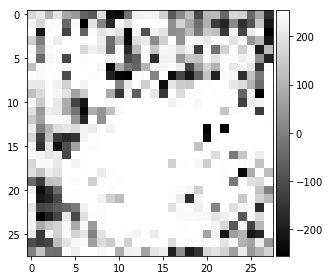

TARGET


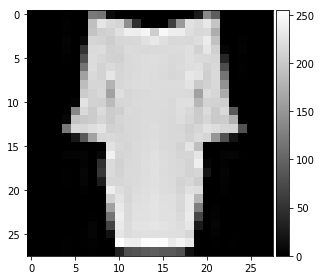

step  1000 / 1000 d_loss:  0.3937489092350006 g_loss:  0.7608648
epoch 123 progress report:
latent shape:  (1, 100)
latent:  [[0.28573082 0.7644925  0.85727071 0.8923551  0.88772493 0.94410833
  0.26030365 0.08451008 0.02120339 0.41820936 0.56800582 0.38917681
  0.00524196 0.59699862 0.76201114 0.62313457 0.44000872 0.88583347
  0.6621114  0.70073545 0.0667752  0.08421198 0.30613137 0.62857902
  0.47470378 0.56677738 0.5551192  0.20451363 0.78122113 0.3516933
  0.54976036 0.73739945 0.59227012 0.11362497 0.9072703  0.99846414
  0.07520249 0.81392785 0.86599106 0.53803405 0.21669326 0.11266402
  0.39128434 0.58758427 0.53362067 0.82705133 0.25884815 0.52027722
  0.18603285 0.59652461 0.8324808  0.13401689 0.98348527 0.29348284
  0.08014349 0.1644683  0.49481434 0.46100066 0.3455746  0.71199541
  0.3454515  0.59406847 0.58363582 0.89219121 0.76442851 0.93120236
  0.24953863 0.08357341 0.42053865 0.01495132 0.30019343 0.01140003
  0.15840737 0.54424867 0.79916431 0.58487697 0.20104487 0.6

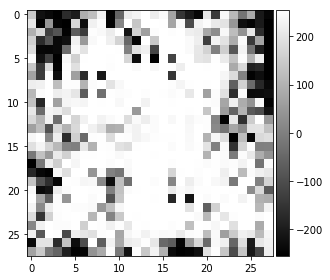

TARGET


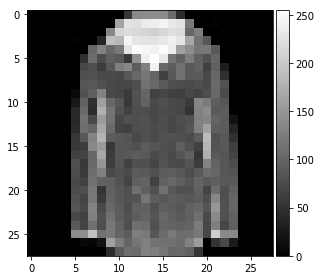

step  1000 / 1000 d_loss:  0.3810637593269348 g_loss:  0.7603706
epoch 124 progress report:
latent shape:  (1, 100)
latent:  [[0.84672266 0.16814314 0.03597892 0.69031725 0.1913128  0.04106445
  0.9761075  0.64197721 0.51009199 0.33495569 0.98861044 0.23537154
  0.00354062 0.31592671 0.95169689 0.61779401 0.5340334  0.79911398
  0.34907529 0.10079503 0.42583876 0.01199025 0.11541091 0.78745998
  0.27444138 0.38976546 0.19270466 0.86740902 0.25134785 0.70251811
  0.60090534 0.90686562 0.76851284 0.64475567 0.87717164 0.04971912
  0.74038835 0.01768642 0.0890047  0.07399378 0.31770155 0.01045654
  0.13859733 0.60026734 0.22981271 0.91172757 0.93581583 0.77047809
  0.88268944 0.56617104 0.65628003 0.31897408 0.08707441 0.07258536
  0.93388105 0.26850246 0.2763596  0.63005403 0.81550198 0.90235715
  0.47627644 0.00126246 0.98858473 0.24388867 0.0809275  0.78569867
  0.37676853 0.37618912 0.42524656 0.33458273 0.53646374 0.88245046
  0.6229218  0.75665767 0.78960941 0.71004082 0.70107975 0.

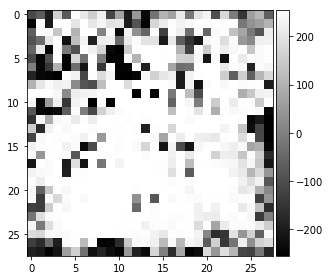

TARGET


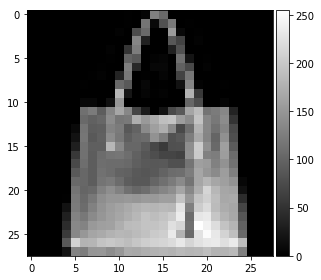

step  1000 / 1000 d_loss:  0.4137401580810547 g_loss:  0.76009667
epoch 125 progress report:
latent shape:  (1, 100)
latent:  [[6.51777759e-02 5.99387526e-01 5.54226855e-01 4.45748074e-01
  5.77955249e-01 8.40343538e-01 8.59669380e-01 8.84932663e-01
  3.11708950e-01 6.23329747e-01 3.93743146e-01 7.21669543e-01
  9.96336220e-01 4.47700989e-02 7.31137889e-01 4.96199973e-02
  1.59066173e-01 2.25015638e-01 9.06094731e-01 7.33014216e-01
  6.71194295e-01 3.56048726e-01 3.54687201e-01 4.66468245e-01
  3.36892757e-01 5.16106466e-01 2.01541431e-01 2.62159524e-02
  8.97494052e-01 9.58241243e-01 1.88147433e-02 8.15145438e-01
  2.27174790e-01 3.35729197e-01 1.67386876e-01 7.68217455e-01
  7.26943756e-01 9.81755068e-01 1.39233329e-01 5.64847248e-01
  4.78575444e-01 7.61296409e-01 9.38879679e-01 4.43894841e-01
  6.38753492e-01 2.15695700e-01 8.78775833e-01 7.84006467e-01
  1.44095323e-01 8.36246280e-01 1.23586723e-01 8.09427618e-01
  2.36879413e-01 5.33602312e-01 5.56617379e-01 1.90043586e-02
  4.81

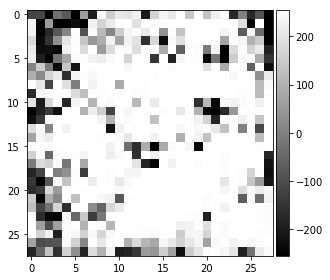

TARGET


step  1000 / 1000 d_loss:  0.3920879364013672 g_loss:  0.75958693
epoch 126 progress report:
latent shape:  (1, 100)
latent:  [[0.37963882 0.4554351  0.67377563 0.07187849 0.09598431 0.36234435
  0.58228576 0.64798506 0.30334402 0.51705032 0.93356372 0.40176239
  0.27322717 0.81697776 0.43380242 0.62436099 0.32040145 0.28369565
  0.75145555 0.20789936 0.35041046 0.21461014 0.10263325 0.64314064
  0.41146007 0.00597674 0.49986316 0.00735007 0.26561161 0.75170765
  0.38834759 0.28998614 0.99968019 0.79084865 0.7103888  0.78094654
  0.32415679 0.70909091 0.2064431  0.88214451 0.10915748 0.99391218
  0.73556982 0.39274693 0.09114601 0.05060667 0.54025135 0.86893183
  0.74382514 0.14848048 0.97835461 0.30552594 0.42379506 0.63019522
  0.65998527 0.34898683 0.11841635 0.39214142 0.24121509 0.54779444
  0.30902874 0.32202796 0.9926401  0.63702425 0.36864061 0.04299498
  0.43164921 0.94185033 0.38477776 0.24513243 0.51089439 0.13655756
  0.79159687 0.16786435 0.30217389 0.50007527 0.84645062 0

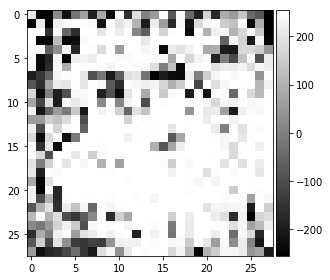

TARGET


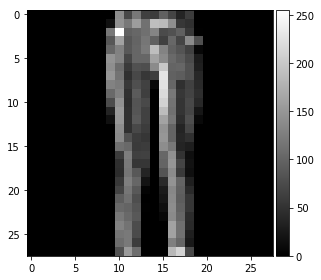

step  1000 / 1000 d_loss:  0.4604295492172241 g_loss:  0.7591102
epoch 127 progress report:
latent shape:  (1, 100)
latent:  [[0.45050332 0.4436641  0.55293446 0.3453682  0.77554768 0.52249745
  0.34887066 0.02530773 0.22352115 0.56069075 0.20782707 0.13957272
  0.8840451  0.2369087  0.90609987 0.66961298 0.74537911 0.9946633
  0.2449185  0.77924019 0.38270768 0.06986259 0.92188671 0.27797101
  0.42436189 0.0150319  0.25036893 0.89360866 0.19435483 0.72644963
  0.66758176 0.44180805 0.20263102 0.53766545 0.35151446 0.6055681
  0.86405458 0.67702746 0.73586178 0.86070559 0.06461799 0.35833138
  0.42211641 0.720802   0.79199807 0.6981122  0.75079872 0.80795825
  0.16465701 0.9124471  0.10944998 0.86663505 0.95248772 0.4526835
  0.50751255 0.51054675 0.35302073 0.14424156 0.10892538 0.8889119
  0.46964852 0.08591885 0.33612779 0.88182591 0.22291758 0.14754278
  0.61107648 0.05485376 0.70397086 0.59237679 0.69307617 0.0612595
  0.15163358 0.33549775 0.27682073 0.42332841 0.74083404 0.56913

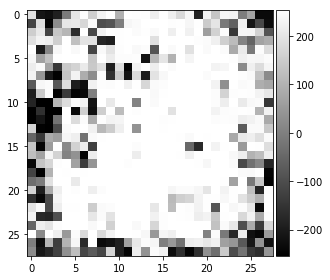

TARGET


step  1000 / 1000 d_loss:  0.3983598053455353 g_loss:  0.7588688
epoch 128 progress report:
latent shape:  (1, 100)
latent:  [[0.22529445 0.55002353 0.58562139 0.24747847 0.43775666 0.48164911
  0.55553003 0.19237914 0.79165959 0.19163775 0.20914158 0.0079179
  0.29362151 0.39089449 0.08793227 0.263196   0.13828857 0.41416403
  0.94016154 0.58075112 0.78830909 0.32064106 0.66274161 0.74296491
  0.22530338 0.55250772 0.68936287 0.37406131 0.05005523 0.20995373
  0.30300321 0.74719129 0.29483559 0.43753482 0.93386914 0.61707246
  0.22873454 0.03045142 0.61040259 0.7605183  0.44066111 0.11828981
  0.18881605 0.98005562 0.64246442 0.69801422 0.15902744 0.60730579
  0.2300628  0.51499427 0.80764869 0.20132346 0.19905132 0.93707031
  0.4363564  0.51696383 0.77490659 0.0065408  0.90103737 0.6716112
  0.59597025 0.31123078 0.70993706 0.84056735 0.43317977 0.65470855
  0.13202796 0.23248095 0.74126531 0.70220787 0.77309988 0.93388261
  0.56139304 0.19342092 0.73018117 0.98007341 0.12316855 0.21

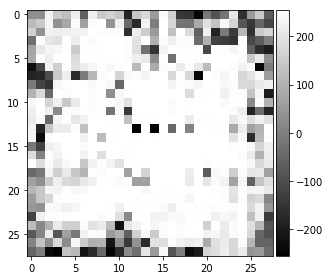

TARGET


step  1000 / 1000 d_loss:  0.3814775049686432 g_loss:  0.7586126
epoch 129 progress report:
latent shape:  (1, 100)
latent:  [[0.88743991 0.85286283 0.22961037 0.70238865 0.6249991  0.33292296
  0.62270531 0.00686603 0.97215397 0.11191609 0.78497155 0.27003366
  0.11002887 0.48879909 0.02502276 0.63128726 0.88342897 0.90036048
  0.20898833 0.79992983 0.77271271 0.4097558  0.57084891 0.6683652
  0.02522942 0.53884018 0.02718709 0.47534833 0.38053222 0.62699118
  0.05982301 0.30567036 0.96606432 0.2123848  0.07901502 0.85218762
  0.70269803 0.05869571 0.27613592 0.12348741 0.96599734 0.26820504
  0.54205412 0.40267159 0.83114912 0.56803824 0.50380349 0.72273107
  0.60103753 0.65780966 0.06213597 0.72763654 0.56280005 0.30764486
  0.87831875 0.54932632 0.93549181 0.67586853 0.82569774 0.35357027
  0.9984634  0.25731003 0.13328669 0.90264257 0.25896996 0.92431858
  0.98107432 0.34762386 0.5415146  0.51129326 0.32678662 0.8296185
  0.9690875  0.82534474 0.19445815 0.0049792  0.80986853 0.70

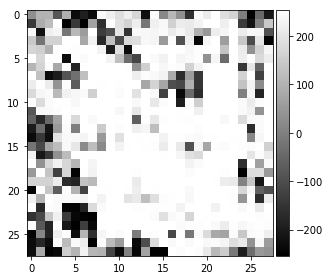

TARGET


step  1000 / 1000 d_loss:  0.3880910277366638 g_loss:  0.75774336
epoch 130 progress report:
latent shape:  (1, 100)
latent:  [[0.50303232 0.83979716 0.37084525 0.36118587 0.8153753  0.20950349
  0.68399535 0.24451489 0.31769825 0.7624794  0.91122481 0.32221621
  0.97612823 0.01376464 0.73333231 0.43720567 0.14941916 0.39026647
  0.55181605 0.97532121 0.21590113 0.41821075 0.96814346 0.43390873
  0.094006   0.64214285 0.3469753  0.38764601 0.86141576 0.42381802
  0.48097311 0.25199847 0.13714395 0.23431307 0.79335715 0.30675918
  0.93482082 0.5530732  0.37042965 0.02022168 0.37806567 0.16819341
  0.14217888 0.88124487 0.94897852 0.45113846 0.98607538 0.81198306
  0.91390027 0.38217907 0.9336601  0.59511199 0.16961582 0.20971489
  0.6678508  0.6740518  0.57101344 0.03949391 0.1074823  0.93266427
  0.64468199 0.92149592 0.49567131 0.82492374 0.07691578 0.48391185
  0.23195016 0.03984681 0.9999663  0.64180646 0.94994846 0.5091997
  0.17266837 0.40429888 0.93714995 0.74003143 0.31475652 0.

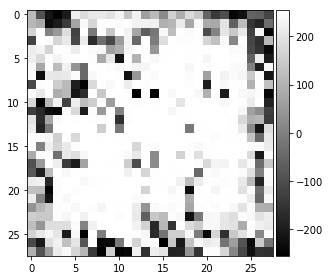

TARGET


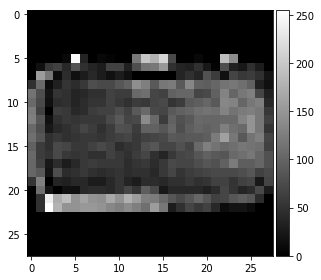

step  1000 / 1000 d_loss:  0.3948686122894287 g_loss:  0.7574328
epoch 131 progress report:
latent shape:  (1, 100)
latent:  [[0.06455474 0.01050564 0.96123013 0.16098468 0.69324742 0.22103194
  0.66095698 0.5401401  0.86697362 0.73305225 0.02151058 0.72511107
  0.67533997 0.96111158 0.16433483 0.08731775 0.77731041 0.03957396
  0.08807624 0.09354057 0.19431644 0.75938106 0.15144017 0.14885239
  0.49975733 0.11886677 0.34657329 0.8031828  0.75079886 0.39916498
  0.81364407 0.2738448  0.17258223 0.34625718 0.38856041 0.85918245
  0.64637795 0.74360676 0.63217347 0.56987832 0.58005741 0.68285794
  0.01973371 0.21811007 0.13055139 0.92990829 0.58837567 0.15738118
  0.6902437  0.50460272 0.6843417  0.12146452 0.8197525  0.76604628
  0.49283218 0.5166949  0.77051067 0.31001547 0.95044828 0.89043281
  0.530226   0.32617763 0.259884   0.82982297 0.95366802 0.56149375
  0.31179464 0.82615925 0.66026387 0.85241881 0.19823881 0.95584371
  0.34449336 0.89809649 0.02620856 0.68685017 0.6593434  0.

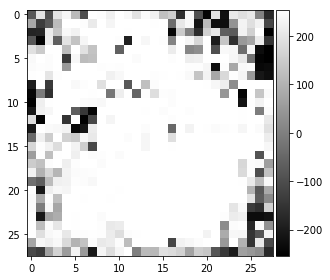

TARGET


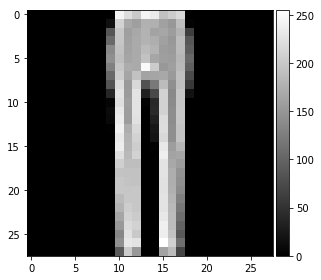

step  1000 / 1000 d_loss:  0.40630966424942017 g_loss:  0.75711894
epoch 132 progress report:
latent shape:  (1, 100)
latent:  [[0.98746144 0.0817919  0.24764106 0.79022974 0.11119318 0.8959714
  0.77896277 0.22184385 0.81954809 0.08797424 0.90087047 0.68078615
  0.74508832 0.46810459 0.71776722 0.91290528 0.61906963 0.89107302
  0.36344738 0.83785096 0.66723643 0.60722264 0.24984481 0.45882616
  0.15059659 0.8756248  0.34563584 0.02032967 0.15880419 0.60922584
  0.6963783  0.61864928 0.41704575 0.82937573 0.59865735 0.94223348
  0.67292679 0.82889023 0.42302918 0.76845343 0.77073586 0.34065382
  0.42308983 0.88848068 0.27155687 0.07264679 0.21589376 0.91384066
  0.16860646 0.73782879 0.45698703 0.01757633 0.52435435 0.4317714
  0.53783094 0.3147199  0.60220874 0.60722351 0.28019281 0.66532869
  0.04529132 0.22926889 0.31640401 0.61796071 0.58434917 0.77917409
  0.20916492 0.15402646 0.58740128 0.67382688 0.74931668 0.48754385
  0.65704292 0.67118138 0.0847206  0.48041148 0.01580821 0.

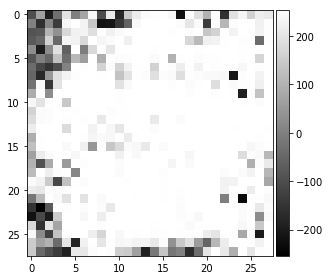

TARGET


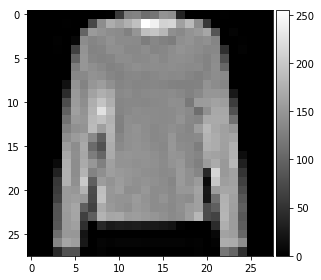

step  1000 / 1000 d_loss:  0.44076842069625854 g_loss:  0.7567992
epoch 133 progress report:
latent shape:  (1, 100)
latent:  [[0.80832042 0.61188329 0.49769406 0.15384217 0.92934827 0.03830093
  0.55488543 0.56995941 0.01927799 0.94869453 0.52673238 0.55554684
  0.62774516 0.64092941 0.795375   0.56090147 0.90059097 0.17029128
  0.12661043 0.1295281  0.7568762  0.64250724 0.56458668 0.06733132
  0.85125438 0.01602592 0.78754964 0.20748163 0.14407346 0.3604446
  0.95454072 0.88732943 0.54325445 0.06264214 0.72537016 0.47671389
  0.9882326  0.5833201  0.53547018 0.33348732 0.2075533  0.4012804
  0.37600416 0.0632802  0.80948334 0.31591999 0.46104098 0.52023921
  0.62869326 0.4272698  0.58462688 0.4062649  0.95899806 0.37166937
  0.11814122 0.38467663 0.48024572 0.87213331 0.26605402 0.27332264
  0.3514575  0.72125289 0.04422671 0.77975138 0.76822709 0.13227129
  0.76351479 0.1548972  0.88380809 0.17587154 0.84227754 0.48233575
  0.12306138 0.55121751 0.07682553 0.79311697 0.19585677 0.3

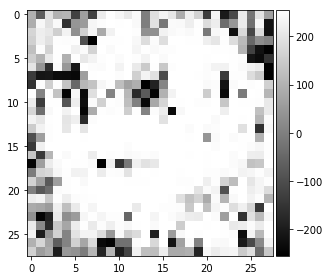

TARGET


step  1000 / 1000 d_loss:  0.37826257944107056 g_loss:  0.7562138
epoch 134 progress report:
latent shape:  (1, 100)
latent:  [[0.52285327 0.50250014 0.67722273 0.30133316 0.10886192 0.83826127
  0.00651401 0.26488236 0.83002953 0.84948987 0.76948289 0.07832725
  0.25219228 0.01934174 0.7301592  0.36475375 0.46225478 0.47785633
  0.16632794 0.91288734 0.35341872 0.74317168 0.58212772 0.54602064
  0.84125603 0.50184795 0.3591951  0.35835322 0.82281145 0.0985802
  0.42160437 0.93818788 0.83113364 0.6526681  0.38267653 0.89246458
  0.39461105 0.40046924 0.82821178 0.96754333 0.77222276 0.41194576
  0.43805039 0.20589901 0.46958257 0.65307367 0.26483333 0.45661685
  0.72915608 0.57027853 0.46653352 0.29107555 0.5258006  0.58891017
  0.52874341 0.88216311 0.49361562 0.70478174 0.92148464 0.35101458
  0.68416456 0.4633524  0.74517369 0.12696864 0.76156056 0.91735252
  0.65435613 0.89081355 0.21968326 0.78146535 0.6695612  0.11700644
  0.39068849 0.40810159 0.04218589 0.5074007  0.12284574 0.

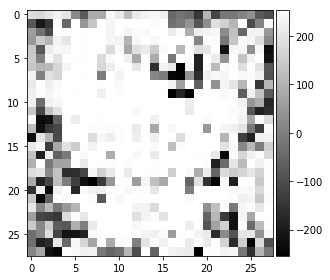

TARGET


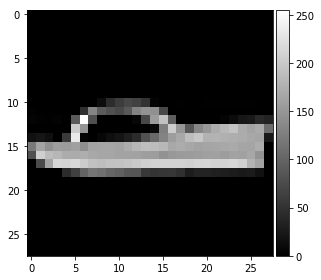

step  1000 / 1000 d_loss:  0.3916303813457489 g_loss:  0.7559168
epoch 135 progress report:
latent shape:  (1, 100)
latent:  [[0.26840203 0.0910892  0.40568377 0.76375749 0.18106678 0.02321114
  0.26346967 0.82994326 0.43047858 0.04258944 0.86446291 0.44929919
  0.61930983 0.808426   0.71196827 0.05627415 0.0948868  0.18453495
  0.71261313 0.1892511  0.91529464 0.29784097 0.98753513 0.37059211
  0.87626075 0.81842509 0.86997675 0.71428129 0.69072855 0.64843937
  0.28307157 0.89311737 0.4084751  0.48521802 0.95447745 0.96968302
  0.54435579 0.95888387 0.52235022 0.1289826  0.40262154 0.81833985
  0.83592343 0.82178346 0.37761536 0.57805885 0.35591034 0.51299908
  0.48068008 0.66708665 0.66686772 0.1815005  0.81451416 0.32963771
  0.70163596 0.97795001 0.01038585 0.49363441 0.93462218 0.77588844
  0.86456891 0.6608997  0.49623253 0.08138915 0.45490618 0.82900387
  0.56070297 0.7173053  0.44830249 0.00840599 0.68206903 0.37299249
  0.86212456 0.3164166  0.98190146 0.56203781 0.8076826  0.

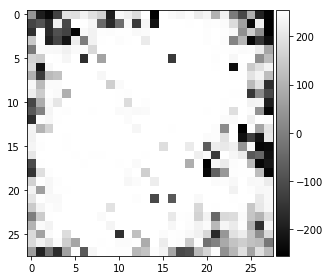

TARGET


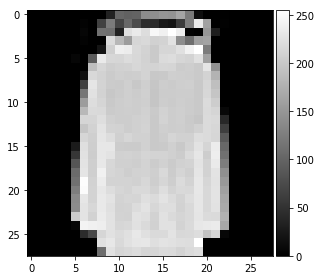

step  1000 / 1000 d_loss:  0.38182532787323 g_loss:  0.75561994
epoch 136 progress report:
latent shape:  (1, 100)
latent:  [[0.19960197 0.61840866 0.47178872 0.11868829 0.8674475  0.87061292
  0.68428251 0.31725359 0.47737431 0.84455953 0.34275662 0.2595142
  0.69703968 0.07616528 0.99808047 0.26910457 0.2729146  0.05147253
  0.65814493 0.14549986 0.90949715 0.50404627 0.04325975 0.98275652
  0.11909187 0.2912704  0.80609558 0.67495307 0.5770003  0.04043419
  0.58982566 0.29185417 0.81553616 0.94349824 0.71280759 0.64003352
  0.44048693 0.39449543 0.58243666 0.12910144 0.53724353 0.81501624
  0.30945472 0.10442915 0.15830261 0.10777837 0.00404948 0.86925234
  0.51029327 0.39450604 0.95622839 0.58595779 0.67243945 0.53488081
  0.91553354 0.74180654 0.45448867 0.61425762 0.07034442 0.33590007
  0.02939812 0.07411041 0.62392307 0.53306089 0.8758531  0.13442398
  0.20197925 0.21456374 0.70187906 0.02925962 0.74774664 0.81605619
  0.64435032 0.25556177 0.93422795 0.29026363 0.9928468  0.43

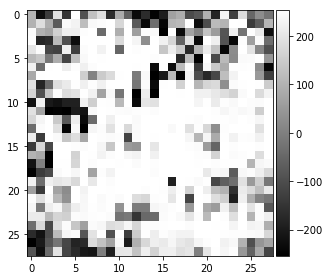

TARGET


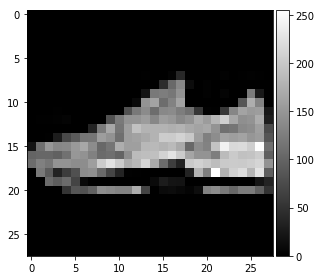

step  1000 / 1000 d_loss:  0.3946476876735687 g_loss:  0.7549581
epoch 137 progress report:
latent shape:  (1, 100)
latent:  [[0.80949051 0.09485965 0.33133443 0.57075403 0.43735896 0.34342037
  0.92813176 0.92446709 0.10420035 0.64861133 0.56343446 0.90123006
  0.71732835 0.65333488 0.82158301 0.88928695 0.17373729 0.68000582
  0.73759073 0.8246837  0.36320715 0.19653741 0.29020768 0.44785863
  0.87310845 0.7818419  0.07830453 0.86355788 0.86735149 0.6403845
  0.95800927 0.1901117  0.68491022 0.10641326 0.48145856 0.6052297
  0.57567461 0.31951134 0.20640764 0.1147426  0.34644726 0.03810937
  0.15144787 0.43922663 0.73569292 0.56161452 0.88996342 0.1285511
  0.39198967 0.29662329 0.72978406 0.72199188 0.78590505 0.07528444
  0.80696132 0.25499084 0.64549784 0.12733132 0.60039203 0.32783452
  0.71494035 0.59057363 0.03161379 0.42708724 0.19533238 0.14990566
  0.10865977 0.17922287 0.65066027 0.79215106 0.36793014 0.19874172
  0.31366478 0.59226115 0.15970604 0.81571268 0.39907751 0.911

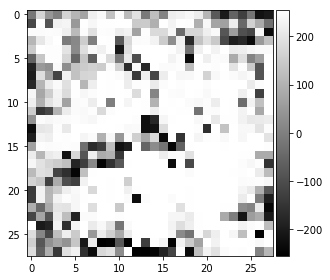

TARGET


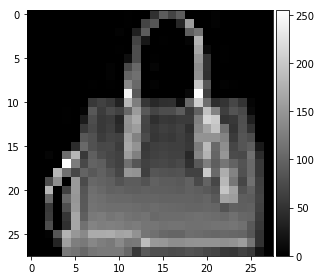

step  1000 / 1000 d_loss:  0.44211918115615845 g_loss:  0.75427395
epoch 138 progress report:
latent shape:  (1, 100)
latent:  [[0.62554744 0.4819062  0.72742519 0.88859471 0.47515313 0.23580431
  0.40322079 0.17944907 0.36667671 0.46604621 0.25219774 0.15315752
  0.41336849 0.41411119 0.57155163 0.89422882 0.76023559 0.34547339
  0.61690661 0.40574393 0.79752271 0.26369569 0.42070608 0.70927437
  0.50864286 0.14227449 0.13450909 0.68750185 0.74813919 0.88814708
  0.87625063 0.88400031 0.73790127 0.17819281 0.13794079 0.90819118
  0.00711995 0.20868093 0.27352238 0.53583674 0.83338109 0.76160908
  0.03823513 0.27092039 0.62451997 0.11992347 0.44951938 0.63424444
  0.03071974 0.96866301 0.31748151 0.93298359 0.69544613 0.75985707
  0.92083343 0.60834879 0.05615218 0.2485626  0.87271407 0.60431519
  0.05959387 0.10269335 0.95951539 0.11361204 0.06835017 0.77618136
  0.28639597 0.03799444 0.01264008 0.33451833 0.51677358 0.62027082
  0.2041918  0.08143739 0.25183859 0.25295903 0.85571871 

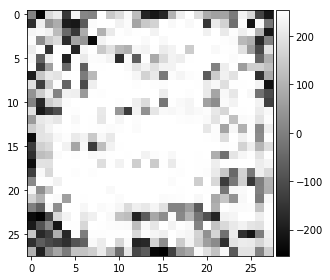

TARGET


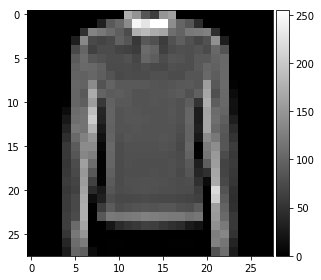

step  1000 / 1000 d_loss:  0.40103548765182495 g_loss:  0.75393564
epoch 139 progress report:
latent shape:  (1, 100)
latent:  [[0.94303026 0.52148877 0.95422479 0.410372   0.1013805  0.8430729
  0.00193888 0.93471059 0.07352416 0.40349652 0.76770097 0.98375924
  0.42914687 0.01220279 0.99806291 0.30584635 0.56414167 0.25248993
  0.9565598  0.03115338 0.5961193  0.12095241 0.36346732 0.80287372
  0.75607194 0.51754855 0.53346574 0.32929079 0.05186006 0.70870821
  0.44939337 0.29990229 0.99040226 0.39442017 0.96586183 0.13816251
  0.52855059 0.78790721 0.99164537 0.03391318 0.98685432 0.75403138
  0.67832855 0.097407   0.04686408 0.38000803 0.98409563 0.34209294
  0.83210229 0.88244509 0.66150018 0.91642805 0.12182174 0.82758122
  0.32418771 0.40901954 0.90915016 0.94715837 0.67539942 0.23784735
  0.11042905 0.48991681 0.74232593 0.09553003 0.55016246 0.105853
  0.54645635 0.32043515 0.76895012 0.61021975 0.1153276  0.76851302
  0.35377083 0.11233854 0.52168338 0.49984015 0.89515987 0.4

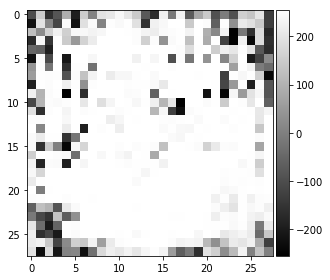

TARGET


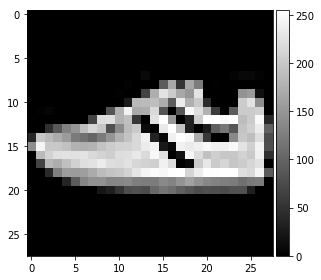

step  1000 / 1000 d_loss:  0.37711024284362793 g_loss:  0.75359744
epoch 140 progress report:
latent shape:  (1, 100)
latent:  [[0.1060128  0.80876274 0.40246802 0.60859857 0.75265237 0.76188775
  0.44348029 0.34020955 0.37538708 0.61249985 0.9020626  0.58366848
  0.76999195 0.44504512 0.13232809 0.08783068 0.00542176 0.06562635
  0.12284158 0.74588101 0.95770429 0.34369947 0.98392472 0.82458778
  0.09227376 0.94206045 0.67484744 0.07971791 0.33963887 0.6815321
  0.41393785 0.32676476 0.5756517  0.6693623  0.93840519 0.52499381
  0.71348051 0.31365171 0.46117797 0.62253772 0.43461559 0.49721107
  0.95545764 0.80786819 0.75198538 0.71614446 0.02114545 0.99719066
  0.08502234 0.89326389 0.45224612 0.61321616 0.04513108 0.59618384
  0.45728726 0.94572512 0.12234671 0.2964155  0.82719022 0.41494859
  0.82640928 0.5839371  0.01622719 0.49764491 0.68264293 0.25163125
  0.18726094 0.73740746 0.18939831 0.55125647 0.850287   0.18784954
  0.29160236 0.65353802 0.29592038 0.92806569 0.84478262 0

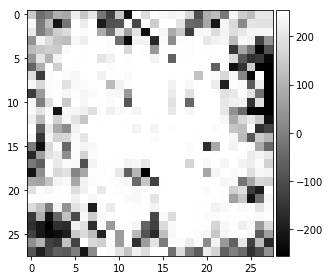

TARGET


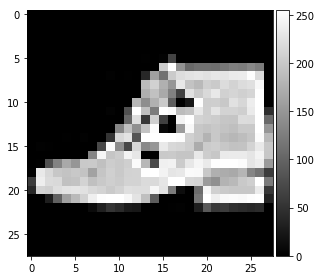

step  1000 / 1000 d_loss:  0.4945855736732483 g_loss:  0.75298744
epoch 141 progress report:
latent shape:  (1, 100)
latent:  [[0.6601969  0.73523704 0.10154722 0.76976944 0.46066033 0.00816941
  0.7986201  0.28701032 0.44949642 0.97062266 0.14316017 0.40473787
  0.65293855 0.66058863 0.24875907 0.69107015 0.9484875  0.54852689
  0.8001183  0.62249213 0.5115333  0.69791206 0.9500898  0.49470446
  0.40962674 0.06969893 0.87708327 0.50845092 0.09333938 0.15541095
  0.78363031 0.19213979 0.87784639 0.63481741 0.99418978 0.16017341
  0.68115898 0.29631537 0.23903261 0.17511516 0.45632235 0.97309569
  0.81653069 0.24319057 0.47041936 0.093867   0.10081177 0.97893077
  0.28791753 0.77846463 0.87927124 0.25729591 0.41997975 0.19071847
  0.60836382 0.52052188 0.9636323  0.08735728 0.53807087 0.8366959
  0.48841539 0.87540549 0.89646851 0.3876901  0.75991255 0.49426538
  0.706512   0.47347177 0.53873518 0.94523602 0.65817971 0.05089241
  0.04183811 0.7257544  0.71808815 0.41169697 0.82831351 0.

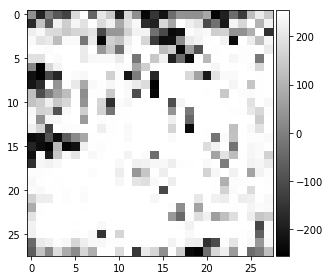

TARGET


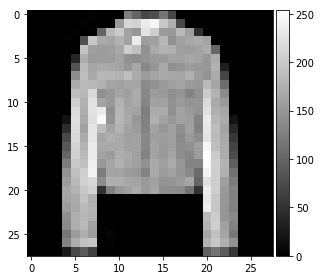

step  1000 / 1000 d_loss:  0.39191827178001404 g_loss:  0.7524272
epoch 142 progress report:
latent shape:  (1, 100)
latent:  [[0.5082593  0.95649043 0.15799873 0.15745618 0.2208152  0.09097354
  0.38179519 0.04325809 0.59724834 0.15632915 0.63040822 0.8800045
  0.90324173 0.06248997 0.0488389  0.4045452  0.36746324 0.51208627
  0.5949353  0.14081974 0.54408843 0.30012392 0.12066354 0.28013283
  0.79893959 0.1888906  0.59150807 0.42636475 0.97450572 0.28919105
  0.3013205  0.66128018 0.5263966  0.5291996  0.35149441 0.99340132
  0.07059202 0.17333231 0.10472735 0.24681811 0.46616426 0.70660128
  0.712082   0.10540499 0.96032643 0.94253934 0.01414431 0.53862613
  0.5316     0.63146733 0.00286903 0.45262451 0.6690616  0.32853029
  0.37261345 0.42123445 0.76120898 0.09523242 0.03693287 0.49861528
  0.69047891 0.66041568 0.4470165  0.87741759 0.84642411 0.74574119
  0.6932733  0.22497714 0.24670645 0.51701136 0.63378091 0.91996826
  0.71695667 0.57969572 0.58306429 0.59355328 0.06141469 0.

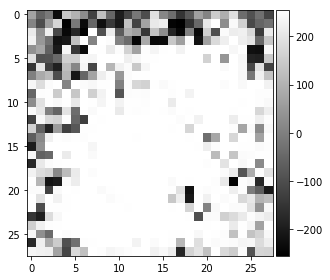

TARGET


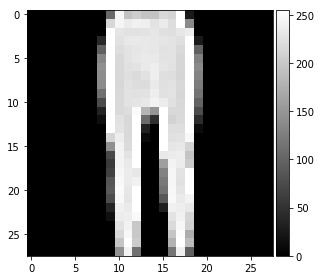

step  1000 / 1000 d_loss:  0.37791645526885986 g_loss:  0.75213295
epoch 143 progress report:
latent shape:  (1, 100)
latent:  [[0.8872884  0.40909854 0.3082643  0.48592156 0.47062398 0.78570794
  0.54492977 0.56143044 0.62239468 0.19725521 0.20195313 0.46586247
  0.84972146 0.58220015 0.97049623 0.79711082 0.63058661 0.40154731
  0.99464576 0.85549684 0.36328223 0.84841024 0.82100548 0.11758611
  0.09051397 0.51786187 0.01751814 0.5550826  0.11705027 0.17750509
  0.61472946 0.36986853 0.24995073 0.78812854 0.82959197 0.46501605
  0.42520519 0.16249447 0.13648965 0.82328371 0.06969708 0.91871079
  0.98797749 0.49574361 0.14635273 0.82100135 0.26381484 0.5886696
  0.56452197 0.4012889  0.12305945 0.68554111 0.47203566 0.47774739
  0.13062508 0.79507734 0.16088902 0.14580181 0.43215845 0.38573799
  0.26704036 0.37982601 0.38321439 0.559268   0.13904486 0.37688354
  0.60669316 0.92369041 0.26965307 0.77108974 0.45999739 0.21614391
  0.48241419 0.95472315 0.78559485 0.78807484 0.15835844 0

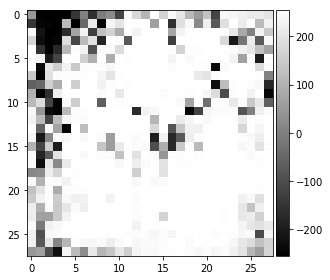

TARGET


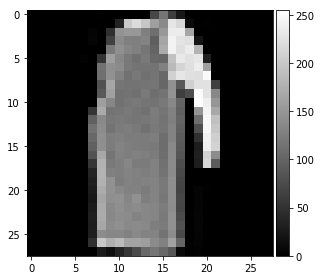

step  1000 / 1000 d_loss:  0.4192470908164978 g_loss:  0.75158024
epoch 144 progress report:
latent shape:  (1, 100)
latent:  [[0.76723096 0.52852614 0.04399784 0.36944821 0.76701134 0.56694478
  0.04243778 0.36663187 0.27837101 0.158006   0.03821404 0.43686921
  0.77914624 0.1097644  0.89598709 0.27928601 0.35347477 0.53541226
  0.42972588 0.30407538 0.57811354 0.71354754 0.14667617 0.09140743
  0.85675496 0.58191302 0.14002833 0.73269024 0.73466492 0.20401244
  0.24478211 0.78941473 0.96607204 0.75062078 0.4449811  0.03488699
  0.94032897 0.2366714  0.04561425 0.76404084 0.30708378 0.36083488
  0.63420356 0.85579439 0.95637259 0.84945901 0.37082726 0.06721745
  0.97361522 0.5969706  0.21153201 0.75567647 0.68025092 0.07431306
  0.36879525 0.16843408 0.76961772 0.43503356 0.06529449 0.03555767
  0.81807561 0.24070656 0.4305979  0.14314856 0.85563499 0.24566172
  0.51617394 0.94198519 0.56268117 0.16794118 0.20368645 0.10780364
  0.54897586 0.18301333 0.12554648 0.97772065 0.34925455 0

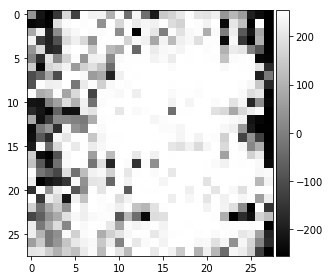

TARGET


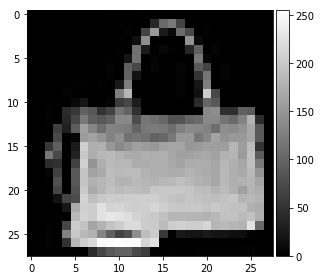

step  1000 / 1000 d_loss:  0.42793530225753784 g_loss:  0.7510484
epoch 145 progress report:
latent shape:  (1, 100)
latent:  [[9.20313273e-01 1.36117581e-01 5.52500987e-02 2.73396085e-01
  4.90681008e-01 4.57919624e-01 5.02489029e-01 6.30829724e-01
  8.48357883e-01 8.32768896e-01 6.26237813e-01 4.86268693e-01
  9.60298434e-01 1.81801213e-01 5.18749149e-01 2.82736273e-02
  8.74417572e-01 2.27114552e-01 2.81751611e-02 5.01370729e-02
  3.32603302e-01 4.82676570e-01 4.14740375e-02 9.66369059e-01
  4.00505455e-01 2.34328500e-01 1.93781174e-01 4.13095174e-01
  2.10443861e-01 1.05543556e-01 8.00335873e-01 8.63310338e-01
  3.60119127e-01 3.73759622e-01 4.63677815e-01 3.79617558e-01
  7.95896818e-01 3.22289753e-01 8.93204266e-01 6.96170679e-01
  9.22256261e-01 6.50100005e-01 7.75345481e-01 7.79887653e-01
  9.77535686e-01 4.54525267e-02 3.92987269e-01 7.85984575e-01
  2.98443955e-02 5.58292058e-01 4.60731375e-01 8.61882217e-01
  2.39043594e-01 9.32054949e-01 2.80910287e-01 5.12276363e-01
  2.64

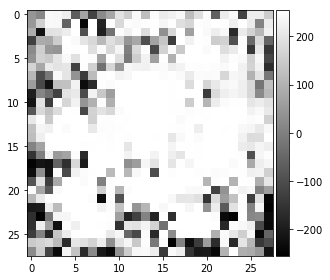

TARGET


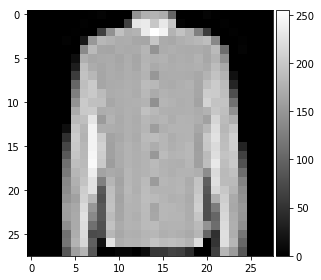

step  1000 / 1000 d_loss:  0.39158502221107483 g_loss:  0.7505331
epoch 146 progress report:
latent shape:  (1, 100)
latent:  [[0.07212553 0.62889557 0.30660078 0.25616944 0.54937848 0.98202788
  0.4368844  0.22135988 0.07585917 0.3066467  0.36892187 0.39713073
  0.88871354 0.7272065  0.03973662 0.82528504 0.12384143 0.33234362
  0.09116749 0.32715825 0.84586107 0.21319048 0.61369932 0.14786555
  0.63192332 0.19635615 0.79805937 0.95377221 0.44409625 0.07837128
  0.93254751 0.30463283 0.87158982 0.70794769 0.8130258  0.09915065
  0.0280904  0.56736528 0.48601295 0.57877424 0.20054428 0.6588605
  0.67386959 0.50261719 0.74372759 0.24318274 0.85916339 0.95924148
  0.47901413 0.60983931 0.59081073 0.93945822 0.27217123 0.30079235
  0.24262939 0.02606633 0.70321079 0.16421392 0.00366241 0.64965641
  0.02373285 0.64610642 0.51502903 0.07522055 0.44204004 0.75267961
  0.44005041 0.78324582 0.72483292 0.84321924 0.64202213 0.66775837
  0.88357656 0.25303705 0.56168439 0.41370943 0.07131029 0.

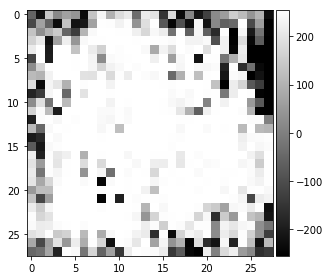

TARGET


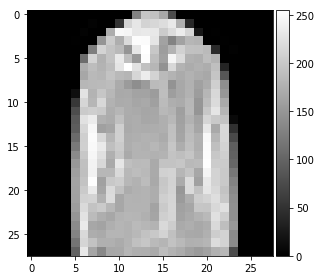

step  1000 / 1000 d_loss:  0.3783537745475769 g_loss:  0.75025785
epoch 147 progress report:
latent shape:  (1, 100)
latent:  [[0.42312557 0.88174283 0.50873293 0.73819071 0.91438664 0.90312615
  0.31854266 0.52378564 0.15323482 0.75356415 0.39979918 0.01852102
  0.159406   0.93366522 0.50790282 0.46206208 0.79284555 0.40998927
  0.94410509 0.44724431 0.3286484  0.23588656 0.75689511 0.92689432
  0.92279919 0.66361121 0.88439869 0.41709267 0.57729812 0.16533508
  0.65053927 0.31474325 0.6547321  0.07226419 0.06155144 0.85730853
  0.08302901 0.83014074 0.62562027 0.16655194 0.71389716 0.30016021
  0.87898549 0.91132455 0.2310665  0.97881665 0.40082473 0.13840688
  0.6479482  0.32983149 0.62485468 0.6569331  0.59444777 0.44925366
  0.96073669 0.97381896 0.95160917 0.09584381 0.44505821 0.5581723
  0.12136463 0.06271587 0.07736679 0.16353245 0.65409574 0.35382778
  0.79263169 0.27297192 0.77771454 0.3620734  0.73937032 0.33005549
  0.73641303 0.39333818 0.00549392 0.87382814 0.81025329 0.

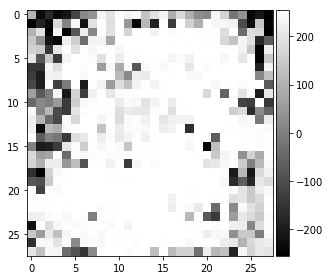

TARGET


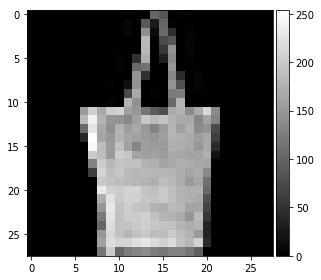

step  1000 / 1000 d_loss:  0.3799950182437897 g_loss:  0.7499686
epoch 148 progress report:
latent shape:  (1, 100)
latent:  [[0.27769266 0.33668163 0.69795348 0.92908525 0.5496239  0.91505919
  0.73999729 0.6725109  0.40125668 0.72053832 0.03496695 0.09032023
  0.05102081 0.24446831 0.20191082 0.0082769  0.96726923 0.60922241
  0.56467247 0.28477781 0.37167092 0.15325433 0.20321845 0.96879601
  0.7229258  0.18417171 0.39609948 0.0399461  0.91427072 0.33218938
  0.10088977 0.94839226 0.72236333 0.42422491 0.92192462 0.40331886
  0.98821062 0.09008436 0.76622164 0.01357652 0.99012416 0.26039886
  0.65029999 0.32861115 0.1790927  0.60806792 0.595723   0.68359872
  0.35897666 0.49052678 0.80534875 0.70477941 0.12887596 0.59040887
  0.40018349 0.80517545 0.49228904 0.91087175 0.2619432  0.98531036
  0.96147105 0.1883491  0.56096939 0.42363232 0.06810211 0.88317099
  0.71364714 0.36265782 0.05144366 0.84912363 0.79891255 0.30115618
  0.78835735 0.63004293 0.45549534 0.25428195 0.39948677 0.

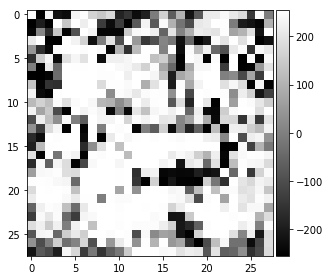

TARGET


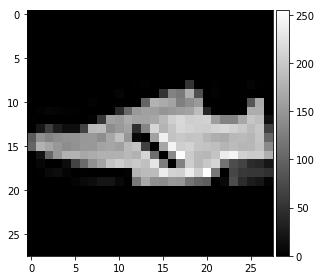

step  1000 / 1000 d_loss:  0.38006842136383057 g_loss:  0.74929917
epoch 149 progress report:
latent shape:  (1, 100)
latent:  [[0.63977323 0.29703196 0.62336378 0.74065229 0.47142182 0.27972822
  0.00533946 0.74905569 0.01440003 0.78128775 0.40568858 0.60890545
  0.9580538  0.01635975 0.29171862 0.01766232 0.71128353 0.76539188
  0.97550793 0.5822653  0.40324395 0.7012634  0.37964937 0.83664363
  0.69095244 0.85605993 0.60787676 0.09703385 0.77495345 0.1516103
  0.15292484 0.77076939 0.2149828  0.72106769 0.35694286 0.44397474
  0.47879578 0.30600738 0.49173909 0.79512088 0.17382401 0.15652074
  0.06157686 0.99687755 0.91215657 0.64249039 0.78015128 0.94567878
  0.48356578 0.75629515 0.36266846 0.91309505 0.40757094 0.96837556
  0.08203937 0.34062771 0.74161103 0.53071515 0.11921962 0.13061366
  0.62733677 0.03137958 0.01268231 0.84936358 0.49606206 0.22448248
  0.83986804 0.58675313 0.0851157  0.95063876 0.83376305 0.46349067
  0.99661647 0.07640348 0.33981055 0.27471396 0.26539879 0

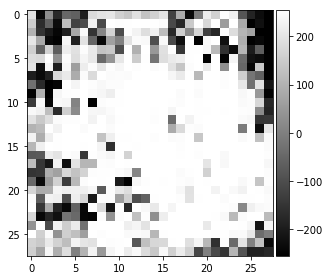

TARGET


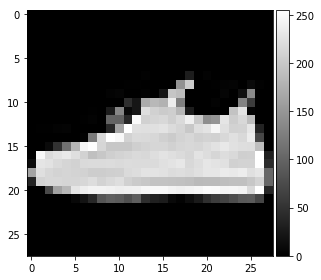

step  1000 / 1000 d_loss:  0.43614035844802856 g_loss:  0.7486623
epoch 150 progress report:
latent shape:  (1, 100)
latent:  [[5.42029142e-01 8.57183223e-01 4.40316984e-02 4.21401632e-01
  7.73405953e-02 6.75970302e-02 5.50604033e-01 2.66189160e-01
  3.03306732e-01 2.30260749e-01 7.47433557e-02 1.33989703e-01
  6.86737165e-02 4.96080160e-01 6.94966456e-01 4.19206394e-01
  7.61262810e-01 3.94396472e-01 6.59768167e-01 2.39117407e-01
  6.55908394e-01 5.35604980e-01 5.64373723e-01 3.27023641e-01
  6.47210828e-01 7.54207509e-01 4.63387644e-01 6.97776879e-01
  6.10401735e-01 6.34923678e-01 8.70309692e-01 4.59867955e-01
  5.40165314e-01 3.11902769e-01 1.79530113e-01 4.57289264e-01
  6.08056799e-01 1.01084679e-01 8.10096001e-02 9.92690137e-01
  5.46676259e-02 9.02230844e-01 2.66534297e-01 9.29080093e-02
  1.69016577e-01 3.01744736e-01 4.64339430e-01 9.42942080e-01
  1.28933944e-01 7.27882480e-01 9.22486519e-01 7.66649600e-01
  1.98238205e-01 7.11121821e-04 4.85887008e-01 6.70086687e-01
  8.89

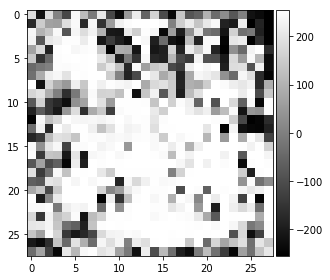

TARGET


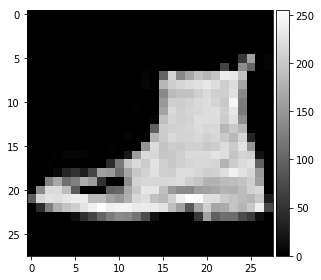

step  1000 / 1000 d_loss:  0.37455815076828003 g_loss:  0.74807924
epoch 151 progress report:
latent shape:  (1, 100)
latent:  [[5.16688859e-01 5.21734713e-02 4.72597605e-02 1.07432560e-01
  5.62703902e-01 3.16246357e-01 7.34692851e-01 3.54427100e-01
  8.54281072e-02 2.27978265e-01 6.59790789e-02 1.15470830e-01
  1.01797325e-01 6.87333739e-01 9.10283702e-01 2.79421753e-01
  4.42387138e-01 2.65830270e-01 2.07327114e-02 3.66779048e-01
  1.74019711e-01 7.19253278e-01 1.61076269e-01 2.43172594e-01
  2.16620716e-01 6.31367248e-01 8.95398464e-01 1.10384806e-02
  7.80560741e-01 3.42505405e-02 8.45330515e-01 2.92298996e-01
  6.71476460e-01 6.78266985e-01 4.30501636e-01 4.14487316e-02
  3.83034017e-01 6.78921378e-01 6.83180070e-01 2.09206330e-02
  6.89423388e-01 6.82803267e-01 2.35180470e-01 8.02817339e-01
  4.35923807e-01 1.47849874e-01 1.65498250e-01 7.64535270e-01
  8.91942446e-01 2.19830976e-02 2.69698037e-01 2.23621374e-01
  9.43930260e-01 6.53225886e-01 1.73520068e-01 8.57080614e-01
  3.0

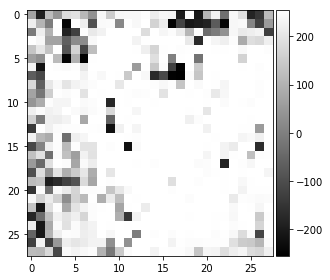

TARGET


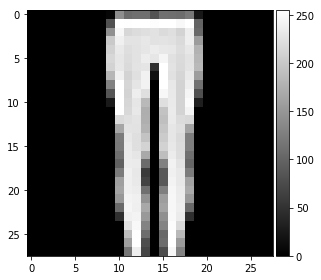

step  1000 / 1000 d_loss:  0.395277202129364 g_loss:  0.74778235
epoch 152 progress report:
latent shape:  (1, 100)
latent:  [[0.919393   0.9101541  0.58063121 0.35713679 0.40913631 0.28823651
  0.04521898 0.3191946  0.17746601 0.14517832 0.09444429 0.54393852
  0.67316546 0.86783318 0.62796204 0.66076169 0.77721021 0.97733584
  0.78276361 0.6493555  0.85686116 0.56390368 0.80461133 0.54687645
  0.37487266 0.91625281 0.77948486 0.64995064 0.15083236 0.34248274
  0.22907375 0.68178475 0.28080139 0.42913533 0.81965498 0.98582247
  0.2810296  0.28248862 0.24121067 0.12096914 0.74875419 0.04819339
  0.18157283 0.77910475 0.08345656 0.94200983 0.18764977 0.69270031
  0.19153436 0.40891503 0.98761126 0.44923993 0.57723866 0.77601214
  0.50330001 0.40652641 0.04035599 0.82542017 0.07255784 0.45621219
  0.74479831 0.25667727 0.00328124 0.82373537 0.36739129 0.93826517
  0.89967103 0.11945532 0.41980006 0.88715824 0.97542236 0.25122832
  0.74305786 0.62989706 0.53735276 0.32992909 0.03903931 0.

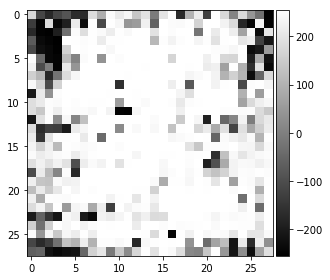

TARGET


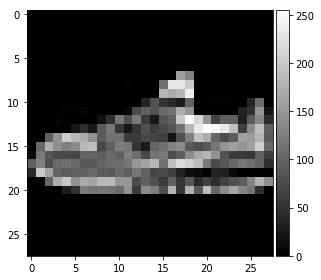

step  1000 / 1000 d_loss:  0.3959663212299347 g_loss:  0.7466294
epoch 153 progress report:
latent shape:  (1, 100)
latent:  [[0.11994015 0.34860685 0.54585593 0.31695917 0.10977941 0.67193855
  0.59410109 0.57280444 0.90742338 0.50284813 0.38718903 0.95838951
  0.07737303 0.89518884 0.08420077 0.52342292 0.91995628 0.68465149
  0.41647589 0.79817924 0.84118629 0.81737861 0.07235648 0.01186211
  0.04171451 0.88541898 0.381367   0.70450801 0.81024502 0.17355863
  0.44337591 0.73875997 0.43070173 0.86750072 0.89213162 0.14290961
  0.75518699 0.67502594 0.96029873 0.00623607 0.42981791 0.3060657
  0.4383779  0.87030692 0.16988683 0.96361689 0.64286438 0.28225345
  0.35892048 0.97918693 0.56729426 0.60910078 0.90814794 0.37000687
  0.18086122 0.34302556 0.53908595 0.92710498 0.05496907 0.94417088
  0.99036821 0.97324009 0.82893875 0.38161595 0.04788627 0.73952058
  0.41979554 0.55947906 0.8547495  0.51607909 0.78997156 0.79738834
  0.63846113 0.39765018 0.52648046 0.19386863 0.6341831  0.2

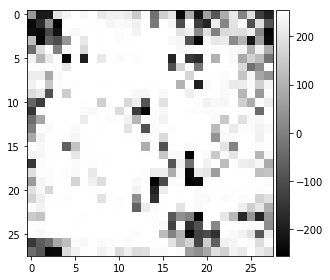

TARGET


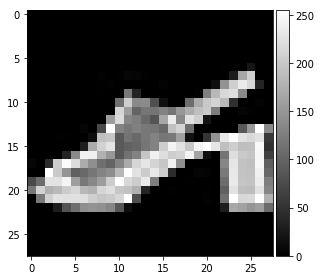

step  1000 / 1000 d_loss:  0.4860381782054901 g_loss:  0.7464121
epoch 154 progress report:
latent shape:  (1, 100)
latent:  [[0.8467411  0.73387866 0.4533849  0.56094437 0.14400727 0.56721122
  0.72472457 0.10997907 0.05247534 0.30823817 0.88672628 0.76259538
  0.24452088 0.9777857  0.04334807 0.58145571 0.71168857 0.81391297
  0.68556558 0.37623274 0.97943309 0.72743667 0.02585847 0.27742129
  0.05483849 0.88137624 0.77858588 0.69389537 0.99523937 0.38556929
  0.54534839 0.62942381 0.74446581 0.54271743 0.04008729 0.85072525
  0.93778857 0.30633492 0.53893805 0.48708392 0.93264453 0.34551414
  0.63194584 0.84591881 0.01550803 0.74284662 0.05469923 0.07270463
  0.80020082 0.33469324 0.88787472 0.99115266 0.84374091 0.81143901
  0.57767866 0.21192733 0.20397129 0.66869252 0.82025778 0.23455675
  0.72051618 0.60618431 0.64379471 0.75018631 0.89622876 0.12359856
  0.63782825 0.61723654 0.4632613  0.9843054  0.92344313 0.1347714
  0.85172866 0.68801174 0.16171511 0.4654073  0.41974114 0.1

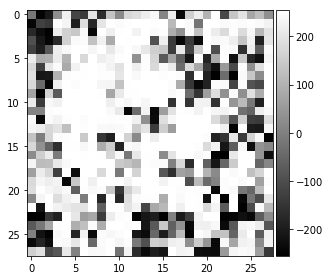

TARGET


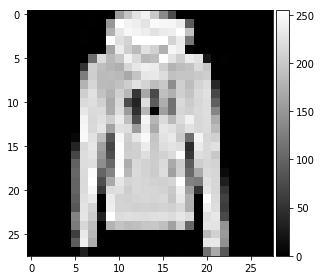

step  1000 / 1000 d_loss:  0.4125850200653076 g_loss:  0.7461786
epoch 155 progress report:
latent shape:  (1, 100)
latent:  [[0.28214096 0.01422229 0.23391596 0.28957139 0.59951398 0.74444512
  0.28772627 0.57256308 0.59374689 0.59514556 0.72161645 0.11940343
  0.5018392  0.74162085 0.60427096 0.91590332 0.33105417 0.93974194
  0.47943094 0.52865934 0.36308016 0.47933702 0.47558535 0.30073599
  0.59107771 0.29244766 0.96408507 0.28387643 0.97547624 0.91971203
  0.62162887 0.37945976 0.72601304 0.99080757 0.82911477 0.34381976
  0.78712588 0.17479446 0.17823564 0.46381195 0.8718358  0.45830399
  0.93207188 0.51884583 0.95457844 0.67265933 0.55238021 0.10011559
  0.65948325 0.62057448 0.05152574 0.49261715 0.1657365  0.12569271
  0.04576015 0.19558318 0.72679621 0.42841937 0.17080621 0.69248186
  0.94019184 0.00139963 0.49881757 0.8473688  0.83555093 0.13740042
  0.3787197  0.92504089 0.32233685 0.29103438 0.87278326 0.03976718
  0.90593126 0.41002008 0.51062    0.26446358 0.06134281 0.

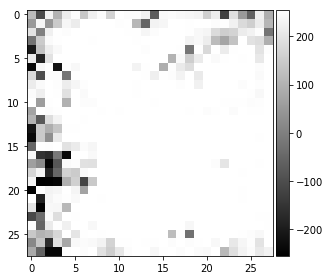

TARGET


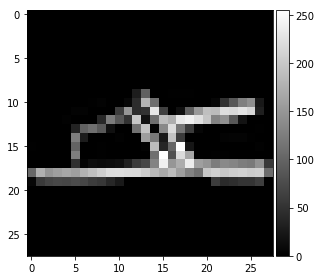

step  1000 / 1000 d_loss:  0.37313878536224365 g_loss:  0.7459235
epoch 156 progress report:
latent shape:  (1, 100)
latent:  [[0.96177436 0.36496727 0.90108971 0.02944843 0.36684617 0.92185685
  0.33644647 0.41194427 0.95224642 0.641269   0.40058508 0.18944638
  0.28066605 0.28209994 0.37555112 0.54810711 0.88653314 0.26994434
  0.51013268 0.36430963 0.84627915 0.54640292 0.08976238 0.50488503
  0.30401003 0.59792034 0.1256338  0.38488921 0.99525948 0.26912125
  0.07724394 0.14039948 0.86269408 0.82867173 0.80461226 0.24599112
  0.09910738 0.35865477 0.363413   0.30630533 0.56857516 0.51619283
  0.18654399 0.25390447 0.94865238 0.220855   0.96200415 0.44555238
  0.0701341  0.19236425 0.04939086 0.28099851 0.71377227 0.6329146
  0.57057118 0.98122182 0.5784675  0.63317135 0.12555008 0.26210836
  0.42103685 0.42091508 0.22793527 0.54708712 0.14210418 0.37004308
  0.52004874 0.5726922  0.66466925 0.52778483 0.92358726 0.41559238
  0.85373213 0.8629469  0.52787383 0.45232218 0.32708887 0.

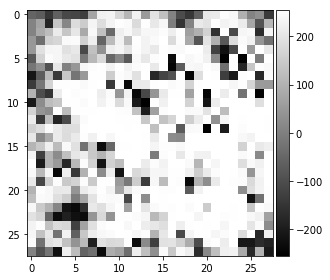

TARGET


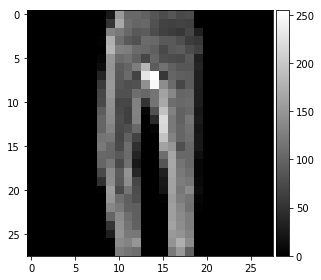

step  1000 / 1000 d_loss:  0.37360459566116333 g_loss:  0.745427
epoch 157 progress report:
latent shape:  (1, 100)
latent:  [[0.93162536 0.71368414 0.33356441 0.48183435 0.81250271 0.31913875
  0.70967226 0.57740419 0.28412601 0.58314661 0.08756497 0.22122128
  0.76810411 0.74313755 0.40795506 0.06546292 0.80806883 0.92964732
  0.13947629 0.01341778 0.37516722 0.65712633 0.45188371 0.18841695
  0.42324275 0.60247821 0.01561262 0.66722621 0.91528387 0.98604561
  0.82958141 0.37699668 0.09172713 0.25407077 0.93089467 0.96635978
  0.67347425 0.35696321 0.5074395  0.77955461 0.01486935 0.67670952
  0.19211335 0.40882198 0.65364187 0.76225504 0.2190866  0.36436477
  0.14205706 0.26120258 0.20799289 0.28740107 0.38822599 0.32989343
  0.82846522 0.42076093 0.36370554 0.48807497 0.5395404  0.09823073
  0.66709868 0.87525634 0.34401489 0.91121915 0.82481409 0.12922605
  0.87742154 0.30495914 0.05767787 0.41292099 0.61429294 0.88556451
  0.5394991  0.81723842 0.59893493 0.24736437 0.36000437 0.

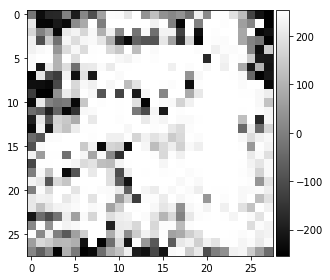

TARGET


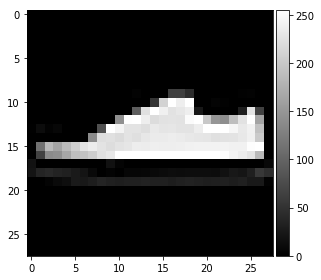

step  1000 / 1000 d_loss:  0.37315914034843445 g_loss:  0.74516106
epoch 158 progress report:
latent shape:  (1, 100)
latent:  [[0.42666227 0.20785663 0.87757747 0.09174139 0.90058034 0.82646171
  0.71529957 0.79232648 0.71761588 0.82393346 0.18628849 0.77070808
  0.46395848 0.17133568 0.18855676 0.91952581 0.77642391 0.07620889
  0.80983757 0.81265922 0.5346771  0.94552325 0.62814794 0.97240932
  0.40721873 0.87325759 0.11113773 0.42524506 0.17777152 0.4285877
  0.08841262 0.06767252 0.60955956 0.0218312  0.37200423 0.49721242
  0.12072344 0.17380258 0.34151064 0.68707882 0.77005536 0.27094764
  0.42727646 0.18990549 0.28404896 0.10373958 0.72515075 0.09945474
  0.54723789 0.93131747 0.17082578 0.78343298 0.99255579 0.78532701
  0.02355144 0.03460091 0.06453033 0.71829267 0.03221097 0.13129107
  0.00118181 0.98916287 0.64944016 0.85655066 0.28755781 0.05750498
  0.29970511 0.75785409 0.66925792 0.50670146 0.60740183 0.79364304
  0.27289642 0.98318383 0.01386237 0.78178732 0.86534799 0

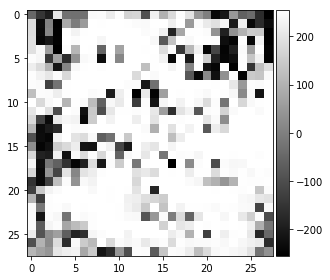

TARGET


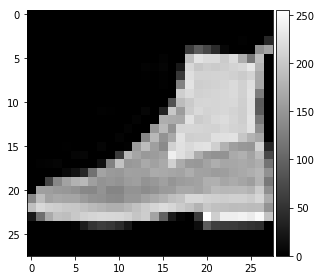

step  1000 / 1000 d_loss:  0.42182207107543945 g_loss:  0.7448861
epoch 159 progress report:
latent shape:  (1, 100)
latent:  [[0.52678304 0.38283927 0.25438137 0.43155048 0.92637902 0.01658564
  0.98163868 0.9541083  0.4249496  0.22683234 0.65140178 0.8626472
  0.28597793 0.27787474 0.44385789 0.98676223 0.62091109 0.03408576
  0.02361301 0.89023386 0.36656741 0.24374749 0.80837067 0.37420334
  0.57760379 0.86059099 0.88049841 0.78706745 0.9013562  0.29544807
  0.86650767 0.00490552 0.68281541 0.39813284 0.75747703 0.0360168
  0.81778907 0.44340629 0.48711394 0.02714568 0.25995278 0.12815902
  0.35679703 0.17728936 0.79211376 0.52567323 0.02546665 0.52153837
  0.20982666 0.08061691 0.21244999 0.27269358 0.73538063 0.93850914
  0.47025817 0.50516873 0.09213701 0.5334193  0.98247243 0.60302721
  0.8691791  0.80491012 0.12937118 0.61857217 0.10923937 0.21701495
  0.46658899 0.96005569 0.61010434 0.74634514 0.71968513 0.33098753
  0.49576487 0.00738748 0.62188335 0.27778434 0.54798579 0.0

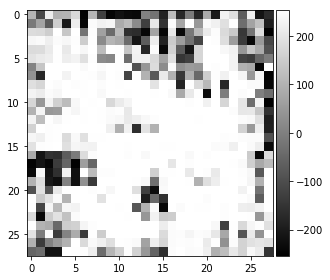

TARGET


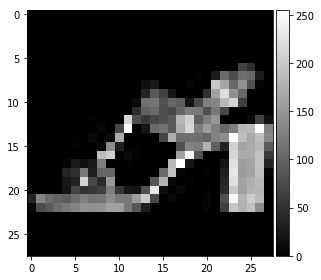

step  1000 / 1000 d_loss:  0.44341033697128296 g_loss:  0.744614
epoch 160 progress report:
latent shape:  (1, 100)
latent:  [[0.92017317 0.35875209 0.39856749 0.10115889 0.27471247 0.2168862
  0.59437655 0.45043166 0.64260695 0.27980508 0.09261282 0.58216477
  0.53244397 0.14357162 0.60081075 0.24464956 0.15830698 0.9612475
  0.29468117 0.32381351 0.89739088 0.28014615 0.67039698 0.64398649
  0.81962369 0.3957733  0.05171159 0.06223656 0.52404455 0.67053001
  0.84977738 0.05755311 0.32992741 0.783189   0.72738417 0.50812203
  0.46569359 0.69470441 0.32482846 0.06904676 0.47701707 0.49093366
  0.57754127 0.68941349 0.87670298 0.58988563 0.15469111 0.09515697
  0.096694   0.65446365 0.85251094 0.11084598 0.76685833 0.78903815
  0.68809217 0.8909941  0.86071468 0.06742172 0.52605654 0.32698934
  0.04785973 0.32479987 0.59063671 0.06333876 0.28358117 0.88961841
  0.50090718 0.63777132 0.94545772 0.57473732 0.08223581 0.97433596
  0.77258258 0.95134792 0.18492037 0.94833538 0.82943102 0.36

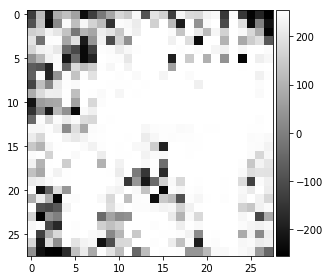

TARGET


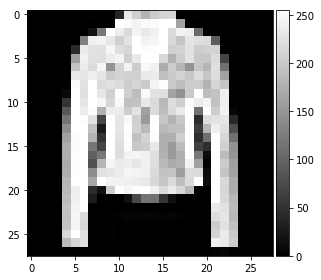

step  1000 / 1000 d_loss:  0.4209900498390198 g_loss:  0.74434155
epoch 161 progress report:
latent shape:  (1, 100)
latent:  [[0.36180622 0.74720317 0.74089495 0.13288184 0.34575762 0.4774736
  0.52638025 0.3502113  0.33737976 0.41050578 0.43122688 0.45970203
  0.31769375 0.84123106 0.19023112 0.14342516 0.24333258 0.61679726
  0.89671895 0.22226176 0.3908348  0.09956823 0.38518153 0.68701729
  0.16224168 0.49623648 0.43493163 0.00639054 0.84077397 0.56135903
  0.5059411  0.61374379 0.27697683 0.79796874 0.31470334 0.66935175
  0.25822159 0.34810373 0.59610414 0.28295607 0.34420745 0.88095836
  0.52381609 0.7692728  0.72324652 0.82863605 0.5912981  0.84575199
  0.50334721 0.81131683 0.30724059 0.89280802 0.8240082  0.334093
  0.32768959 0.74240959 0.95917414 0.76058571 0.23050702 0.72842163
  0.09037433 0.19525143 0.46487675 0.69010401 0.47238066 0.6027397
  0.27410119 0.66229945 0.95394425 0.65850482 0.45573586 0.4869226
  0.51047811 0.32151141 0.88818437 0.94341136 0.75307799 0.4220

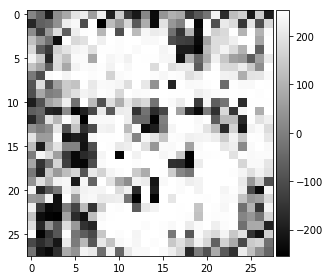

TARGET


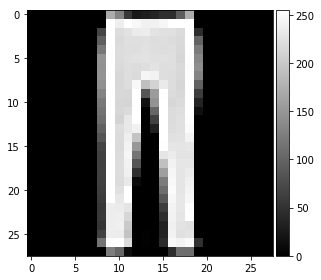

step  1000 / 1000 d_loss:  0.4094665050506592 g_loss:  0.74354374
epoch 162 progress report:
latent shape:  (1, 100)
latent:  [[0.07539163 0.02043596 0.45642758 0.62508266 0.30928122 0.74757844
  0.50006618 0.02856048 0.72902298 0.20778261 0.38363315 0.90000942
  0.31005133 0.5035026  0.15271444 0.43434993 0.06278095 0.96215977
  0.16642464 0.34819387 0.81618038 0.34606887 0.42652444 0.50174509
  0.44256771 0.12574932 0.77667708 0.05373463 0.76480474 0.29948163
  0.69095403 0.26419499 0.94804294 0.23174198 0.26927153 0.76214531
  0.87029661 0.2022152  0.40785843 0.75043674 0.15730028 0.01580345
  0.97097569 0.0532993  0.93398968 0.46609272 0.84950552 0.20860602
  0.46853007 0.31979253 0.22360306 0.05608473 0.7433399  0.20470153
  0.86755694 0.17782258 0.49056659 0.68577275 0.05390168 0.21124041
  0.53869259 0.13844578 0.87465955 0.58868515 0.78730724 0.41707428
  0.16574999 0.28690719 0.17827634 0.59431562 0.53347191 0.00725467
  0.67299157 0.55521649 0.38172391 0.85799207 0.78973731 0

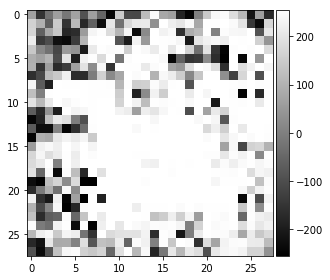

TARGET


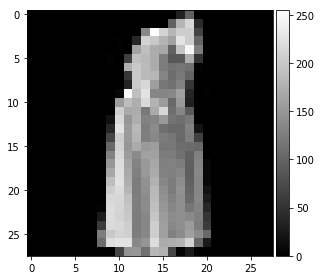

step  1000 / 1000 d_loss:  0.3925809860229492 g_loss:  0.74327767
epoch 163 progress report:
latent shape:  (1, 100)
latent:  [[0.08257041 0.7938982  0.17791347 0.63193354 0.77272922 0.7286172
  0.67523417 0.7442323  0.49405058 0.87040747 0.67563684 0.01844079
  0.81542771 0.63551244 0.39258519 0.99862944 0.87094868 0.35984078
  0.76682331 0.92096669 0.56845223 0.01449368 0.66226101 0.19421593
  0.96299468 0.58124935 0.48485378 0.04776531 0.81993562 0.76876975
  0.14925815 0.44469586 0.161311   0.80671214 0.77050965 0.94386409
  0.36475107 0.24018288 0.55653187 0.22748396 0.86078533 0.59324805
  0.02061075 0.75342486 0.30466418 0.12219817 0.53394771 0.24031739
  0.68522932 0.63900603 0.93839109 0.91224317 0.03040192 0.30252144
  0.64385004 0.2628605  0.22518633 0.94774348 0.93630267 0.39436992
  0.41476772 0.06845604 0.99130188 0.80954749 0.30338034 0.73815059
  0.77080278 0.7612363  0.26152188 0.9545837  0.06513548 0.21721535
  0.36516049 0.52308494 0.0713     0.86942018 0.5619991  0.

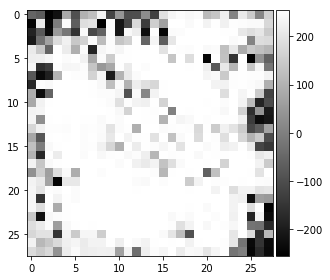

TARGET


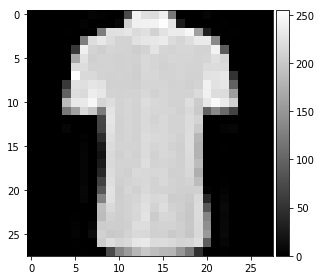

step  1000 / 1000 d_loss:  0.3716928958892822 g_loss:  0.742995
epoch 164 progress report:
latent shape:  (1, 100)
latent:  [[0.9419398  0.81139285 0.87959218 0.91774572 0.72329988 0.39584766
  0.3051248  0.18934058 0.30048175 0.47242706 0.10427859 0.89541682
  0.09405031 0.65894176 0.95980718 0.01934941 0.24238899 0.37754998
  0.2269003  0.54242212 0.92257757 0.68541504 0.70203721 0.81629972
  0.56602643 0.28278247 0.10089812 0.34236215 0.06892479 0.22795798
  0.51344468 0.85498536 0.3599691  0.44336743 0.23946042 0.65067283
  0.61171185 0.81567998 0.56571203 0.38839421 0.31048857 0.23972079
  0.32153373 0.27135729 0.22020823 0.89187233 0.22260397 0.32342556
  0.03827164 0.41740343 0.79406291 0.94787242 0.09234547 0.09342107
  0.60128199 0.55795055 0.70048256 0.07409666 0.28313267 0.9945383
  0.54641234 0.53509216 0.29368002 0.78712773 0.44704393 0.11335542
  0.22920626 0.28386528 0.45178865 0.41287117 0.86027827 0.2045641
  0.91690268 0.86815257 0.35759392 0.41714803 0.16314822 0.727

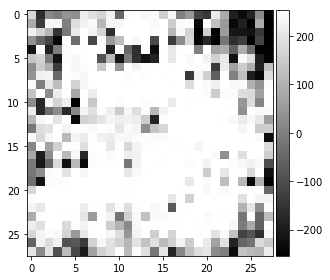

TARGET


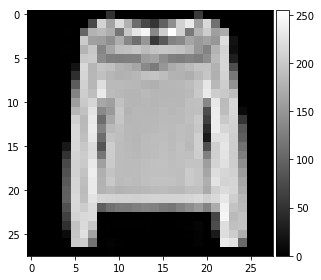

step  1000 / 1000 d_loss:  0.43684226274490356 g_loss:  0.74271065
epoch 165 progress report:
latent shape:  (1, 100)
latent:  [[0.74840151 0.29619895 0.37262933 0.11055175 0.65061958 0.64537739
  0.87291369 0.20196149 0.78120088 0.79819205 0.07720082 0.14295076
  0.03380135 0.92104043 0.60841613 0.88583575 0.55977065 0.26163447
  0.76928774 0.51372557 0.35394236 0.17221063 0.41761128 0.45175785
  0.67333316 0.2933052  0.46041623 0.25275243 0.56330957 0.97601767
  0.40474676 0.03423515 0.3910562  0.06929516 0.99725408 0.61212627
  0.98339826 0.29080877 0.97668976 0.68095607 0.05401347 0.25435214
  0.53605194 0.47919314 0.41865398 0.39473803 0.99261664 0.31567809
  0.60618215 0.36774727 0.20734875 0.6918     0.24241404 0.59407301
  0.64197404 0.32861688 0.16462461 0.66924956 0.32127932 0.0045566
  0.37121219 0.63634334 0.22680228 0.38459713 0.44033591 0.71955893
  0.0092585  0.45409169 0.55134582 0.35870368 0.42646496 0.02806928
  0.45188952 0.48104159 0.8890416  0.01524022 0.06956137 0

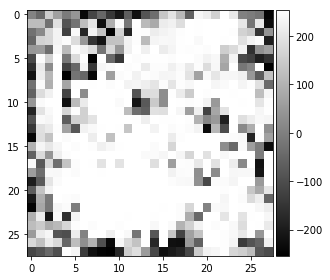

TARGET


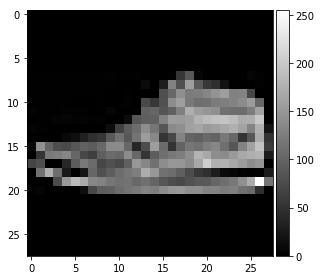

step  1000 / 1000 d_loss:  0.37796831130981445 g_loss:  0.7424218
epoch 166 progress report:
latent shape:  (1, 100)
latent:  [[0.42378488 0.92930486 0.54791483 0.50626267 0.11808289 0.53720335
  0.50138184 0.4957791  0.74306229 0.81983083 0.93349682 0.55394734
  0.25507514 0.00931228 0.97858285 0.41093476 0.87884345 0.80057192
  0.88515873 0.76016086 0.95160729 0.51821018 0.16708725 0.51818665
  0.99260349 0.55735902 0.53779557 0.62413711 0.69335797 0.49724903
  0.58595146 0.07975911 0.41064349 0.05295645 0.46355334 0.97823777
  0.84850372 0.45411635 0.72410318 0.64867126 0.11717564 0.81675888
  0.74801343 0.48291736 0.50196938 0.87491401 0.22806622 0.26089368
  0.57289606 0.25191929 0.59148953 0.58101323 0.60744302 0.29897001
  0.91608906 0.58459413 0.12766417 0.39446825 0.75135455 0.23746633
  0.80634342 0.0227933  0.38237436 0.23082842 0.52356748 0.83358138
  0.44350284 0.01557459 0.46312442 0.94506373 0.57724634 0.80942224
  0.84210472 0.87083813 0.87376611 0.22168557 0.94240347 0

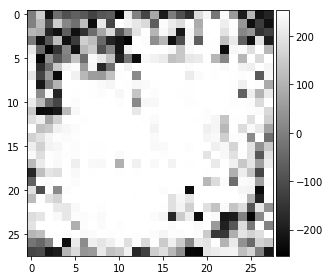

TARGET


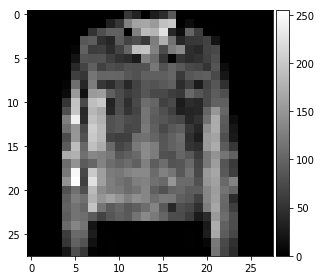

step  1000 / 1000 d_loss:  0.3712294101715088 g_loss:  0.7421222
epoch 167 progress report:
latent shape:  (1, 100)
latent:  [[0.87814865 0.29366383 0.73425605 0.72933074 0.92265469 0.68348868
  0.7927175  0.41562082 0.827713   0.94655229 0.16007049 0.348531
  0.47268546 0.71334346 0.50478179 0.00399817 0.70247585 0.15108035
  0.57313178 0.33044293 0.93857042 0.36593373 0.78315475 0.23367943
  0.76697898 0.92752834 0.8762266  0.26638208 0.92961558 0.86201342
  0.57886766 0.0712209  0.80907679 0.42285187 0.43410867 0.16920503
  0.90708647 0.00216116 0.77163499 0.21997925 0.6705695  0.84669427
  0.41671069 0.84954088 0.53338816 0.92919181 0.987898   0.74744728
  0.57575796 0.44020932 0.55051649 0.20650862 0.89362075 0.03857758
  0.40703925 0.5509782  0.58797243 0.02290297 0.32834242 0.45045205
  0.8919055  0.81447233 0.64300329 0.00215662 0.045711   0.91399819
  0.2968871  0.29198022 0.206856   0.83186255 0.83740772 0.57696816
  0.10918942 0.81779087 0.02812372 0.54118419 0.81236246 0.75

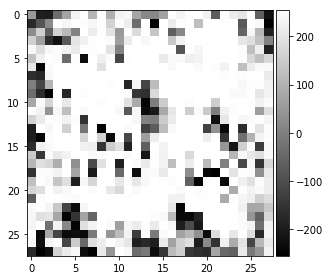

TARGET


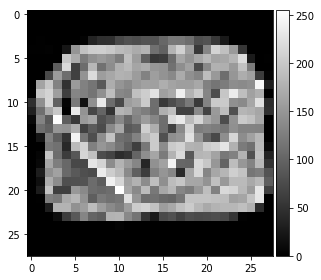

step  1000 / 1000 d_loss:  0.4880378842353821 g_loss:  0.7415686
epoch 168 progress report:
latent shape:  (1, 100)
latent:  [[0.62819098 0.06015227 0.81455566 0.45454367 0.88019936 0.54277264
  0.40442139 0.52043161 0.13434856 0.33957611 0.74236779 0.71860231
  0.1804253  0.14528369 0.18919654 0.0314915  0.26509814 0.01866799
  0.99941849 0.19826444 0.38068398 0.14432281 0.24580406 0.25374583
  0.64739669 0.96270256 0.11278509 0.31669786 0.76047375 0.96024695
  0.08636905 0.02291359 0.40143019 0.38878191 0.85424521 0.28509283
  0.42829576 0.84500121 0.05097875 0.94012625 0.49670427 0.70754188
  0.57463091 0.17878821 0.16893501 0.34295885 0.11111907 0.44009258
  0.25115503 0.60880615 0.53161992 0.13227273 0.05628982 0.71548665
  0.48020914 0.61591033 0.53488813 0.70167225 0.26510214 0.12286999
  0.82325427 0.13515637 0.48082014 0.95426379 0.33095845 0.11831806
  0.28969019 0.55848921 0.06381396 0.09624089 0.64651868 0.49299056
  0.96144002 0.33413479 0.82319209 0.96463431 0.59671891 0.

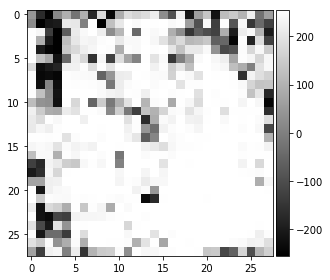

TARGET


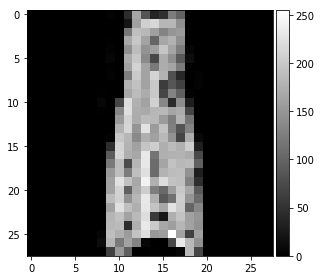

step  1000 / 1000 d_loss:  0.45831096172332764 g_loss:  0.7409104
epoch 169 progress report:
latent shape:  (1, 100)
latent:  [[4.59759269e-01 1.97493881e-01 1.52685112e-02 9.72125898e-01
  7.70930359e-01 1.72854900e-02 1.65920272e-01 4.85198389e-02
  4.88980978e-01 1.93032868e-01 4.40332741e-01 5.64047934e-04
  3.61274809e-01 6.92965753e-01 8.15252250e-01 9.37160211e-01
  3.01014327e-01 6.37309628e-01 6.10747298e-01 5.90150784e-01
  5.06283355e-01 8.56395029e-01 7.20720706e-01 1.04256830e-01
  5.82689592e-01 4.98329995e-02 3.77026373e-01 4.59511850e-01
  2.52719399e-01 5.84853088e-01 2.92134861e-01 8.75720350e-01
  8.86031989e-01 3.12670425e-01 2.69555440e-01 4.37130192e-01
  4.65489642e-01 2.70885604e-01 3.53024855e-01 8.85020964e-01
  9.15727507e-01 6.45452291e-01 6.83388631e-01 4.06151202e-01
  1.57315159e-01 6.85489695e-01 5.81838459e-01 8.71794401e-01
  9.46771586e-02 9.74831244e-01 8.04942587e-01 5.36364251e-01
  6.99246038e-01 6.89486952e-01 5.81193116e-03 6.69896800e-01
  4.47

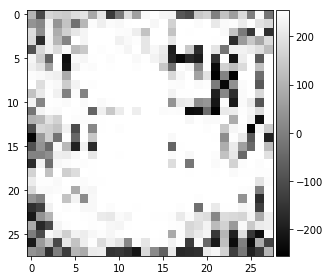

TARGET


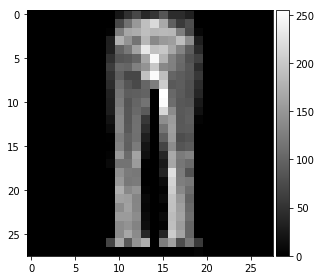

step  1000 / 1000 d_loss:  0.40093153715133667 g_loss:  0.7406635
epoch 170 progress report:
latent shape:  (1, 100)
latent:  [[0.23667807 0.17728768 0.82224585 0.14054106 0.07680525 0.42069803
  0.92677704 0.04514563 0.2032526  0.23594092 0.04611297 0.88585552
  0.07030018 0.47324153 0.4315999  0.55498503 0.26719937 0.61369178
  0.29790096 0.6750569  0.31819585 0.15733696 0.38092789 0.96899172
  0.82353181 0.00340591 0.84606678 0.08481977 0.84403393 0.23094672
  0.99167442 0.12311728 0.9778802  0.15347927 0.52996654 0.86933172
  0.20117209 0.12781904 0.18105796 0.10312661 0.19893045 0.68751024
  0.70463092 0.94855895 0.45542634 0.21535691 0.43922611 0.46934116
  0.99635234 0.53793739 0.03788819 0.32774118 0.44417665 0.83093764
  0.02439335 0.71216468 0.52506405 0.14769889 0.86400527 0.72043391
  0.92068072 0.18759032 0.02387276 0.4793847  0.25330007 0.73607746
  0.54878553 0.82897696 0.50650005 0.46148668 0.33517997 0.4476596
  0.55824689 0.25632711 0.40464011 0.34276182 0.80243517 0.

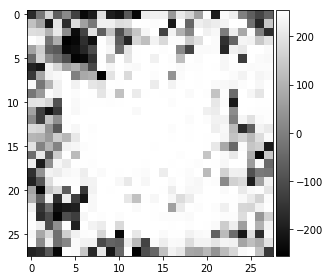

TARGET


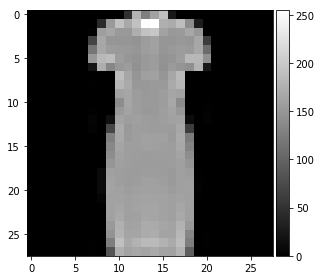

step  1000 / 1000 d_loss:  0.44854670763015747 g_loss:  0.74011046
epoch 171 progress report:
latent shape:  (1, 100)
latent:  [[0.91918469 0.60585203 0.02155671 0.51874258 0.27702989 0.90828827
  0.43951015 0.73211659 0.85228057 0.37074013 0.20542841 0.7208194
  0.04372655 0.01963568 0.50563818 0.04077592 0.11136812 0.60100994
  0.18809603 0.89545246 0.9232219  0.24336406 0.59362709 0.01832244
  0.7988952  0.77260915 0.82138554 0.65060937 0.2359929  0.78108488
  0.82689465 0.50093223 0.98266474 0.6291795  0.83257671 0.59360262
  0.33010771 0.25256465 0.99134246 0.06656215 0.58835695 0.45417383
  0.88276551 0.54229349 0.83875742 0.35355146 0.58082638 0.29058497
  0.46740504 0.62164983 0.34999855 0.20620635 0.3850363  0.91440329
  0.71981437 0.78586317 0.14416749 0.74671319 0.1824631  0.64007463
  0.19237729 0.96149684 0.4711692  0.68711253 0.55871986 0.99597047
  0.62748752 0.28420356 0.53526691 0.20623606 0.07996942 0.55410535
  0.3463381  0.66251754 0.67692243 0.97083983 0.92255566 0

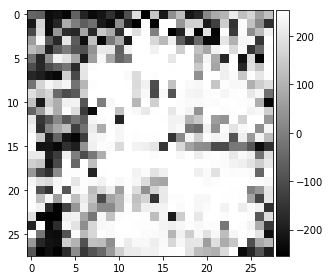

TARGET


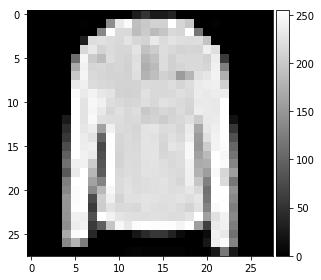

step  1000 / 1000 d_loss:  0.3702552914619446 g_loss:  0.7398271
epoch 172 progress report:
latent shape:  (1, 100)
latent:  [[0.57377641 0.53120399 0.85737475 0.56719979 0.56391932 0.99678215
  0.32706928 0.17878    0.92790965 0.81438775 0.72726645 0.23405457
  0.64826768 0.31748911 0.32817981 0.44542349 0.67983356 0.61727222
  0.15426316 0.96008473 0.71843969 0.10384376 0.1440323  0.66933767
  0.52595901 0.23714401 0.31482651 0.83843505 0.22208226 0.87895512
  0.68643511 0.91637718 0.95024059 0.17323464 0.01429942 0.53029818
  0.57178324 0.63777736 0.2306749  0.81717092 0.16675502 0.52391465
  0.26754915 0.35684476 0.94225771 0.28955479 0.52181016 0.58353728
  0.72142298 0.25735169 0.5612031  0.62020378 0.3936817  0.30570439
  0.47847326 0.59295546 0.31892509 0.21457624 0.97301394 0.53232692
  0.85836701 0.91436867 0.97038132 0.73531068 0.4593014  0.46116562
  0.14510954 0.78118304 0.82088316 0.30891871 0.07312267 0.95088091
  0.77381831 0.68336976 0.37853146 0.89176933 0.01836154 0.

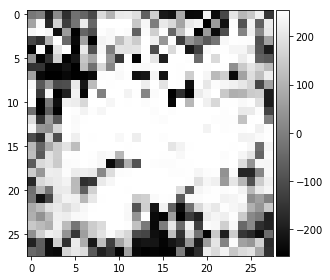

TARGET


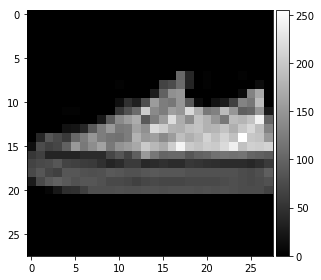

step  1000 / 1000 d_loss:  0.4878190755844116 g_loss:  0.73953986
epoch 173 progress report:
latent shape:  (1, 100)
latent:  [[0.39248321 0.1675237  0.71680044 0.18281625 0.58396185 0.05132004
  0.67678913 0.10423591 0.44270811 0.26065068 0.0233109  0.50321638
  0.72820709 0.94684731 0.15446235 0.25405572 0.76749082 0.41885035
  0.25786276 0.469672   0.83078825 0.32304127 0.9330222  0.68685706
  0.28052707 0.43715568 0.94824313 0.75461373 0.90803883 0.07658656
  0.26134607 0.54238463 0.57190627 0.5725479  0.12465708 0.9155586
  0.00978946 0.52162492 0.94934785 0.95545108 0.49478655 0.40499992
  0.1901983  0.38130971 0.30046999 0.82652271 0.60034503 0.25069844
  0.62288053 0.04827158 0.57041503 0.07455233 0.79318676 0.92398599
  0.6618175  0.87438832 0.49837785 0.20380986 0.04280344 0.55768232
  0.83254626 0.72673441 0.57478376 0.63870238 0.88834794 0.76893202
  0.37184661 0.10796249 0.95613278 0.14032844 0.39027238 0.73746277
  0.47122802 0.46036761 0.26921052 0.2048802  0.87926713 0.

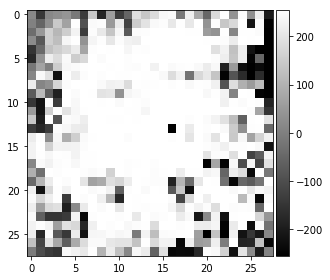

TARGET


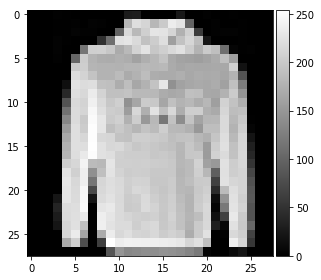

step  1000 / 1000 d_loss:  0.3715750575065613 g_loss:  0.7392492
epoch 174 progress report:
latent shape:  (1, 100)
latent:  [[1.50744455e-01 7.09106617e-01 5.96871638e-01 9.30487010e-03
  9.55388975e-01 1.13832047e-01 6.18492072e-01 6.48974713e-01
  7.80158765e-01 5.78403437e-01 9.12366611e-01 3.79641298e-01
  3.09257929e-01 9.44234443e-01 2.20475342e-01 2.83060338e-01
  5.82986939e-01 6.51542136e-01 8.13094593e-01 5.99314298e-01
  4.46316078e-01 7.51268236e-01 1.27442894e-01 2.76723744e-01
  9.19318971e-01 9.47243355e-01 6.86496338e-02 9.96381593e-01
  1.78737725e-01 3.32121535e-01 3.83816485e-01 7.64376551e-01
  5.28165920e-01 3.95147252e-01 4.86084217e-01 1.90760352e-01
  3.12778448e-01 3.86387055e-01 9.48663826e-01 4.41628432e-01
  3.51797705e-01 3.60926133e-01 7.81095648e-02 6.45089836e-03
  1.72852325e-01 1.35885894e-02 1.30435656e-01 9.97877833e-01
  1.28709374e-01 1.56465337e-01 7.77492468e-01 3.35427265e-01
  5.14983249e-02 4.10998436e-01 7.10179448e-01 7.60132576e-01
  7.359

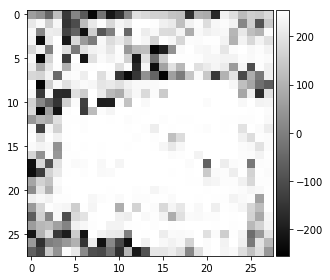

TARGET


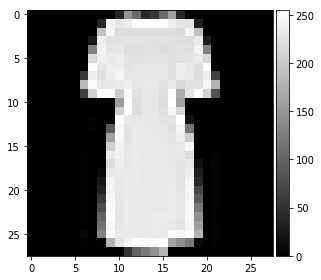

step  1000 / 1000 d_loss:  0.4301450550556183 g_loss:  0.7387295
epoch 175 progress report:
latent shape:  (1, 100)
latent:  [[0.30315556 0.29110781 0.94256875 0.93924106 0.09263242 0.64177459
  0.43597979 0.80529806 0.43326953 0.60248894 0.65834729 0.74272749
  0.87940559 0.72656445 0.26854583 0.01251562 0.66394852 0.86113268
  0.72138954 0.39794692 0.06809077 0.34254116 0.42621219 0.30287251
  0.43784232 0.60988266 0.67252896 0.04298094 0.5519532  0.8672026
  0.98942388 0.14911456 0.00208813 0.99089309 0.320841   0.62590848
  0.81844173 0.76967103 0.30776776 0.37711056 0.6414539  0.38855907
  0.22386948 0.95427643 0.30880874 0.33841247 0.19711772 0.7798555
  0.45378227 0.04543869 0.06302911 0.93474796 0.27615199 0.586431
  0.6249655  0.16878704 0.22365151 0.63196661 0.85295177 0.44007139
  0.79025648 0.68059787 0.49008943 0.69546434 0.83195681 0.37462008
  0.95909701 0.64111759 0.64361679 0.68707523 0.88324482 0.3002584
  0.57591041 0.61495325 0.99600561 0.60548071 0.84806769 0.45282

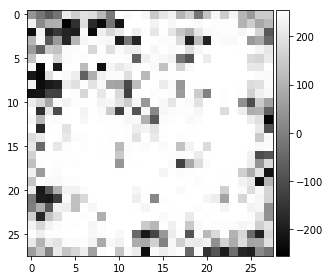

TARGET


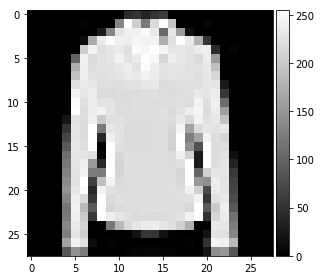

step  1000 / 1000 d_loss:  0.37700116634368896 g_loss:  0.73769337
epoch 176 progress report:
latent shape:  (1, 100)
latent:  [[0.76497785 0.82655453 0.57212458 0.23393945 0.38385686 0.4023546
  0.27780195 0.71391319 0.28751747 0.91069765 0.63471358 0.99595571
  0.53817433 0.65891356 0.34134507 0.14910299 0.97489156 0.5424114
  0.14026649 0.8925452  0.4714678  0.32528419 0.43256285 0.55718879
  0.73313762 0.46967353 0.44272689 0.97639997 0.25350562 0.32122812
  0.40786991 0.42127255 0.074865   0.96831617 0.08490866 0.77513478
  0.16734239 0.73432483 0.04935021 0.1129988  0.18951852 0.2243293
  0.80867902 0.87694446 0.69221696 0.12460414 0.69773205 0.80414593
  0.63957139 0.26924443 0.89600743 0.07110088 0.02546796 0.03017701
  0.16002264 0.48051137 0.63973772 0.3963119  0.54700981 0.45721575
  0.141025   0.22660877 0.36671338 0.73847634 0.5910972  0.75052171
  0.77463437 0.73536449 0.19917343 0.95412916 0.9541806  0.18289627
  0.38614673 0.49848006 0.49949301 0.01809904 0.63354517 0.3

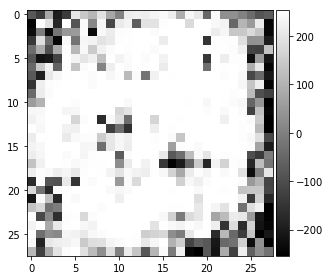

TARGET


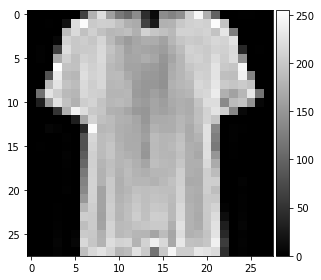

step  1000 / 1000 d_loss:  0.4035491347312927 g_loss:  0.7374722
epoch 177 progress report:
latent shape:  (1, 100)
latent:  [[0.93008326 0.26456963 0.11752667 0.21778503 0.00115767 0.91196246
  0.29914531 0.25243062 0.02575855 0.06285542 0.55189474 0.67273844
  0.07022751 0.66815248 0.30300093 0.91343398 0.46430821 0.95687053
  0.56060604 0.42388775 0.34405372 0.13729728 0.73098729 0.70658569
  0.55893582 0.00556765 0.14471269 0.62492169 0.93883383 0.03455317
  0.69531036 0.55499309 0.38138152 0.2799397  0.9386246  0.86450462
  0.39001851 0.5597539  0.49632965 0.60168473 0.61106507 0.9544751
  0.96749729 0.40938166 0.16028389 0.29911691 0.07648482 0.35978247
  0.86344815 0.33990066 0.70020473 0.58976879 0.48141783 0.60836149
  0.73980703 0.38887605 0.30411509 0.73116725 0.94898825 0.74968514
  0.62243785 0.69158435 0.90061028 0.7778065  0.54411831 0.53388703
  0.02557208 0.84344706 0.45673643 0.68933128 0.39002299 0.40532749
  0.51596046 0.33818541 0.7912772  0.86183793 0.84033095 0.3

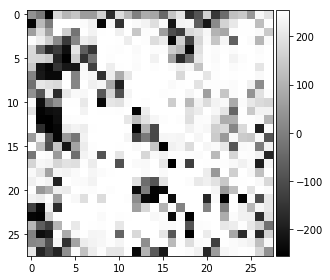

TARGET


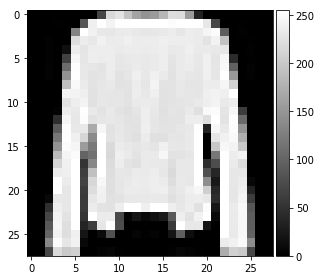

step  1000 / 1000 d_loss:  0.41030558943748474 g_loss:  0.7372348
epoch 178 progress report:
latent shape:  (1, 100)
latent:  [[0.70100016 0.41220993 0.42642662 0.06148512 0.21613672 0.28294223
  0.03040909 0.40552751 0.47549098 0.41589046 0.1889291  0.12600765
  0.43894047 0.82213423 0.57708805 0.76502278 0.55424678 0.95904534
  0.09066783 0.84623326 0.77626394 0.19705457 0.58823186 0.07006771
  0.76475146 0.39248783 0.08599164 0.60653937 0.08978837 0.12555894
  0.79956784 0.94331877 0.5808193  0.29476057 0.30123201 0.43792729
  0.35481942 0.59280193 0.7456322  0.30076346 0.9726811  0.38133764
  0.5864234  0.27288748 0.90369055 0.38853087 0.58630236 0.60911698
  0.27811163 0.34645584 0.39821823 0.73984661 0.3002638  0.94705369
  0.7439488  0.94922237 0.46765966 0.61666509 0.87773033 0.46640222
  0.4974058  0.06123527 0.99726284 0.6125833  0.03558526 0.45861847
  0.96062604 0.73224181 0.89191046 0.78395697 0.7499817  0.99168587
  0.04369369 0.44643401 0.61183052 0.45168106 0.85824693 0

TARGET


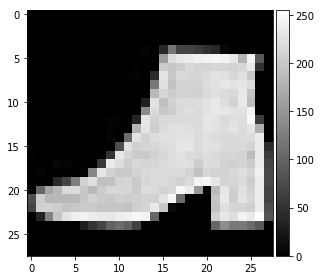

step  1000 / 1000 d_loss:  0.38649874925613403 g_loss:  0.7367897
epoch 179 progress report:
latent shape:  (1, 100)
latent:  [[0.03621722 0.46519567 0.88265416 0.78078419 0.57460837 0.22591054
  0.23792504 0.74060925 0.76707287 0.2599264  0.40885296 0.88866361
  0.4286022  0.73474349 0.07361338 0.3832705  0.12518924 0.14682647
  0.33323557 0.93527932 0.39035027 0.15340736 0.9096011  0.01909516
  0.61787204 0.4464387  0.34003954 0.8506503  0.3293907  0.65106538
  0.01417497 0.33045948 0.9086952  0.54020879 0.28639644 0.26936587
  0.83307283 0.89430885 0.16235889 0.76503166 0.21389048 0.0699265
  0.34433271 0.13039591 0.12645668 0.73547854 0.45094386 0.97325387
  0.01556802 0.36597892 0.64453103 0.774204   0.07151071 0.3799846
  0.54132605 0.79745888 0.63683825 0.27675052 0.46812288 0.17540637
  0.57944849 0.65300327 0.2449685  0.94211567 0.25031738 0.68393456
  0.02201181 0.37068597 0.91729077 0.69148017 0.13711569 0.57300337
  0.21825448 0.95065443 0.76725479 0.78990558 0.97253476 0.7

TARGET


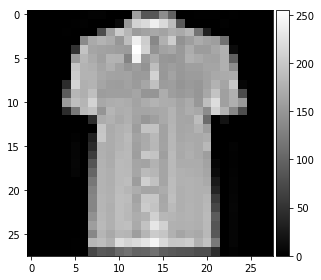

step  1000 / 1000 d_loss:  0.4034081995487213 g_loss:  0.73608625
epoch 180 progress report:
latent shape:  (1, 100)
latent:  [[0.33188496 0.12307976 0.0461522  0.71343887 0.05892519 0.13230394
  0.0520394  0.74062871 0.32753739 0.59003586 0.30765993 0.29517483
  0.83106186 0.72080956 0.55047591 0.54636557 0.5344555  0.07091505
  0.36014666 0.54331187 0.5817665  0.74190709 0.81414141 0.5284541
  0.24012189 0.04534491 0.09925277 0.07036224 0.99436263 0.40436872
  0.62895821 0.86169277 0.83484835 0.05212358 0.18649164 0.70354452
  0.38583545 0.54383325 0.23383791 0.0515289  0.92766948 0.36826784
  0.93981535 0.80673362 0.95282204 0.00804849 0.96723917 0.68542525
  0.67646544 0.25523644 0.34886325 0.55925026 0.91327777 0.34765557
  0.57183806 0.37436205 0.72189932 0.54085795 0.07609913 0.07575659
  0.83607823 0.67415452 0.15002216 0.35125492 0.38323096 0.30769968
  0.84524953 0.45556659 0.510816   0.57078203 0.4007259  0.05098621
  0.61037911 0.11183052 0.87512649 0.57911248 0.38604891 0.

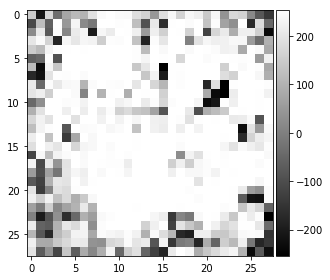

TARGET


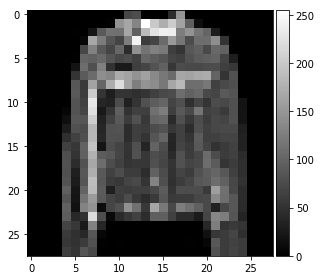

step  1000 / 1000 d_loss:  0.3959604501724243 g_loss:  0.73583895
epoch 181 progress report:
latent shape:  (1, 100)
latent:  [[0.75972577 0.5545156  0.90360543 0.83912447 0.075873   0.15318676
  0.89265991 0.24811424 0.92664217 0.29459732 0.80236459 0.87501851
  0.96213534 0.99960615 0.08879731 0.56361061 0.33109869 0.43038535
  0.92083197 0.07897815 0.13740608 0.63095503 0.01105866 0.58244848
  0.6295894  0.29115848 0.05090007 0.12221816 0.26034479 0.55966595
  0.35177038 0.84936548 0.52318316 0.5845805  0.66691959 0.37736914
  0.87399076 0.17986746 0.88867357 0.93497342 0.35187456 0.53927118
  0.37729988 0.26184952 0.16159481 0.92832531 0.77755511 0.80719226
  0.01006359 0.3579663  0.99317579 0.4127436  0.02754778 0.3854214
  0.39822332 0.68009897 0.41316661 0.10247842 0.39301665 0.2537681
  0.06540743 0.40636772 0.02109218 0.03537101 0.60562113 0.75297423
  0.69778625 0.77819005 0.76431012 0.06153479 0.11433233 0.51083164
  0.66707034 0.48793615 0.64501608 0.49458508 0.34524424 0.8

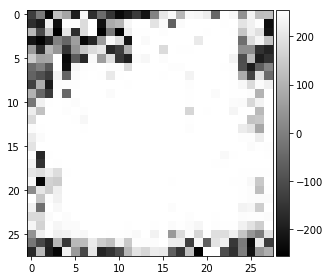

TARGET


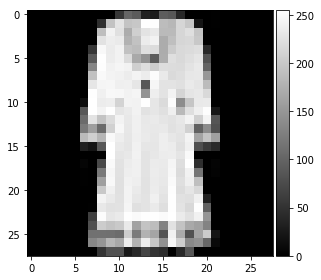

step  1000 / 1000 d_loss:  0.4535023868083954 g_loss:  0.7355471
epoch 182 progress report:
latent shape:  (1, 100)
latent:  [[0.80890043 0.96423119 0.86345059 0.80577289 0.10509848 0.35100185
  0.18163496 0.37485558 0.39644164 0.00659602 0.34952897 0.51912487
  0.00690491 0.55456183 0.03523746 0.07836906 0.29222718 0.97660226
  0.37434257 0.51520262 0.26307306 0.89610331 0.10311012 0.90140568
  0.179238   0.29801771 0.16430138 0.63239088 0.33709937 0.99626412
  0.23874016 0.20038529 0.98128005 0.58402767 0.71533687 0.98047485
  0.50493439 0.3976756  0.83538391 0.18756044 0.82167533 0.88244841
  0.30557369 0.29909125 0.50168799 0.09672469 0.11253471 0.64792694
  0.86417895 0.71796947 0.57545002 0.87554644 0.49945527 0.70627445
  0.48221624 0.80441584 0.07558857 0.27293312 0.39182268 0.65425001
  0.79649491 0.82847757 0.0796041  0.53750784 0.53961545 0.72568026
  0.65322802 0.0111282  0.45690746 0.15785408 0.99874609 0.12554646
  0.08713137 0.20738721 0.02485465 0.47999474 0.17836758 0.

TARGET


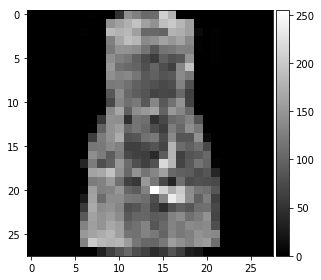

step  1000 / 1000 d_loss:  0.37839260697364807 g_loss:  0.7352554
epoch 183 progress report:
latent shape:  (1, 100)
latent:  [[7.94241406e-01 5.27995038e-01 9.51195089e-01 4.60273115e-01
  5.24636579e-04 3.32035235e-01 1.42923333e-02 2.73492868e-01
  9.73128214e-01 7.46763480e-01 2.41452323e-01 1.81729301e-01
  7.95257296e-01 5.31502513e-01 5.74968052e-01 5.94934348e-01
  4.26415830e-01 7.69394603e-01 3.84529565e-02 4.53982422e-01
  1.47836962e-01 1.95691529e-01 6.18457253e-01 8.33709218e-01
  5.59431873e-01 9.87306540e-01 2.88571096e-02 1.03176355e-01
  6.07659688e-01 9.61655405e-01 4.97416196e-01 5.03439951e-02
  3.94048149e-01 1.09299095e-01 4.56489488e-01 5.76078436e-02
  7.98916251e-01 4.25011211e-01 7.09222422e-01 7.73520358e-01
  5.80603923e-01 8.77197002e-01 7.71015068e-01 8.35889544e-01
  1.26433950e-01 7.22045140e-02 6.72988828e-01 8.45940206e-01
  7.22597774e-01 9.88697660e-02 8.75164052e-01 7.99866641e-01
  4.32470505e-01 7.22296725e-01 7.31997331e-01 6.05701886e-01
  7.01

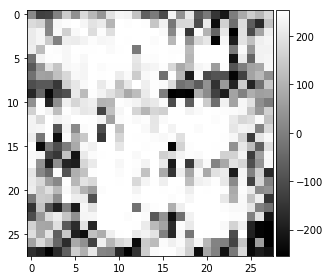

TARGET


step  1000 / 1000 d_loss:  0.4015023708343506 g_loss:  0.73496
epoch 184 progress report:
latent shape:  (1, 100)
latent:  [[0.02586305 0.21114798 0.9002026  0.15150134 0.59015398 0.96530315
  0.29351146 0.14369593 0.53178496 0.85821946 0.48678548 0.95952899
  0.11203963 0.24252473 0.76058093 0.18903286 0.57679399 0.42697069
  0.09171278 0.83009421 0.84830411 0.13001541 0.94788974 0.50998272
  0.2012094  0.21921068 0.50933913 0.03377292 0.18481167 0.78238756
  0.48976544 0.4743514  0.16768401 0.58453814 0.6439752  0.06648585
  0.24680124 0.20938688 0.0618847  0.12110028 0.36695042 0.70044573
  0.34387984 0.7930843  0.84664145 0.89739978 0.29750278 0.05029378
  0.44891254 0.23651422 0.86472454 0.44074235 0.86604343 0.02826669
  0.60950523 0.11192926 0.83081072 0.39042478 0.34668964 0.33356388
  0.32567329 0.79786106 0.77622329 0.83244538 0.49676293 0.82448464
  0.37501381 0.6625093  0.55033467 0.51390439 0.7085784  0.17821875
  0.16651077 0.75647083 0.23494116 0.90514668 0.23116347 0.61

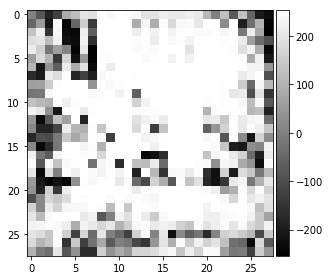

TARGET


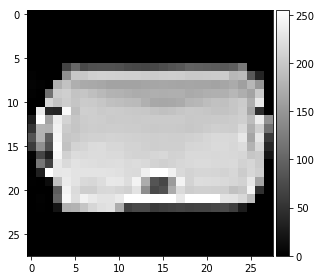

step  1000 / 1000 d_loss:  0.3936918079853058 g_loss:  0.73466563
epoch 185 progress report:
latent shape:  (1, 100)
latent:  [[0.75239198 0.02249587 0.68636497 0.51560591 0.35216965 0.5998186
  0.77118899 0.67061072 0.33354054 0.26432536 0.6312101  0.51612684
  0.59868326 0.97407831 0.41076501 0.82867776 0.8262065  0.46841249
  0.93222768 0.38759235 0.56010419 0.70806669 0.67573552 0.28761142
  0.44740173 0.37441635 0.80893296 0.10312114 0.29057821 0.31483204
  0.71286889 0.04155438 0.22550314 0.73664089 0.5693613  0.41610328
  0.82066939 0.33934884 0.48596315 0.97315629 0.65151182 0.15497671
  0.42211307 0.10436472 0.66900258 0.78422076 0.62313377 0.38622201
  0.59896665 0.07592388 0.28750289 0.89241474 0.43116458 0.84152282
  0.98317429 0.58861719 0.59960273 0.59183471 0.74284634 0.35270994
  0.79377529 0.1317612  0.0090601  0.66934818 0.90042203 0.42666786
  0.0832009  0.70244758 0.10732386 0.2610196  0.87504284 0.4744389
  0.08624749 0.80731532 0.3133769  0.86768915 0.01703823 0.3

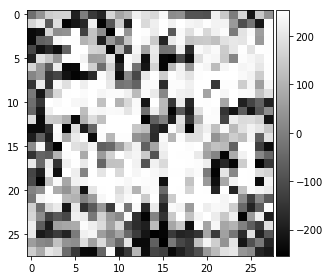

TARGET


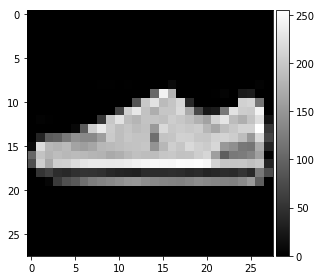

step  1000 / 1000 d_loss:  0.3681613802909851 g_loss:  0.7337653
epoch 186 progress report:
latent shape:  (1, 100)
latent:  [[0.25988101 0.28058242 0.0094569  0.07861423 0.20487179 0.54306881
  0.48090641 0.2229084  0.68539775 0.43646776 0.73252176 0.08714724
  0.15838615 0.8967872  0.05289551 0.01659237 0.78718108 0.47967577
  0.48917744 0.3056442  0.06165594 0.17041727 0.82037218 0.1771585
  0.87050533 0.33634398 0.84372562 0.83946111 0.06853754 0.20029928
  0.73197025 0.52553681 0.73077918 0.48935335 0.87463922 0.47469452
  0.84089294 0.22539884 0.64095636 0.61323071 0.05230405 0.98577238
  0.22632274 0.23254861 0.7188063  0.52995236 0.06944907 0.1156019
  0.94084105 0.72218725 0.69308593 0.06093458 0.08203073 0.85168593
  0.10256891 0.13061954 0.33911151 0.77905941 0.42536224 0.61383559
  0.79654333 0.86224042 0.20954868 0.8546457  0.00300851 0.12226119
  0.72708812 0.4319036  0.75040982 0.90714154 0.07261968 0.7398133
  0.44915055 0.8046096  0.94318315 0.9258618  0.01737553 0.795

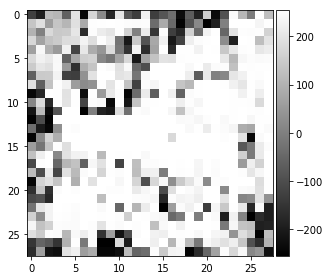

TARGET


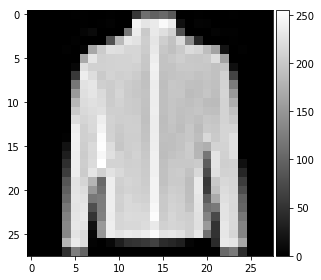

step  1000 / 1000 d_loss:  0.4669448435306549 g_loss:  0.73318076
epoch 187 progress report:
latent shape:  (1, 100)
latent:  [[6.40082965e-01 7.50332964e-01 6.33968197e-01 2.98684023e-02
  2.28254923e-01 4.91820852e-01 7.28840688e-01 9.76380874e-01
  2.69528906e-01 9.35089437e-01 1.27455903e-02 6.47314582e-01
  8.87136039e-01 2.44250292e-01 4.39740767e-01 5.03744488e-01
  4.13566954e-01 5.22057586e-01 1.52450551e-01 3.27013627e-01
  3.32474571e-01 4.25323472e-01 3.19293063e-01 7.69643821e-01
  6.91576375e-02 6.10199431e-01 5.49620563e-01 1.10019122e-01
  3.95734000e-01 6.91198588e-01 4.90856208e-01 3.90589757e-02
  8.51368063e-01 1.46021786e-01 3.00890712e-01 7.41497011e-01
  8.30061663e-01 6.57555735e-01 5.67010553e-01 6.50900656e-01
  1.49228082e-01 9.92559481e-01 3.61647631e-01 4.53920455e-01
  4.54528144e-01 4.74372489e-01 7.44325514e-01 2.46019116e-01
  3.61490328e-01 9.38699244e-01 8.50309918e-01 1.57612468e-01
  7.42747723e-01 3.96072245e-01 7.44202378e-01 1.03664941e-01
  2.10

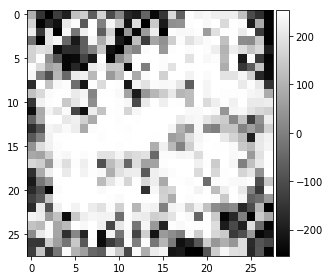

TARGET


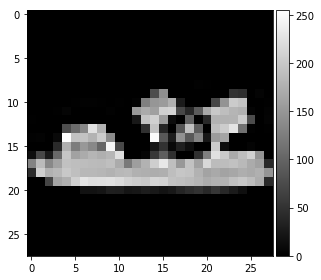

step  1000 / 1000 d_loss:  0.4114340543746948 g_loss:  0.73287797
epoch 188 progress report:
latent shape:  (1, 100)
latent:  [[0.02856961 0.79308949 0.49071683 0.04640427 0.69991182 0.16768288
  0.69881757 0.86229722 0.81727134 0.13524228 0.53049533 0.63809795
  0.63659768 0.69463166 0.31766747 0.80142614 0.63094319 0.36963936
  0.31036372 0.50009968 0.41154802 0.06513559 0.70457329 0.19752933
  0.35958233 0.23633691 0.393442   0.70692052 0.17088294 0.03984886
  0.97832044 0.39603333 0.13673835 0.48482643 0.42138019 0.83145805
  0.19883292 0.65462434 0.90644255 0.67296088 0.81464704 0.23065304
  0.2627635  0.60343186 0.25359253 0.295224   0.2994449  0.73463386
  0.38913533 0.00952896 0.40775772 0.2440112  0.65414997 0.45424714
  0.32488562 0.13706432 0.80352402 0.3179641  0.07212599 0.02961037
  0.2950469  0.39711763 0.4157697  0.95153928 0.88946156 0.80547862
  0.49188987 0.85030046 0.48507038 0.99699753 0.46844865 0.32305609
  0.86664735 0.37968663 0.57687129 0.99295364 0.67049619 0

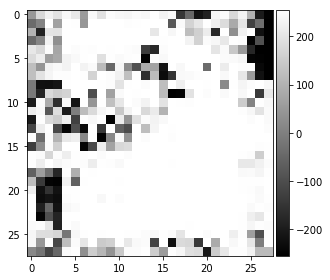

TARGET


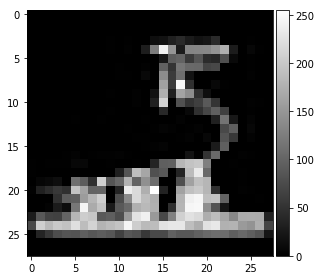

step  1000 / 1000 d_loss:  0.3861638903617859 g_loss:  0.7325741
epoch 189 progress report:
latent shape:  (1, 100)
latent:  [[7.37045499e-01 9.70166091e-01 6.93883286e-02 1.66330551e-01
  7.01432259e-03 9.81502798e-01 4.73581853e-01 6.54493360e-01
  2.50923912e-01 2.72009741e-01 4.98995343e-01 7.03607533e-01
  9.05990531e-01 9.13587216e-01 7.11128493e-01 9.74234970e-01
  3.99638721e-01 3.54383334e-01 5.60332494e-01 2.26314792e-01
  4.12689792e-02 3.27230199e-01 8.74419740e-02 8.75635670e-01
  6.20185107e-01 9.44567100e-01 5.93128140e-01 1.90469910e-01
  1.57993683e-02 6.70598130e-01 7.52089063e-01 8.57766568e-04
  2.80858223e-01 9.61559843e-01 6.93434578e-01 2.33939298e-03
  7.39008499e-01 4.45658520e-01 7.85556063e-01 6.06053808e-01
  8.58308094e-01 1.38341822e-01 6.01162778e-01 8.45913719e-01
  9.08513696e-01 3.55821728e-01 1.20452535e-01 2.10684220e-01
  2.29139664e-01 8.31200796e-01 6.84088485e-01 5.94735207e-01
  2.58589805e-01 5.86876523e-01 5.16896818e-01 7.23779628e-01
  3.610

TARGET


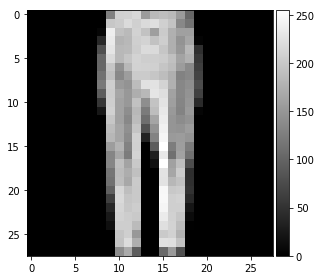

step  1000 / 1000 d_loss:  0.366493284702301 g_loss:  0.7322687
epoch 190 progress report:
latent shape:  (1, 100)
latent:  [[0.53116003 0.80141365 0.74989581 0.44899664 0.51409659 0.59990589
  0.41668689 0.49788639 0.6394606  0.28067103 0.8186241  0.15415135
  0.38419943 0.99597186 0.76688986 0.55724076 0.89924321 0.23704716
  0.16400576 0.10848143 0.47092952 0.61429163 0.38016853 0.46007117
  0.93793519 0.00973253 0.93054592 0.90306886 0.23295253 0.46517552
  0.55173241 0.65191411 0.14623945 0.04275306 0.08919105 0.35112819
  0.70480583 0.28018021 0.52806723 0.2876284  0.34839017 0.57626692
  0.7927317  0.13925618 0.64213755 0.07533851 0.77270486 0.85292446
  0.17710933 0.12095966 0.22352426 0.59225453 0.56482781 0.51314712
  0.98280659 0.55230587 0.08916611 0.04125714 0.88389806 0.95176676
  0.64225256 0.17284126 0.29076887 0.14865458 0.15767417 0.45825644
  0.09874541 0.11609059 0.73352943 0.16060391 0.40862177 0.18363002
  0.30705693 0.16558449 0.6991463  0.0689196  0.523846   0.2

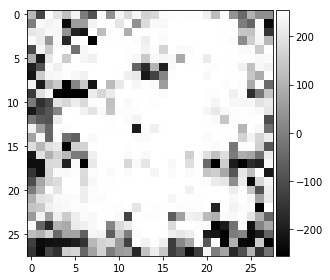

TARGET


step  1000 / 1000 d_loss:  0.3661402463912964 g_loss:  0.73164153
epoch 191 progress report:
latent shape:  (1, 100)
latent:  [[0.63583752 0.80657812 0.84944044 0.02162741 0.2934654  0.80669419
  0.04707131 0.62253716 0.06145509 0.93231053 0.70876236 0.01707891
  0.48968143 0.53012548 0.46926629 0.97548924 0.7992102  0.32949335
  0.13260111 0.51678639 0.34273659 0.19909959 0.32344219 0.16752801
  0.89588668 0.15752572 0.85167442 0.78166337 0.95676702 0.99993944
  0.03156849 0.77157948 0.58596961 0.1965631  0.95531263 0.42295502
  0.81452133 0.3650045  0.93088144 0.54598193 0.85110721 0.57724139
  0.52552952 0.58224539 0.32164624 0.72248136 0.1226019  0.4805949
  0.19744135 0.09319064 0.57883508 0.77980151 0.34466233 0.29423063
  0.89764077 0.48742242 0.33769493 0.31721232 0.7062437  0.37576204
  0.05330869 0.10969018 0.40076228 0.04354133 0.2286496  0.50138603
  0.11369732 0.22274761 0.96723445 0.61044592 0.29992879 0.87839669
  0.00350054 0.19690434 0.85193158 0.80869824 0.85433474 0.

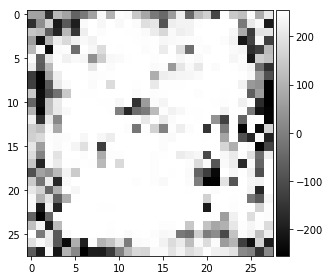

TARGET


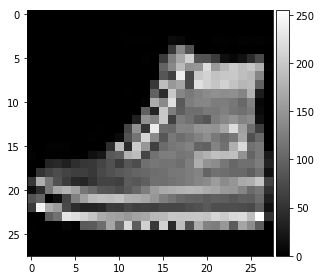

step  1000 / 1000 d_loss:  0.42329055070877075 g_loss:  0.7313297
epoch 192 progress report:
latent shape:  (1, 100)
latent:  [[0.84008992 0.22739553 0.29207052 0.34198692 0.45436355 0.52343424
  0.47062617 0.99994864 0.26151985 0.56102753 0.28074843 0.14745493
  0.69525364 0.62985124 0.17495776 0.55121344 0.8276958  0.33343842
  0.49505677 0.56186229 0.50737945 0.21071289 0.975175   0.20619637
  0.85712316 0.98068143 0.94360754 0.14005644 0.31007467 0.66497474
  0.21933728 0.40342105 0.59865926 0.69887928 0.40714232 0.51564918
  0.50645778 0.45280497 0.71086356 0.21773365 0.57555557 0.11269503
  0.75851112 0.63410622 0.50632032 0.82565462 0.97197928 0.42490841
  0.18375218 0.54811806 0.59766556 0.37358095 0.91454919 0.4662181
  0.60485045 0.32241037 0.40147548 0.57821963 0.3133695  0.57619621
  0.3861704  0.42278557 0.64729402 0.49777241 0.04985628 0.84822688
  0.58851978 0.46328245 0.12245109 0.59949668 0.1166139  0.07766371
  0.96025527 0.45642478 0.35320706 0.6475757  0.46247868 0.

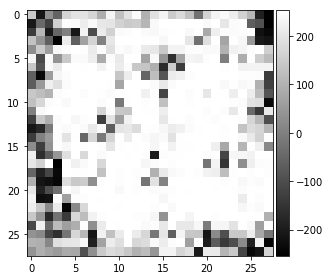

TARGET


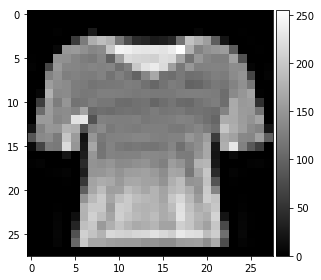

step  1000 / 1000 d_loss:  0.4892009496688843 g_loss:  0.73103255
epoch 193 progress report:
latent shape:  (1, 100)
latent:  [[0.2229044  0.34527851 0.78825398 0.24866111 0.89741684 0.50858671
  0.36296255 0.03225689 0.46854366 0.0715624  0.51318926 0.31694779
  0.07179105 0.37985093 0.56589    0.7787977  0.12384561 0.19904606
  0.8692288  0.69658088 0.68182864 0.87490321 0.59792654 0.35160843
  0.8420542  0.71645437 0.94813962 0.51207759 0.3990903  0.55577487
  0.6632422  0.48125257 0.11157701 0.05642659 0.13568824 0.28912537
  0.68806094 0.67648947 0.63304991 0.23501759 0.1928774  0.30948093
  0.98487685 0.26649913 0.66158799 0.55132932 0.39857104 0.39031696
  0.91546833 0.85636293 0.02969093 0.66088774 0.27317742 0.52079698
  0.7271414  0.51987732 0.61953228 0.24689429 0.58759516 0.20864285
  0.45004653 0.15720714 0.46045198 0.8591762  0.27502973 0.0191395
  0.55725968 0.13889084 0.84368551 0.62566228 0.90325562 0.12046566
  0.11257068 0.7706393  0.66164905 0.18406565 0.53392614 0.

TARGET


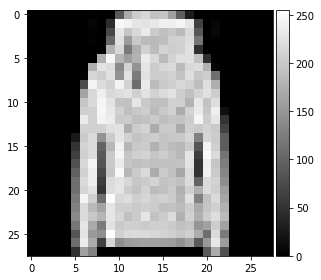

step  1000 / 1000 d_loss:  0.47329166531562805 g_loss:  0.73047966
epoch 194 progress report:
latent shape:  (1, 100)
latent:  [[0.63884736 0.26414101 0.30926773 0.97084995 0.78847731 0.71496628
  0.18003285 0.86610238 0.27916544 0.14019252 0.39143163 0.67748645
  0.86477154 0.50872552 0.1028805  0.02955401 0.59620289 0.12775415
  0.12853038 0.00594998 0.60159506 0.643826   0.95521408 0.68680088
  0.10585894 0.67910172 0.19322895 0.46044634 0.55034114 0.86469325
  0.12177522 0.37466031 0.79538925 0.93146465 0.0733435  0.07766268
  0.00739257 0.27933755 0.36143001 0.62644756 0.85520614 0.25125063
  0.61302188 0.56088463 0.89480281 0.27442391 0.19679006 0.68532287
  0.08120743 0.80740035 0.60200801 0.24504436 0.26997781 0.99521458
  0.43962906 0.92434198 0.45202259 0.92358779 0.21295671 0.69110658
  0.29797371 0.72997548 0.3574869  0.27364849 0.47418585 0.22794149
  0.37347825 0.48854    0.96779887 0.41744026 0.48037428 0.34489775
  0.55442937 0.9288294  0.59328131 0.68231807 0.70784244 

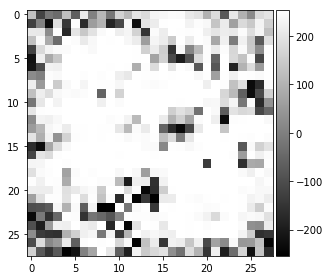

TARGET


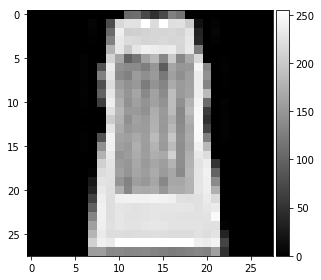

step  1000 / 1000 d_loss:  0.41581013798713684 g_loss:  0.7302047
epoch 195 progress report:
latent shape:  (1, 100)
latent:  [[0.11433943 0.13341622 0.51900771 0.92031036 0.80927969 0.10884441
  0.87738537 0.92716474 0.45241657 0.30310721 0.07620382 0.14042642
  0.50605748 0.1690047  0.08816822 0.02155876 0.24864541 0.6077291
  0.95110819 0.11773941 0.34515122 0.13699781 0.19059696 0.02603827
  0.42738808 0.97640703 0.79483943 0.89834663 0.1930679  0.34894661
  0.46662077 0.11806547 0.54782767 0.79698505 0.04284162 0.56898165
  0.32936186 0.40177116 0.06511971 0.26720325 0.76364854 0.90976471
  0.17077233 0.97664515 0.63702934 0.09396973 0.00926958 0.44199901
  0.28102465 0.86318703 0.01467829 0.48605764 0.03307667 0.93705356
  0.31991215 0.37073016 0.43464468 0.16262499 0.99896756 0.98699294
  0.83069055 0.97323942 0.30854359 0.00515587 0.88461754 0.67953036
  0.97206008 0.20259522 0.2443809  0.88629283 0.46996834 0.69768953
  0.3332216  0.88438626 0.78822605 0.04094882 0.2549769  0.

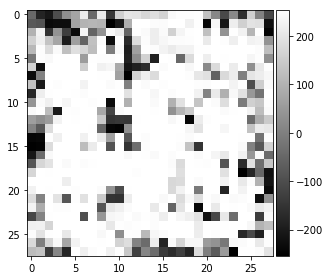

TARGET


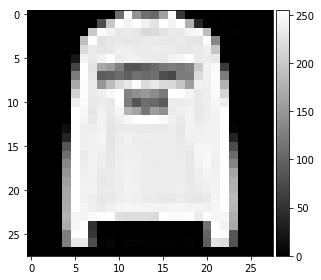

step  1000 / 1000 d_loss:  0.3651123344898224 g_loss:  0.72991633
epoch 196 progress report:
latent shape:  (1, 100)
latent:  [[0.51905832 0.8913772  0.98520736 0.46086884 0.15075405 0.90619746
  0.13581524 0.16708508 0.59460616 0.19608649 0.33920398 0.09728383
  0.59175107 0.52216433 0.13129859 0.90421815 0.9067529  0.08818039
  0.63935364 0.76021673 0.56504695 0.64191606 0.87572141 0.71742524
  0.55457184 0.96610988 0.19595348 0.75865539 0.81494666 0.40039731
  0.70222569 0.26074281 0.67570796 0.56650009 0.59705858 0.06593101
  0.65929094 0.31874529 0.65432997 0.53540903 0.52620354 0.05840001
  0.89964359 0.75832324 0.47647712 0.07671402 0.74020434 0.67752766
  0.66566212 0.91265077 0.49919436 0.61264409 0.89820756 0.97754818
  0.82014491 0.74883301 0.06824424 0.87580616 0.55618234 0.38688766
  0.02850519 0.57799104 0.5447241  0.25425987 0.15714248 0.94593635
  0.37826582 0.05079777 0.96964677 0.42319733 0.44712226 0.1456739
  0.29883223 0.26034675 0.73486981 0.85321402 0.34637471 0.

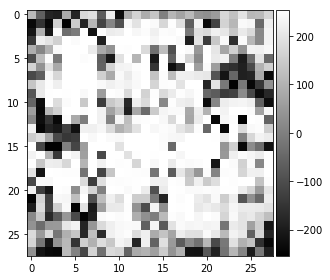

TARGET


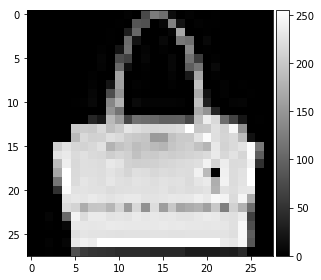

step  1000 / 1000 d_loss:  0.3654777407646179 g_loss:  0.7296172
epoch 197 progress report:
latent shape:  (1, 100)
latent:  [[0.45453978 0.72602215 0.08253597 0.35129398 0.73406496 0.99788915
  0.53516924 0.43265267 0.62209092 0.56263591 0.82465058 0.45200318
  0.21944937 0.9817752  0.94678678 0.33432139 0.20226961 0.16132935
  0.20855009 0.01099453 0.02400358 0.18260278 0.84733683 0.3120412
  0.27064307 0.52337403 0.81500471 0.15823635 0.22197561 0.17876588
  0.21987606 0.01025286 0.45197129 0.10187559 0.46347621 0.87323686
  0.38582636 0.94646229 0.57557889 0.36262202 0.59366533 0.22583413
  0.73427394 0.92271743 0.70312374 0.10356423 0.48521029 0.41310969
  0.16912112 0.21049839 0.72720145 0.39982561 0.42262477 0.82953694
  0.19886933 0.19448622 0.48757565 0.69682101 0.03305891 0.94015375
  0.10140028 0.45240932 0.3424481  0.64344812 0.49423361 0.53748792
  0.1684856  0.40131349 0.40642066 0.94210399 0.05802343 0.38118853
  0.31565306 0.95792308 0.91340073 0.91997722 0.05643352 0.4

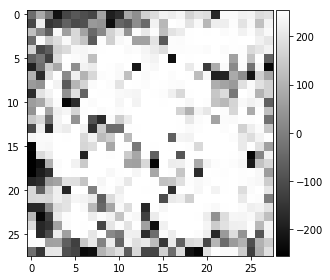

TARGET


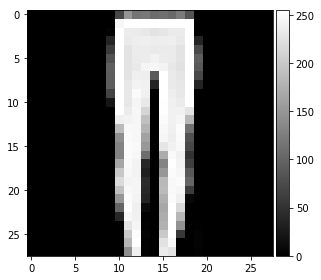

step  1000 / 1000 d_loss:  0.36629509925842285 g_loss:  0.72931147
epoch 198 progress report:
latent shape:  (1, 100)
latent:  [[0.73531953 0.69530181 0.93081881 0.67433131 0.10503701 0.11763157
  0.97607155 0.5723319  0.87247981 0.06006561 0.84788055 0.92707195
  0.97855604 0.74910266 0.16582099 0.66361585 0.89396534 0.41579905
  0.46823833 0.81529812 0.55599829 0.73986541 0.37200995 0.51577225
  0.2412878  0.99846188 0.9465553  0.68357285 0.51187289 0.64109868
  0.91654924 0.05155981 0.74340422 0.79063584 0.2883612  0.12908683
  0.20031097 0.7169873  0.39660477 0.04189818 0.72561661 0.94735165
  0.85034075 0.65660699 0.40766246 0.55681451 0.45507855 0.86446809
  0.04815365 0.28398193 0.80733573 0.39811488 0.32578006 0.52675048
  0.30857952 0.94536837 0.92303799 0.79436859 0.01322537 0.19344273
  0.42053862 0.00954666 0.65821511 0.06371494 0.91722632 0.3709175
  0.30661904 0.23306849 0.10000875 0.09308501 0.39312571 0.4020964
  0.23177183 0.21071123 0.26919169 0.48756194 0.34129597 0.

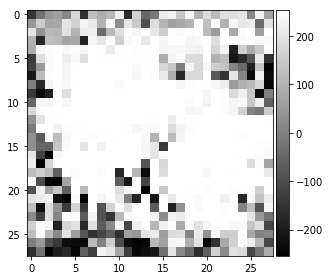

TARGET


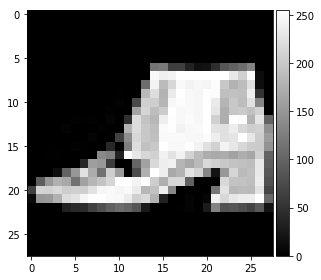

step  1000 / 1000 d_loss:  0.36525386571884155 g_loss:  0.7287483
epoch 199 progress report:
latent shape:  (1, 100)
latent:  [[0.58941546 0.48178793 0.45531964 0.82110314 0.70294464 0.99810944
  0.61026455 0.18043071 0.8211574  0.43136853 0.93630422 0.12420146
  0.69524995 0.69763096 0.14926225 0.57256072 0.3635419  0.50311956
  0.3563857  0.66381685 0.42019754 0.59885123 0.45626253 0.84377727
  0.24762274 0.33563153 0.99032265 0.71447192 0.79627388 0.36096917
  0.25606242 0.35367309 0.77275704 0.80281112 0.03375706 0.67909738
  0.55340268 0.04709137 0.94934048 0.63894936 0.21235332 0.47434408
  0.00125716 0.59334663 0.15596821 0.51372257 0.2467738  0.26102793
  0.3619591  0.08097628 0.47956267 0.28481877 0.14762868 0.95053802
  0.42725558 0.45216396 0.08042282 0.50122601 0.25847012 0.91255196
  0.6577823  0.45277496 0.11314989 0.21523943 0.79040456 0.38205161
  0.82548711 0.16753229 0.60078975 0.5495244  0.75439259 0.00193171
  0.09540945 0.71207223 0.26899673 0.04088517 0.90272055 0

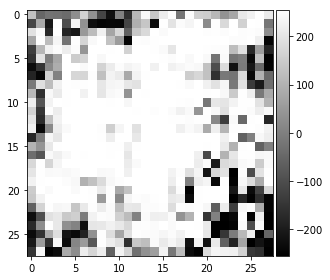

TARGET


(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [23]:
data_train = DataProvider(metadata_train, False, get_input_vector=flat_vector)
data_test = DataProvider(metadata_test, False, get_input_vector=flat_vector)
current_model.train(200, data_train, data_test, verbose=True, pretrain_discriminator=False)

In [9]:
from __future__ import print_function, division
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
from math import log

In [10]:
class DataProvider2():

    metadata = None
    batch_size = 1 # because I get OOM otherwise
    
    def __init__(self, metadata, first_category_only=False, get_input_vector=flat_vector):
        self.metadata = metadata
        self.first_category_only = first_category_only
        self.get_input_vector = get_input_vector
    
    def __len__(self):
        return len(self.metadata)
    
    def get_batch(self):
        x, y = self._get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        np.swapaxes(x, 0,1)
        return x, y

    # note to self for the future: optimize the batches to use np arrays from the getgo?
    def _get_batch(self, batch_size, metadata):
        img_x, img_y = 160, 448
        batch_x = np.zeros((batch_size, img_x, img_y, 1), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y, 1), dtype=float)
        datum_index = random.randint(0, len(metadata)-1)
        #batch_y = np.asarray(metadata[datum_index], dtype=float)
        #batch_y = np.reshape(batch_y, (img_x, img_y))
        #batch_y /= 255.0
        #latent_category = 1
        batch_x = self.get_input_vector(batch_y, None)
        #return batch_x.reshape(1,-1), np.expand_dims(np.expand_dims(batch_y, axis=3), axis=0)

        img_x, img_y = 160, 448

            
        for i in range(batch_size):
            img_scaled = None
            datum_index = random.randint(0, len(metadata)-1)
            j = 0
            while img_scaled is None:
                metadatum = metadata[(datum_index + j) % len(metadata)]
                latent_category = class_to_id[metadatum[0]]
                if latent_category == num_classes-1 or self.first_category_only is False:
                    img_scaled = self.get_image(metadata, (datum_index + j) % len(metadata))
                else:
                    img_scaled = None
                j += 1
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2, 1))
            # normalize channel values
            if img_downscaled.shape[1] < img_y:
                batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y - img_downscaled.shape[1]), (0, 0)), 'maximum')
            else:
                batch_y[i] = img_downscaled[:,:img_y]

            batch_y[i] /= 255.0
            batch_x = self.get_input_vector(batch_y, latent_category)
        #return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)
        
        # *************************************************************************************************
        # and we'll downscale it a lot to see if could even begin to learn at low res for a progressive gan
        batch_y = downscale_local_mean(batch_y, (1, 8, 8, 1))
        #return K.variable(np.full((1, 5, 14, 128), .5, dtype='float32'), batch_x.reshape(1,-1)), batch_y #np.expand_dims(batch_y, axis=3)
        #return batch_x.reshape(1,-1), (K.variable(np.full((1, 5, 14, 128), .5, dtype='float32')),  batch_y)
        return batch_x.reshape(1,-1), batch_y

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            return None
        elif(initial_y > target_y):
            return image[:target_y]
        else: # initial_y <= target_y
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 160*2, 448*2
        metadatum = metadata[datum_index]
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        #if len(img_raw.shape) == 2:
        #    return None
        img_raw = np.expand_dims(img_raw, -1)
        img_scaled = self.scale_to_target(img_raw, int(metadatum[2]), img_x, 10, 120)
        return img_scaled

In [34]:
from tensorflow.keras.optimizers import SGD

class DCGAN():
    
    def __init__(self, g, d):
        g_inputs, g_outputs = g()
        d_inputs, d_outputs = d()
        
        self.img_rows = 10
        self.img_cols = 28
        self.channels = 1
        self.latent_dim = 100

        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.generator = Model(inputs=g_inputs, outputs=g_outputs)
        self.discriminator = Model(inputs=d_inputs, outputs=d_outputs)
        
        # [noise, self.constant_input, self.noise_input]
        gan_inputs = [Input(shape=(100,)), Input(shape=(5, 14, 32)), Input(shape=(5, 14, 32))]
        
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=gan_output)
    
    def compile(self):
        #optimizer = Adam(0.0002, 0.5)
        optimizer = Adam()
        #optimizer = Adam(0.0002, 0.5)
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        
        self.constant_input = K.variable(np.full((1, 5, 14, 32), .5, dtype='float32'))
        self.noise_input = K.variable(np.full((1, 5, 14, 32), 1, dtype='float32'))

        latent = Input(shape=(self.latent_dim,))
        img = self.generator([latent, self.constant_input, self.noise_input])

        # The discriminator takes generated images as input and determines validity
        self.discriminator.trainable = False
        valid = self.discriminator(img)

        # trains the generator to fool the discriminator
        gen_optimizer = Adam()
        self.gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
        self.gan.summary()
        plot_model(self.gan, to_file='gan_model.png')
        plot_model(self.generator, to_file='generator_model.png')
        plot_model(self.discriminator, to_file='discriminator_model.png')
        

    def train(self, epochs, batch_size=128, save_interval=1):

        data_provider = DataProvider2(metadata)
        
        # Adversarial ground truths
        # for whatever reason, valid=zeros is supposed to help convergence
        # and noise is supposed to help not overtrain, too
        valid = np.random.uniform(0.0, .1, (batch_size, 1))
        fake = np.random.uniform(.9, 1.0, (batch_size, 1))
        #valid = np.zeros((batch_size, 1))
        #fake = np.ones((batch_size, 1))
        
        steps_per_epoch = 100
        
        for epoch in range(epochs):

            d_loss = [10.0, 10.0]
            g_loss = 10.0
            d_loss_threshold = .7
            g_loss_threshold = .75
            steps = 0
            while steps < steps_per_epoch:
                
                # train discriminator to threshold loss or end of epoch, whichever first
                #self.discriminator.trainable = True    
                while True:
                    if steps >= steps_per_epoch:
                        break
                    steps += 1
                    
                    imgs = data_provider.get_batch()[1]
                    
                    # Sample noise and generate a batch of new images
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict([noise, self.constant_input, self.noise_input], steps=1)
                    
                    # Train the discriminator (real classified as ones and generated as zeros)
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    # TODO: use shannon entropy instead to discourage counting everythign as valid/invalid?
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # TODO: get it to be an integer aggregating all values (what are they?)

                    #print(d_loss)
                    #if d_loss[0]*log(d_loss[0]) + d_loss[1]*log(d_loss[1]) < d_loss_threshold:
                    #    break

                    if d_loss < d_loss_threshold:
                        break
                # train generator to threshold loss or end of epoch, whichever first
                # halt training on the discriminator
                self.discriminator.trainable = False # does this reset every training step?  where is it enabled again?
                while True:
                    if steps >= steps_per_epoch:
                        break
                    print('training generator')
                    steps += 1
                    # get a new batch of noise
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    # Train the generator (wants discriminator to mistake images as real)
                    g_loss = self.gan.train_on_batch([noise, self.constant_input, self.noise_input], valid)
                    print('gen input: ')
                    tf.print(self.constant_input)
                    print('noise input: ')
                    tf.print(self.noise_input)
                    print('gen output: ')
                    tf.print(valid)

                    if g_loss < g_loss_threshold:
                        break

            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


    def save_imgs(self, epoch):
        r, c = 1, 1
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_img = self.generator.predict([noise, self.constant_input, self.noise_input], steps=1)[0]

        # Rescale images 0 - 1
        gen_img = 0.5 * gen_img + 0.5

        gen_img = np.squeeze(gen_img, -1)
        io.imshow(gen_img)
        plt.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [ ]:
dcgan.train(epochs=4000, batch_size=1, save_interval=50)

In [ ]:
from keras.models import load_model
generator = load_model('generator.h5')
discriminator = load_model('discriminator.h5')
dcgan = DCGAN(generator, discriminator)
dcgan.compile()
dcgan.train(epochs=4000, batch_size=1, save_interval=50)

In [35]:
from tensorflow.keras.layers import Layer


def normalize_data_format(value):
    if value is None:
        value = 'channels_last'
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format


class AdaIN(Layer):
    def __init__(self, data_format=None, eps=1e-7, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        #self.data_format = data_format
        self.spatial_axis = [1, 2] if self.data_format == 'channels_last' else [2, 3]
        self.eps = eps

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def call(self, inputs):
        image = inputs[0]
        if len(inputs) == 2:
            style = inputs[1]
            #print('shape: ', style.shape)
            #print('spatial axis: ', self.spatial_axis)
            style_mean, style_var = tf.nn.moments(style, self.spatial_axis, keep_dims=True)
        else:
            style_mean = tf.expand_dims(K.expand_dims(inputs[1], self.spatial_axis[0]), self.spatial_axis[1])
            style_var = tf.expand_dims(K.expand_dims(inputs[2], self.spatial_axis[0]), self.spatial_axis[1])
        image_mean, image_var = tf.nn.moments(image, self.spatial_axis, keep_dims=True)
        out = tf.nn.batch_normalization(image, image_mean,
                                         image_var, style_mean,
                                         tf.sqrt(style_var), self.eps)
        return out


In [36]:
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Add

def build_mapper():
    m_input = Input(shape=(100,), name='m_input')
    layer = Dense(128)(m_input)
    #layer = BatchNormalization(momentum=.9)(layer)
    #layer = Dropout(.3)(layer)
    
    layer = Dense(128)(layer)
    #layer = BatchNormalization(momentum=.9)(layer)
    #layer = Dropout(.3)(layer)
    
    layer = Dense(128)(layer)
    #layer = BatchNormalization(momentum=.9)(layer)
    #layer = Dropout(.3)(layer)

    layer = Dense(2240)(layer)
    
    m_output = Reshape((5, 14, 32), name='mapper_reshape')(layer)
    #mapper_model = Model(inputs=m_input, outputs=m_output)
    #plot_model(mapper_model, to_file='mapper_model.png')
    return m_input, m_output


def build_generator():
        
        mapper_input, mapper = build_mapper()
        #g_input = Input(tensor=K.variable(np.random.uniform(size=(1, 5, 14, 32)), name='constant_input'))
        g_input = Input(shape=(5, 14, 32), name='constant_input')
        layer = g_input
        layer = Conv2DTranspose(32, 3, padding='same')(layer)
        layer = LeakyReLU(.25)(layer)
        # add AdaIN function with noise and mapper inputs
        #n_input = Input(tensor=K.variable(tf.zeros(shape=layer.shape)), name='noise_input')
        n_input = Input(shape=(5, 14, 32), name='noise_input')
        u_noise = GaussianNoise(.5)(n_input)
        u_noise = Flatten()(u_noise) # is this necessary?
        noise = Dense(2240)(u_noise)
        noise = Reshape((5, 14, 32))(noise)
        layer = Add()([layer, noise])
        layer = AdaIN()([layer, mapper])
        #layer = BatchNormalization(momentum=.9)(layer)
        # the above again
        layer = Conv2DTranspose(32, 3, padding='same')(layer)
        layer = LeakyReLU(.25)(layer)
        u_noise2 = GaussianNoise(.5)(n_input)
        u_noise2 = Flatten()(u_noise2) # is this necessary?
        noise2 = Dense(2240)(u_noise2)
        noise2 = Reshape((5, 14, 32))(noise2)
        #layer = Add()([layer, noise2])
        #layer = AdaIN()([layer, mapper])
        #layer = BatchNormalization(momentum=.9)(layer)
        layer = UpSampling2D()(layer)
        # and repeat
        # add AdaIN function with noise and mapper inputs
        layer = Conv2DTranspose(32, 3, padding='same')(layer)
        layer = LeakyReLU(.25)(layer)
        #layer = GaussianNoise(.5)(layer)
        #layer = AdaIN()([layer, mapper])
        #layer = BatchNormalization(momentum=.9)(layer)
        # the above again
        layer = Conv2DTranspose(32, 3, padding='same')(layer)
        layer = LeakyReLU(.25)(layer)
        #layer = GaussianNoise(.5)(layer)
        #layer = AdaIN()([layer, mapper])
        #layer = BatchNormalization(momentum=.9)(layer)
        layer = UpSampling2D()(layer)
        
        layer = Conv2DTranspose(128, 3, padding='same')(layer)
        layer = LeakyReLU(.25)(layer)
        layer = Conv2DTranspose(1, 2, padding='same')(layer)
        layer = Activation('sigmoid')(layer)
        print('generator output shape: ', layer.shape)

        g_output = layer
        
        g_inputs = [mapper_input, g_input, n_input]
        g_outputs = g_output
        
        g = Model(inputs=g_inputs, outputs=g_output)
        plot_model(g, to_file='model.png')
        print("plotted model")
        
        return g_inputs, g_outputs


def build_discriminator():
    d_input = Input(shape=(20, 56, 1))
    layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
    layer = BatchNormalization()(layer)
    layer = LeakyReLU(.25)(layer)
    layer = Dropout(.3)(layer)
    layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
    layer = LeakyReLU(.25)(layer)
    layer = Dropout(.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(128)(layer)
    layer = Activation('sigmoid')(layer)
    layer = Dense(1)(layer)
    d_output = Activation('sigmoid')(layer)

    return d_input, d_output

generator = build_generator
discriminator = build_discriminator
dcgan = DCGAN(generator, discriminator)
dcgan.compile()
dcgan.train(epochs=100, batch_size=1, save_interval=1)

generator output shape:  (?, 20, 56, 1)
plotted model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           (None, 5, 14, 32)    0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 5, 14, 32)    0                                            
__________________________________________________________________________________________________
model_41 (Model)                (None, 20, 56, 1)    5429249     input_52[0][0]                   
                                                       

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
0 [D loss: 0.953507] [G loss: 0.311737]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
n

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
15 [D loss: 0.131059] [G loss: 2.091970]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen o

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
20 [D loss: 0.142238] [G loss: 3.508030]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen o

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
31 [D loss: 0.116881] [G loss: 2.158881]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
trai

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
35 [D loss: 0.124593] [G loss: 2.033775]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen o

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
43 [D loss: 0.117258] [G loss: 2.384715]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen output: 
training generator
gen input: 
noise input: 
gen output: 
47 [D loss: 0.136632] [G loss: 2.021138]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
58 [D loss: 0.176365] [G loss: 2.

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
62 [D loss: 0.120099] [G loss: 2.267599]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen o

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
70 [D loss: 0.111081] [G loss: 2.362915]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator

gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
74 [D loss: 0.117546] [G loss: 2.344983]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 


noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
t

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 


gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
93 [D loss: 0.108909] [G loss: 2.620070]
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen o

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training gener

gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
noise input: 
gen output: 
training generator
gen input: 
no

In [ ]:
dcgan.generator.save('generator.h5')
dcgan.discriminator.save('discriminator.h5')

output shape:  (10, 28)


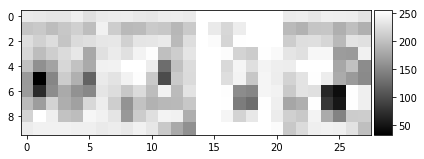

In [59]:
data_provider = DataProvider2(metadata)
eg = data_provider.get_batch()[1]
#img = dcgan.generator.predict(eg)
img = np.squeeze(eg, axis=(0,3))
img *= 255.0
img = img.astype(int)
print("output shape: ", img.shape)
io.imshow(img, cmap='gray')


In [ ]:
example = data_test.__getitem__(3)
    latent = example[0]
    print("latent shape: ", latent.shape)
    print("latent: ", latent)
    img = gen_model.predict(latent)
    img = np.squeeze(img, axis=(0,3))
    img *= 255.0
    img = img.astype(int)
    print("output shape: ", img.shape)

    actual = example[1]
    actual = np.squeeze(actual, axis=(0,3))
    #actual = np.expand_dims(actual, axis=3)
    actual *= 255.0
    actual = actual.astype(int)
    print("actual shape: ", actual.shape)


    #latent = np.squeeze(latent, axis=(0,3))
    #latent *= 255.0
    #latent = latent.astype(int)

    #print("INPUT")
    #io.imshow(latent, cmap='gray')
    #io.show()
    print("OUTPUT")
    io.imshow(img, cmap='gray')
    io.show()
    print("TARGET")
    io.imshow(actual, cmap='gray')
    io.show()

In [ ]:
current_model.train(200, data_train, data_test, verbose=True, pretrain_discriminator=False)

In [ ]:
current_model.train(200, data_train, data_test, verbose=True, pretrain_discriminator=False)

In [ ]:
current_model.train(200, data_train, data_test, verbose=True, pretrain_discriminator=False)

In [39]:
lrs = []
losses = []
for g_lr in np.logspace(-1, -4, 4):
    for d_lr in np.logspace(-1, -4, 4):
        for gan_lr in np.logspace(-1, -4, 4):
            lrs.append([g_lr, d_lr, gan_lr])
            losses = np.array([test_gan(g_input, g_output, d_input, d_output, epochs=5, first_category_only=True, g_lr=g_lr, d_lr=d_lr, gan_lr=gan_lr)])
            loss_name = "LR_TEST_glr" + g_lr + "_dlr" + d_lr + "_ganlr" + gan_lr + ".txt"
            losses.tofile(loss_name, sep=' ')
lrs = np.array(lrs)
#losses = np.array(losses)
lrs.tofile("LR_TEST_lrs.txt", sep=' ')
#losses.tofile("LR_TEST_losses.txt", sep=' ')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       30566209  
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 30,566,273
Trainable params: 30,544,321
Non-trainable params: 21,952
_________________________________________________________________
epoch None progress report:
latent shape:  (1, 100)
latent:  [[5.03194149e-01 7.12300051e-02 6.59512319e-01 2.43103281e-01
  5.10161768e-01 8.83115224e-01 9.05384995e-01 9.81029726e-01
  1.18034855e-01 5.37352666e-01 2.61519143e-01 7.49370361e-04
  6.21116601e-01 9.18315230e-01 9.18642070e-01 6.67008747e-01
  6.81610137e-01 8.94693026e-01 1.75353018e-01 6.85276087e-01
  6.58779084e-01 2

TARGET


KeyboardInterrupt: 

In [37]:
print(len(losses))

7


more layrs?
loss function?  scale back dropout? pretrain discriminator?

### Parameterized Generation

#### Concatenating a one-hot vector

In [ ]:
# NOTE: this only works under the assumption that the input image dimension is larger in pixels than the number of categories
# TODO: this just replaces the first strip rn, but I'm not fixing it rn cause that would require messing with the shape
def concat_with_one_hot(img, latent_category):
    one_hot_vector = np.zeros(img.shape[1])
    one_hot_vector[latent_category] = 1
    img[0] = one_hot_vector # TODO: should it matter which is first or along which dimension?  investigate
    return img
    

In [ ]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 4, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

In [ ]:
test_gan(g_input, g_output, d_input, d_output, first_category_only=True, input_method=concat_with_one_hot)